<a href="https://colab.research.google.com/github/ce3tnia/ProjectStockPredictStreamlit/blob/main/Skripsi_StockPredictionMultivariateGRU_Cecilia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preprocessing**

In [ ]:
# Install required Libraries
!pip install pandas_datareader

In [ ]:
!pip install  tensorflow==2.6

In [ ]:
!pip install keras==2.6

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
!pip install yfinance --upgrade --no-cache-dir

In [ ]:
## Import Libraries and set information
from pandas_datareader import data as pdr
from datetime import date

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import square, mean
from keras.utils.vis_utils import plot_model
import yfinance as yf

yf.pdr_override()

# Get Current Date
today = date.today()

# Set Info
start_date = '2010-01-01'
end_date = '2022-02-08'

rates = ['MXNUSD=X', 'EURUSD=X']
assets = {'AAPL':'USD', 'AAPL.MX':'MXN', 'APC.F':'EUR'}
tickers = yf.Tickers(' '.join(rates))

#Convert Low price
exchange_low = []
for i in tickers.tickers:
    exchange_low.append(tickers.tickers[i].history(start=start_date, end=end_date).Low)

exlow_df = pd.DataFrame(exchange_low).T
exlow_df.columns = rates
exlow_df['USDUSD=X'] = 1.0

low_df = pd.DataFrame()
for k,v in assets.items():
    data = yf.download(k, start=start_date, end=end_date, progress=False).Low.to_frame()
    data['ticker'] = k
    if v[:3] == 'USD':
        data['rating'] = exlow_df['USDUSD=X']
        data['xlow'] = data['Low'] * data['rating'] 
    elif v[:3] == 'MXN':
        data['rating'] = exlow_df['MXNUSD=X']
        data['xlow'] = data['Low'] * data['rating'] 
    elif v[:3] == 'EUR':
        data['rating'] = exlow_df['EURUSD=X']
        data['xlow'] = data['Low'] * data['rating'] 
    else:
        data['rating'] = np.NaN
        data['xlow'] = np.NaN
    low_df = pd.concat([low_df, data], axis=0)

In [ ]:
#Convert Open price
exchange_open = []
for i in tickers.tickers:
    exchange_open.append(tickers.tickers[i].history(start=start_date, end=end_date).Open)

exop_df = pd.DataFrame(exchange_open).T
exop_df.columns = rates
exop_df['USDUSD=X'] = 1.0

open_df = pd.DataFrame()
for k,v in assets.items():
    data = yf.download(k, start=start_date, end=end_date, progress=False).Open.to_frame()
    data['ticker'] = k
    if v[:3] == 'USD':
        data['rating'] = exop_df['USDUSD=X']
        data['xopen'] = data['Open'] * data['rating'] 
    elif v[:3] == 'MXN':
        data['rating'] = exop_df['MXNUSD=X']
        data['xopen'] = data['Open'] * data['rating'] 
    elif v[:3] == 'EUR':
        data['rating'] = exop_df['EURUSD=X']
        data['xopen'] = data['Open'] * data['rating'] 
    else:
        data['rating'] = np.NaN
        data['xopen'] = np.NaN
    open_df = pd.concat([open_df, data], axis=0)

In [ ]:
#Convert Close price
exchange_close = []
for i in tickers.tickers:
    exchange_close.append(tickers.tickers[i].history(start=start_date, end=end_date).Close)

excl_df = pd.DataFrame(exchange_close).T
excl_df.columns = rates
excl_df['USDUSD=X'] = 1.0

close_df = pd.DataFrame()
for k,v in assets.items():
    data = yf.download(k, start=start_date, end=end_date, progress=False).Close.to_frame()
    data['ticker'] = k
    if v[:3] == 'USD':
        data['rating'] = excl_df['USDUSD=X']
        data['xclose'] = data['Close'] * data['rating'] 
    elif v[:3] == 'MXN':
        data['rating'] = excl_df['MXNUSD=X']
        data['xclose'] = data['Close'] * data['rating'] 
    elif v[:3] == 'EUR':
        data['rating'] = excl_df['EURUSD=X']
        data['xclose'] = data['Close'] * data['rating']
    else:
        data['rating'] = np.NaN
        data['xclose'] = np.NaN
    close_df = pd.concat([close_df, data], axis=0)

In [ ]:
#Convert High price
exchange_high = []
for i in tickers.tickers:
    exchange_high.append(tickers.tickers[i].history(start=start_date, end=end_date).High)

exhigh_df = pd.DataFrame(exchange_high).T
exhigh_df.columns = rates
exhigh_df['USDUSD=X'] = 1.0

high_df = pd.DataFrame()
for k,v in assets.items():
    data = yf.download(k, start=start_date, end=end_date, progress=False).High.to_frame()
    data['ticker'] = k
    if v[:3] == 'USD':
        data['rating'] = exhigh_df['USDUSD=X']
        data['xhigh'] = data['High'] * data['rating'] 
    elif v[:3] == 'MXN':
        data['rating'] = exhigh_df['MXNUSD=X']
        data['xhigh'] = data['High'] * data['rating'] 
    elif v[:3] == 'EUR':
        data['rating'] = exhigh_df['EURUSD=X']
        data['xhigh'] = data['High'] * data['rating'] 
    else:
        data['rating'] = np.NaN
        data['xhigh'] = np.NaN
    high_df = pd.concat([high_df, data], axis=0)

#Volume
volume_df = pd.DataFrame()
for k,v in assets.items():
    data = yf.download(k, start=start_date, end=end_date, progress=False).Volume.to_frame()
    data['ticker'] = k
    volume_df = pd.concat([volume_df, data], axis=0)

In [ ]:
# data real stock before convert

yf.pdr_override()

stocks_df = pd.DataFrame()
for k,v in assets.items():
    stock = pdr.get_data_yahoo(k, start_date, end_date)
    stock['ticker'] = k
    stocks_df = pd.concat([stocks_df, stock], axis=0)
  
stocks_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04    7.622500    7.660714    7.585000    7.643214    6.535086   
2010-01-05    7.664286    7.699643    7.616071    7.656429    6.546385   
2010-01-06    7.656429    7.686786    7.526786    7.534643    6.442255   
2010-01-07    7.562500    7.571429    7.466071    7.520714    6.430346   
2010-01-08    7.510714    7.571429    7.466429    7.570714    6.473095   
...                ...         ...         ...         ...         ...   
2022-02-01  155.820007  156.679993  153.460007  155.039993  154.572693   
2022-02-02  155.500000  155.779999  153.880005  155.020004  154.552765   
2022-02-03  153.000000  154.759995  150.880005  150.880005  150.425232   
2022-02-04  153.000000  153.000000  148.919998  151.479996  151.243958   
2022-02-07  150.720001  152.000000  149.500000  149.660004  149.426804   

               Volume ticker  
Date                          
2010-01-04  493729600   AAPL  
2010-01-05  601904800   AAPL  
2010-01-06  552160000   AAPL  
2010-01-07  477131200   AAPL  
2010-01-08  447610800   AAPL  
...               ...    ...  
2022-02-01      10008  APC.F  
2022-02-02       8707  APC.F  
2022-02-03       7510  APC.F  
2022-02-04      13210  APC.F  
2022-02-07       6170  APC.F  

[9150 rows x 7 columns]

In [ ]:
stock_df = pd.DataFrame()
stock_df = pd.concat([stock_df, open_df['ticker'], low_df['xlow'], open_df['xopen'], close_df['xclose'], high_df['xhigh'], volume_df['Volume']], axis=1)

In [ ]:
stock_df

ticker        xlow       xopen      xclose       xhigh     Volume
2010-01-04   AAPL    7.585000    7.622500    7.643214    7.660714  493729600
2010-01-05   AAPL    7.616071    7.664286    7.656429    7.699643  601904800
2010-01-06   AAPL    7.526786    7.656429    7.534643    7.686786  552160000
2010-01-07   AAPL    7.466071    7.562500    7.520714    7.571429  477131200
2010-01-08   AAPL    7.466429    7.510714    7.570714    7.571429  447610800
...           ...         ...         ...         ...         ...        ...
2022-02-01  APC.F  172.214120  174.972498  174.104427  176.720037      10008
2022-02-02  APC.F  173.376150  175.296192  174.768875  176.489252       8707
2022-02-03  APC.F  170.072716  172.889179  170.493595  177.210836       7510
2022-02-04  APC.F  169.968957  174.957119  173.228873  175.700505      13210
2022-02-07  APC.F  170.679645  172.644075  171.437738  174.192059       6170

[9150 rows x 6 columns]

In [ ]:
stock_df.isnull().sum()

ticker    0
xlow      7
xopen     7
xclose    7
xhigh     7
Volume    0
dtype: int64

In [ ]:
stock_df = stock_df.ffill()

In [ ]:
stock_aapl = stock_df.loc[stock_df['ticker'] == 'AAPL']
stock_f = stock_df.loc[stock_df['ticker'] == 'APC.F']
stock_mx = stock_df.loc[stock_df['ticker'] == 'AAPL.MX']

In [ ]:
stock_aapl

ticker        xlow       xopen      xclose       xhigh     Volume
2010-01-04   AAPL    7.585000    7.622500    7.643214    7.660714  493729600
2010-01-05   AAPL    7.616071    7.664286    7.656429    7.699643  601904800
2010-01-06   AAPL    7.526786    7.656429    7.534643    7.686786  552160000
2010-01-07   AAPL    7.466071    7.562500    7.520714    7.571429  477131200
2010-01-08   AAPL    7.466429    7.510714    7.570714    7.571429  447610800
...           ...         ...         ...         ...         ...        ...
2022-02-01   AAPL  172.309998  174.009995  174.610001  174.839996   86213900
2022-02-02   AAPL  173.330002  174.750000  175.839996  175.880005   84914300
2022-02-03   AAPL  172.119995  174.479996  172.899994  176.240005   89418100
2022-02-04   AAPL  170.679993  171.679993  172.389999  174.100006   82391400
2022-02-07   AAPL  170.949997  172.860001  171.660004  173.949997   77251200

[3046 rows x 6 columns]

In [ ]:
stock_f

ticker        xlow       xopen      xclose       xhigh  Volume
2010-01-04  APC.F    7.490138    7.553657    7.647283    7.685319  209916
2010-01-05  APC.F    7.596276    7.656667    7.706310    7.769146  288148
2010-01-06  APC.F    7.477373    7.690918    7.582694    7.730242  151340
2010-01-07  APC.F    7.452395    7.566716    7.516967    7.648012  171584
2010-01-08  APC.F    7.441324    7.531259    7.547809    7.661419  230132
...           ...         ...         ...         ...         ...     ...
2022-02-01  APC.F  172.214120  174.972498  174.104427  176.720037   10008
2022-02-02  APC.F  173.376150  175.296192  174.768875  176.489252    8707
2022-02-03  APC.F  170.072716  172.889179  170.493595  177.210836    7510
2022-02-04  APC.F  169.968957  174.957119  173.228873  175.700505   13210
2022-02-07  APC.F  170.679645  172.644075  171.437738  174.192059    6170

[3069 rows x 6 columns]

In [ ]:
stock_mx

ticker        xlow       xopen      xclose       xhigh  Volume
2010-01-04  AAPL.MX    7.503761    7.539367    7.657437    7.677780   35280
2010-01-05  AAPL.MX    7.608802    7.683527    7.658159    7.740929   96460
2010-01-06  AAPL.MX    7.487237    7.665034    7.546832    7.723945   13440
2010-01-07  AAPL.MX    7.479315    7.550660    7.501002    7.561044  115500
2010-01-08  AAPL.MX    7.455817    7.481058    7.576917    7.579966  151340
...             ...         ...         ...         ...         ...     ...
2022-01-31  AAPL.MX  168.733985  170.133548  172.509953  174.949043   21102
2022-02-01  AAPL.MX  171.653467  174.053004  173.887197  175.266648   14827
2022-02-02  AAPL.MX  173.284525  174.837096  175.575909  176.595089   12348
2022-02-03  AAPL.MX  172.562974  174.878790  173.385524  176.679995   13182
2022-02-04  AAPL.MX  169.959896  171.954375  173.871613  174.956402    3036

[3035 rows x 6 columns]

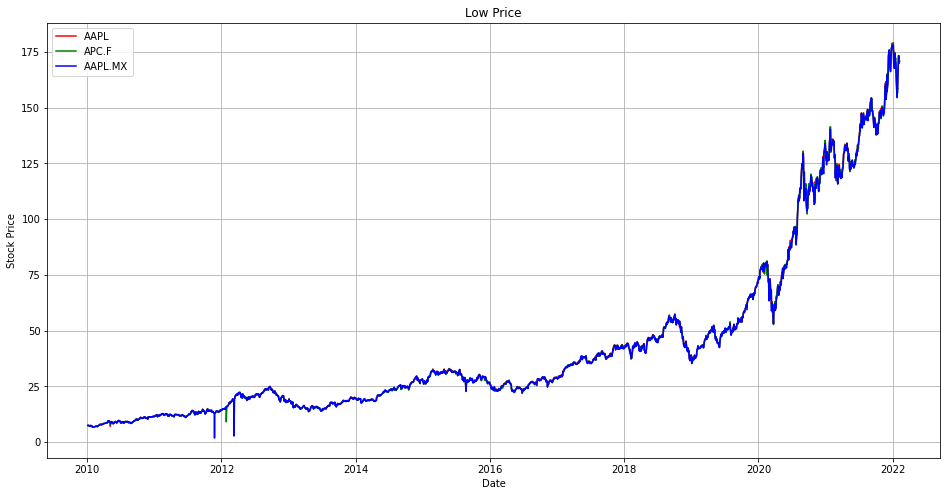

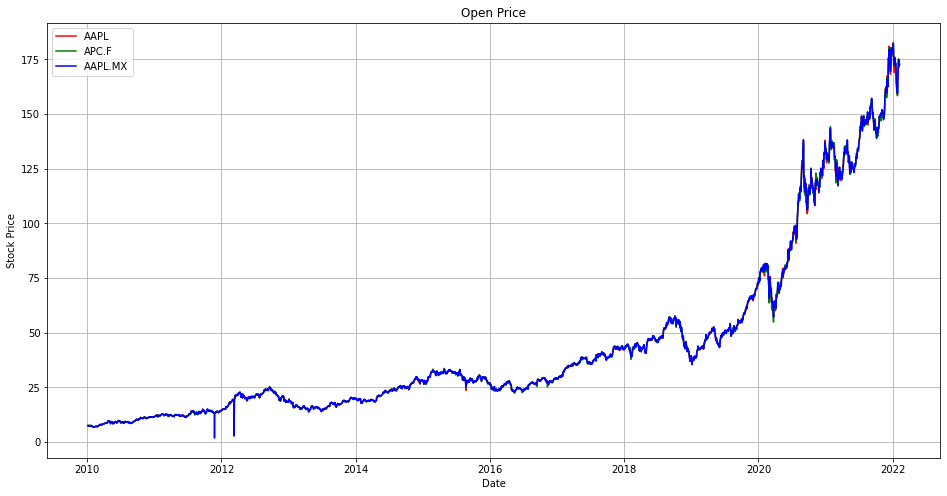

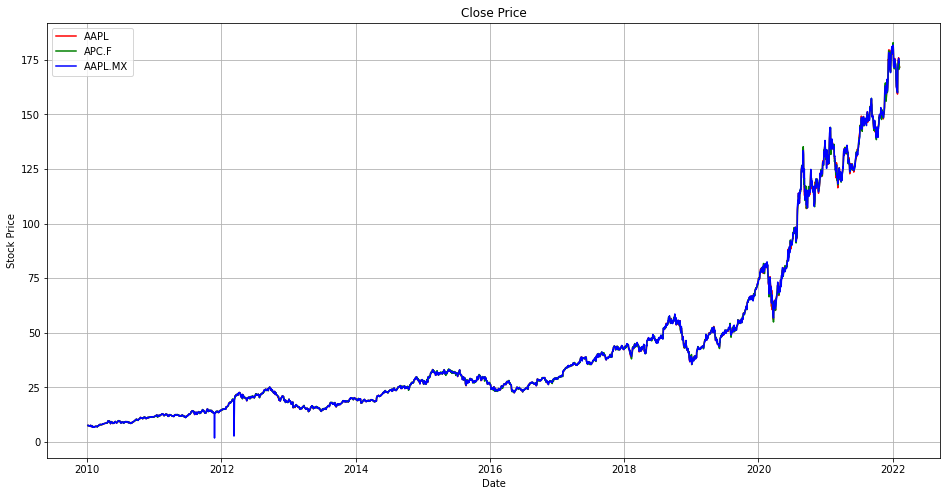

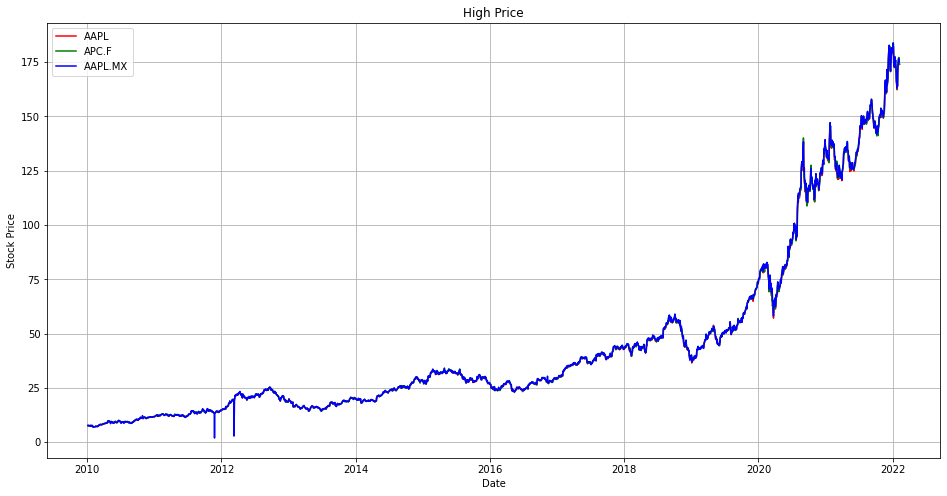

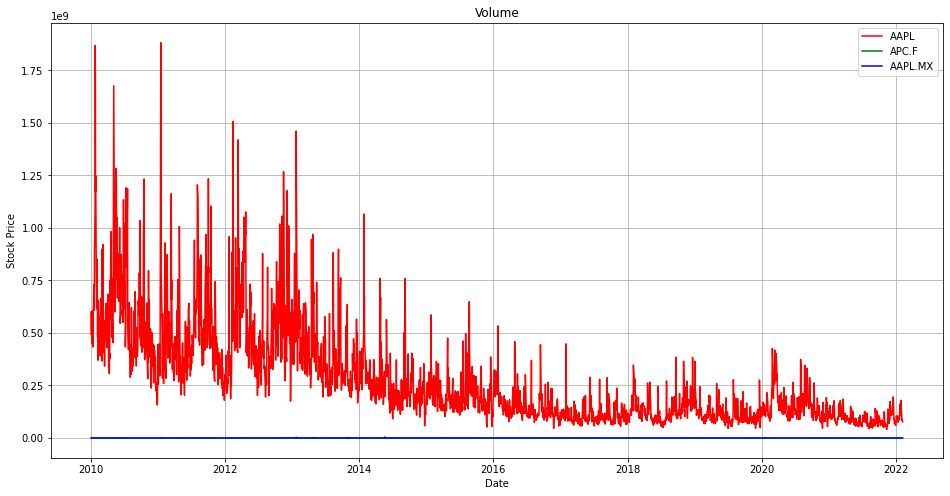

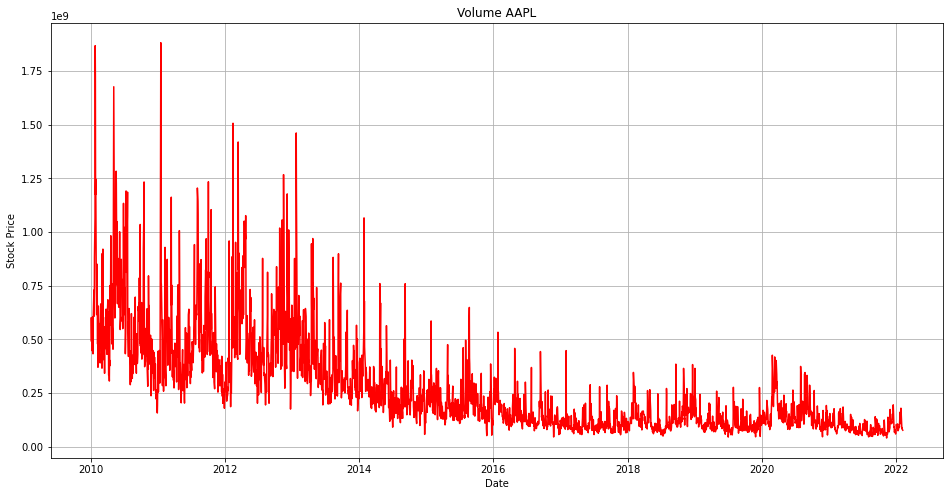

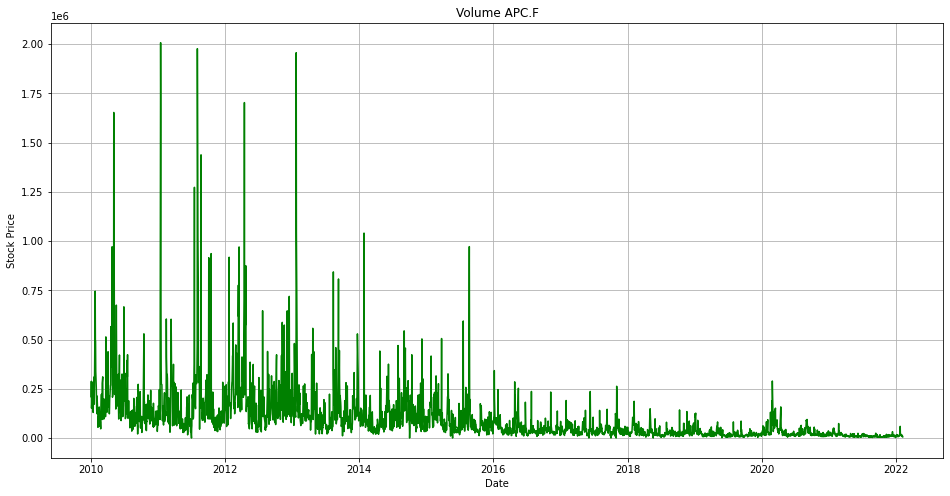

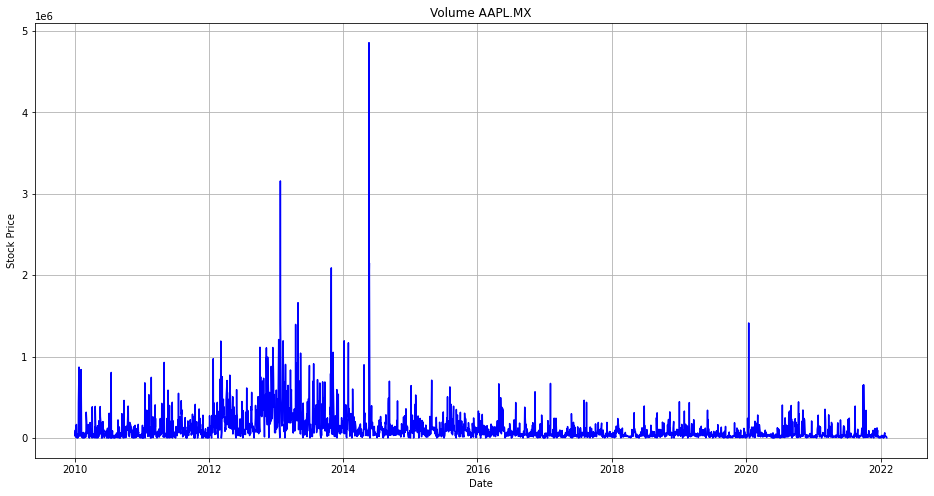

In [ ]:
#Low
plt.figure(figsize=(16,8))
plt.title('Low Price')
plt.plot(stock_aapl['xlow'], color='r')
plt.plot(stock_f['xlow'], color='g')
plt.plot(stock_mx['xlow'], color='b')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['AAPL','APC.F','AAPL.MX'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

#Open
plt.figure(figsize=(16,8))
plt.title('Open Price')
plt.plot(stock_aapl['xopen'], color='r')
plt.plot(stock_f['xopen'], color='g')
plt.plot(stock_mx['xopen'], color='b')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['AAPL','APC.F','AAPL.MX'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

#close
plt.figure(figsize=(16,8))
plt.title('Close Price')
plt.plot(stock_aapl['xclose'], color='r')
plt.plot(stock_f['xclose'], color='g')
plt.plot(stock_mx['xclose'], color='b')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['AAPL','APC.F','AAPL.MX'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

#High
plt.figure(figsize=(16,8))
plt.title('High Price')
plt.plot(stock_aapl['xhigh'], color='r')
plt.plot(stock_f['xhigh'], color='g')
plt.plot(stock_mx['xhigh'], color='b')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['AAPL','APC.F','AAPL.MX'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

#Volume
plt.figure(figsize=(16,8))
plt.title('Volume')
plt.plot(stock_aapl['Volume'], color='r')
plt.plot(stock_f['Volume'], color='g')
plt.plot(stock_mx['Volume'], color='b')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['AAPL','APC.F','AAPL.MX'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

#Volume
plt.figure(figsize=(16,8))
plt.title('Volume AAPL')
plt.plot(stock_aapl['Volume'], color='r')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

#Volume
plt.figure(figsize=(16,8))
plt.title('Volume APC.F')
plt.plot(stock_f['Volume'], color='g')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

#Volume
plt.figure(figsize=(16,8))
plt.title('Volume AAPL.MX')
plt.plot(stock_mx['Volume'], color='b')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

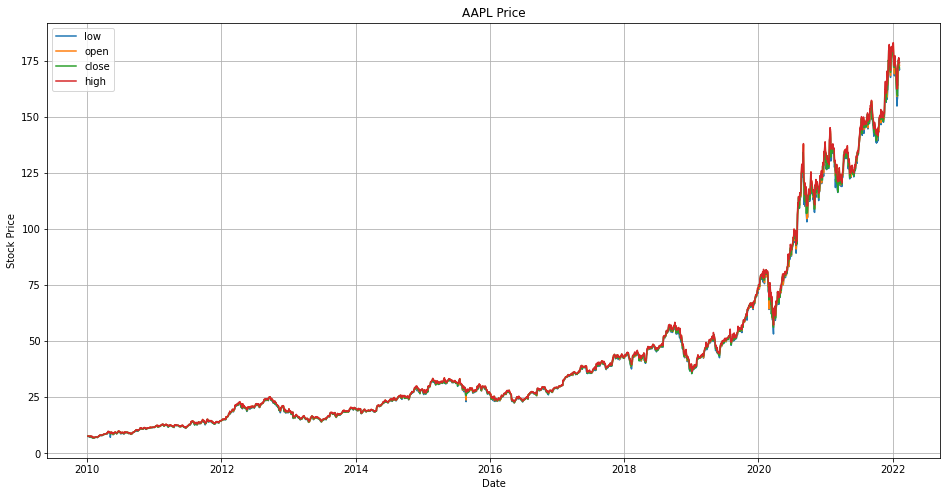

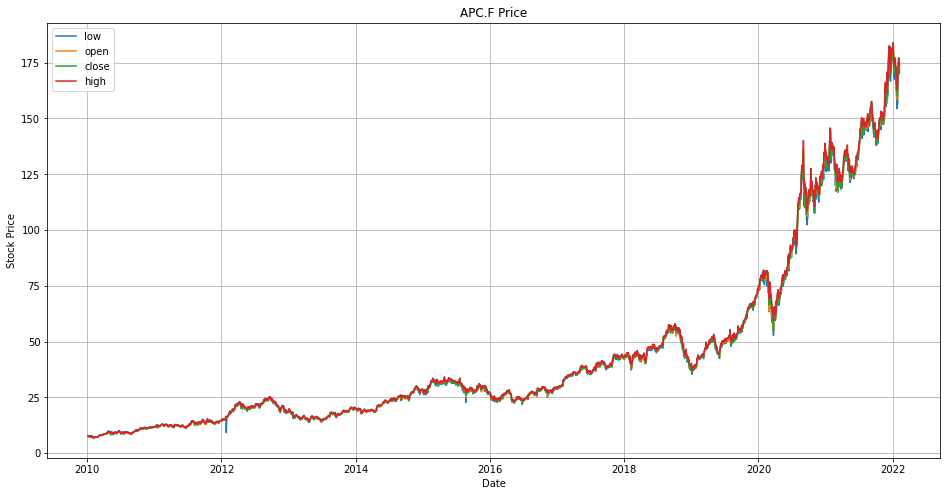

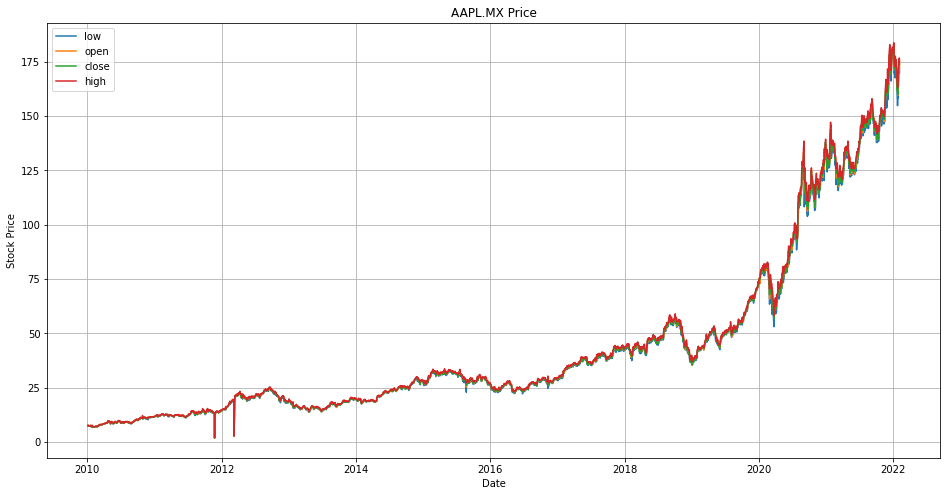

In [ ]:
# graph stock 

#AAPL
plt.figure(figsize=(16,8))
plt.title('AAPL Price')
plt.plot(stock_aapl['xlow'])
plt.plot(stock_aapl['xopen'])
plt.plot(stock_aapl['xclose'])
plt.plot(stock_aapl['xhigh'])

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['low','open','close','high'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

#APC.F
plt.figure(figsize=(16,8))
plt.title('APC.F Price')
plt.plot(stock_f['xlow'])
plt.plot(stock_f['xopen'])
plt.plot(stock_f['xclose'])
plt.plot(stock_f['xhigh'])

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['low','open','close','high'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

#AAPL.MX
plt.figure(figsize=(16,8))
plt.title('AAPL.MX Price')
plt.plot(stock_mx['xlow'])
plt.plot(stock_mx['xopen'])
plt.plot(stock_mx['xclose'])
plt.plot(stock_mx['xhigh'])

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['low','open','close','high'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

# **AAPL**

In [ ]:
# Extract price
data_aapl = stock_aapl.filter(['xlow','xopen','xclose','xhigh','Volume'])
dataset_aapl = data_aapl.values

In [ ]:
# Preprocess the data
normalizer = MinMaxScaler(feature_range=(0,1)) # instantiate scaler
normalizedData_aapl = normalizer.fit_transform(dataset_aapl) # values between 0,1
print(normalizedData_aapl)

[[0.00458642 0.00427938 0.00447776 0.00375534 0.24604896]
 [0.00476673 0.00451713 0.00455321 0.0039766  0.3048399 ]
 [0.00424861 0.00447242 0.00385789 0.00390352 0.27780465]
 ...
 [0.95937916 0.9536298  0.94798775 0.96191885 0.02631421]
 [0.95102286 0.93769894 0.94507601 0.94975562 0.02249535]
 [0.95258969 0.9444127  0.94090821 0.948903   0.01970176]]


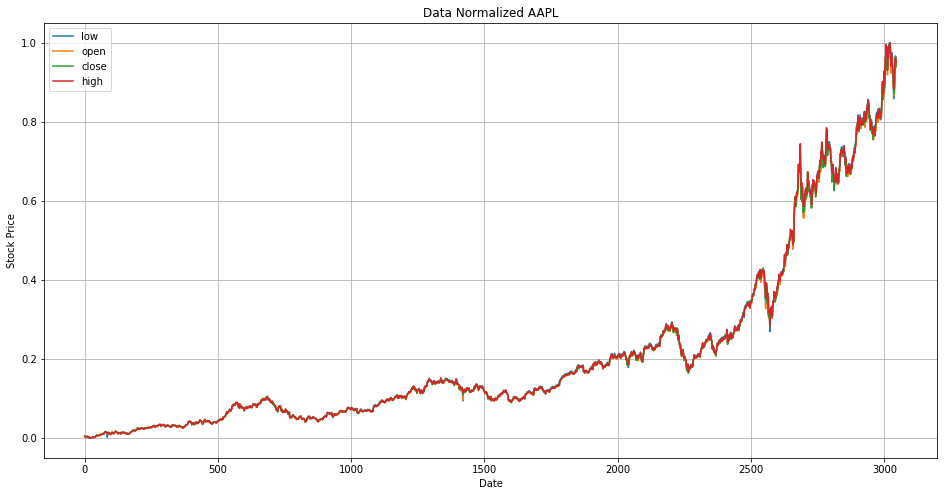

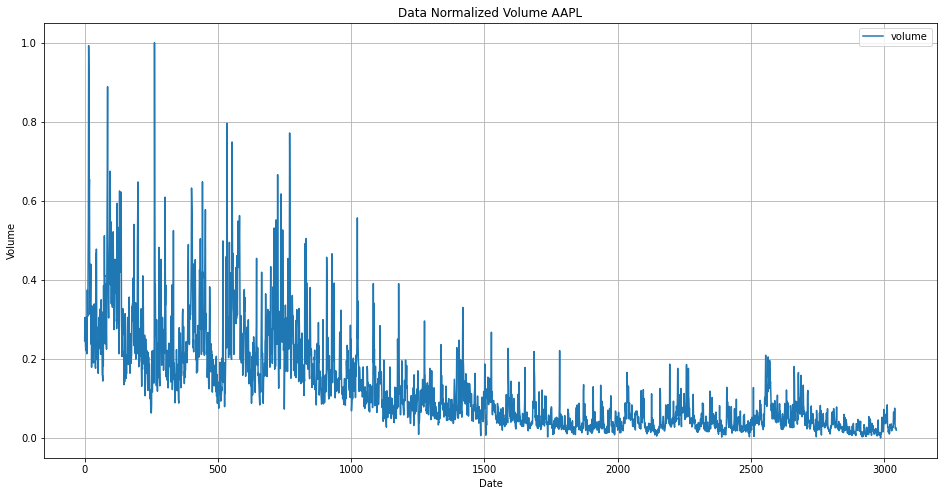

In [ ]:
# Visualization data normalized

# AAPL
plt.figure(figsize=(16,8))
plt.title('Data Normalized AAPL')
plt.plot(normalizedData_aapl[:,:4])

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['low','open','close','high'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

plt.figure(figsize=(16,8))
plt.title('Data Normalized Volume AAPL')
plt.plot(normalizedData_aapl[:,4:])

plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(['volume'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

In [ ]:
# Storing the number of data points in the array
num_data_aapl = len(normalizedData_aapl)
num_days_used = 40
data_used_aapl = np.array([normalizedData_aapl[i : i + num_days_used].copy() for i in range(num_data_aapl - num_days_used)])

# Creating a numpy array that contains the value(s) to predict
# Currently, trying to fit the 4 outputs
data_to_predict_aapl = np.array(normalizedData_aapl[(num_days_used):, :4])

# Creating a dates array for the dates that were used by data_used
dates_used_aapl = stock_aapl.index[num_days_used:num_data_aapl]

# Storing the scaler object for prediction later
y_normaliser_aapl = MinMaxScaler()
y_normaliser_aapl.fit(stock_aapl[['xlow', 'xopen', 'xclose', 'xhigh']].to_numpy()[num_days_used:])

display(normalizedData_aapl.shape, data_used_aapl.shape,data_to_predict_aapl.shape, dates_used_aapl.shape)

(3046, 5)

(3006, 40, 5)

(3006, 4)

(3006,)

In [ ]:
train_split = 0.8
data_size_aapl = data_used_aapl.shape[0]
num_features_aapl = data_used_aapl.shape[2]
train_size_aapl = int(data_size_aapl * train_split)
test_size_aapl = data_size_aapl - train_size_aapl

# Splitting the dataset up into train and test sets
X_train_aapl = data_used_aapl[0:train_size_aapl, :, :]
y_train_aapl = data_to_predict_aapl[0:train_size_aapl, :]
dates_train_aapl = dates_used_aapl[0:train_size_aapl]
X_test_aapl = data_used_aapl[train_size_aapl:, :, :]
y_test_aapl = data_to_predict_aapl[train_size_aapl:, :]
dates_test_aapl = dates_used_aapl[train_size_aapl:]

unscaled_y_train_aapl = stock_aapl[['xlow', 'xopen', 'xclose', 'xhigh']].to_numpy()[(num_days_used):][0:train_size_aapl, :]
unscaled_y_test_aapl = stock_aapl[['xlow', 'xopen', 'xclose', 'xhigh']].to_numpy()[(num_days_used):][train_size_aapl:, :]

display("X_train shape:", X_train_aapl.shape, "y_train shape:", y_train_aapl.shape, 
        "X_test shape:", X_test_aapl.shape, "y_test shape:", y_test_aapl.shape,
        "unscaled_y_train shape:", unscaled_y_train_aapl.shape, "unscaled_y_test shape:", unscaled_y_test_aapl.shape)

'X_train shape:'

(2404, 40, 5)

'y_train shape:'

(2404, 4)

'X_test shape:'

(602, 40, 5)

'y_test shape:'

(602, 4)

'unscaled_y_train shape:'

(2404, 4)

'unscaled_y_test shape:'

(602, 4)

In [ ]:
# Creating the input layer, whose shape is (num_days_used, num_features) because it is
# the open, high, low, close, volume for the past num_days_used days 
input = Input(shape=(num_days_used, num_features_aapl), name = 'input')

x = GRU(200, return_sequences=True, name='gru_1')(input)
x = Dropout(0.5)(x)
x = Dense(4, name='dense_2')(x)

# Branching out
output1 = GRU(200, return_sequences=True, name='low_0')(x)
output1 = Dropout(0.5)(output1)
output1 = GRU(200, name='low_1')(output1)
output1 = Dropout(0.5)(output1)
output1 = Dense(1, name='low_final')(output1)

output2 = GRU(200, return_sequences=True, name='open_0')(x)
output2 = Dropout(0.5)(output2)
output2 = GRU(200, name='open_1')(output2)
output2 = Dropout(0.5)(output2)
output2 = Dense(1, name='open_final')(output2)

output3 = GRU(200, return_sequences=True, name='close_0')(x)
output3 = Dropout(0.5)(output3)
output3 = GRU(200, name='close_1')(output3)
output3 = Dropout(0.5)(output3)
output3 = Dense(1, name='close_final')(output3)

output4 = GRU(200, return_sequences=True, name='high_0')(x)
output4 = Dropout(0.5)(output4)
output4 = GRU(200, name='high_1')(output4)
output4 = Dropout(0.5)(output4)
output4 = Dense(1, name='high_final')(output4)

model_aapl = Model(inputs = input, outputs = [output1, output2, output3, output4])

# Choosing Adam as the optimizer
# Adam is an optimizer of hyperparameters
adam = Adam(learning_rate=0.001)

# model.compile is where you define the type of optimizer, loss, etc. 
# that you want to use. Here, we use Adam and MAE
model_aapl.compile(optimizer=adam, loss='mae')
model_aapl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 40, 5)]      0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 40, 200)      124200      input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 40, 200)      0           gru_1[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 40, 4)        804         dropout[0][0]                    
______________________________________________________________________________________________

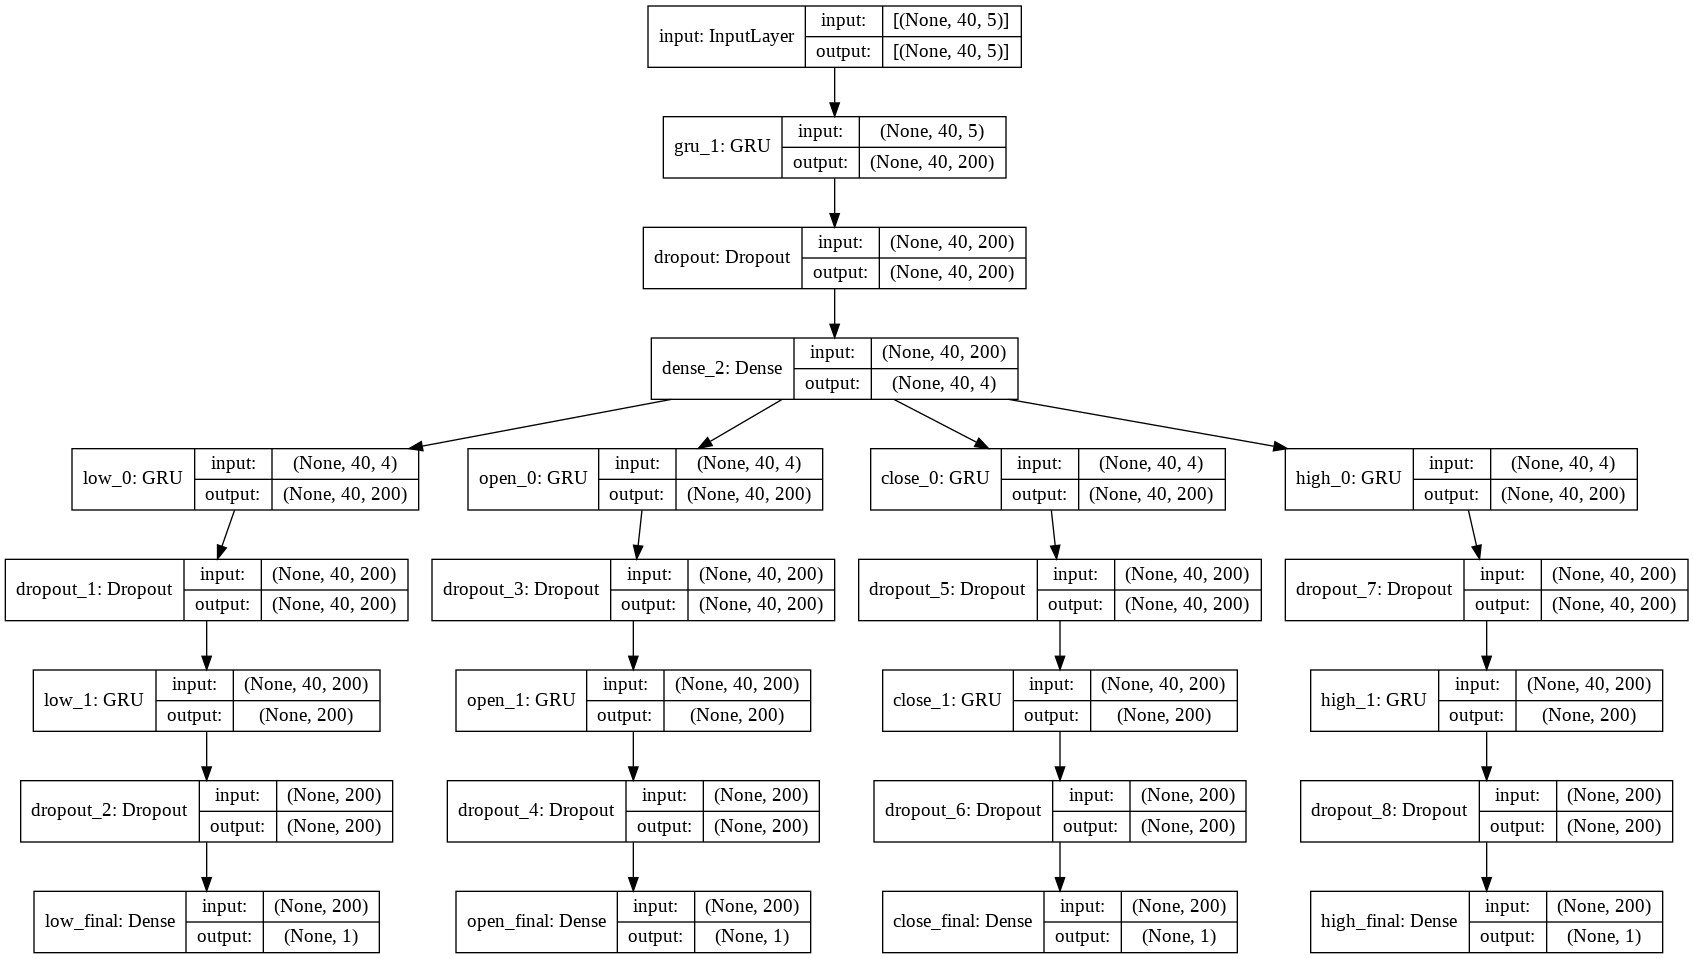

In [ ]:
# Displaying the structure of the final model
plot_model(model_aapl, show_shapes=True)

In [ ]:
history = model_aapl.fit(x=X_train_aapl, y=y_train_aapl, batch_size=32, epochs=20, validation_split=0.2)
evaluation = model_aapl.evaluate(X_test_aapl, y_test_aapl)
print(evaluation)

Epoch 1/20
61/61 [==============================] - 94s 1s/step - loss: 0.0027 - low_final_loss: 6.9696e-04 - open_final_loss: 6.5957e-04 - close_final_loss: 7.1231e-04 - high_final_loss: 6.4834e-04 - val_loss: 7.6952e-04 - val_low_final_loss: 7.4592e-05 - val_open_final_loss: 2.9665e-04 - val_close_final_loss: 2.9824e-04 - val_high_final_loss: 1.0003e-04
Epoch 2/20
61/61 [==============================] - 53s 875ms/step - loss: 5.9950e-04 - low_final_loss: 1.4841e-04 - open_final_loss: 1.5246e-04 - close_final_loss: 1.5438e-04 - high_final_loss: 1.4425e-04 - val_loss: 3.9317e-04 - val_low_final_loss: 8.9723e-05 - val_open_final_loss: 1.0723e-04 - val_close_final_loss: 8.5751e-05 - val_high_final_loss: 1.1046e-04
Epoch 3/20
61/61 [==============================] - 54s 894ms/step - loss: 5.5543e-04 - low_final_loss: 1.4058e-04 - open_final_loss: 1.3783e-04 - close_final_loss: 1.4076e-04 - high_final_loss: 1.3626e-04 - val_loss: 3.7615e-04 - val_low_final_loss: 6.7988e-05 - val_open_fina

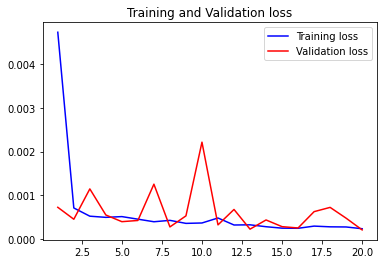

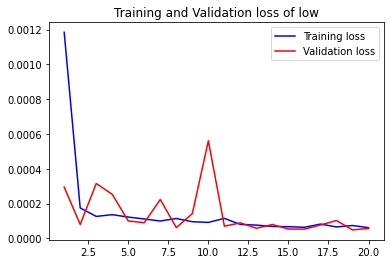

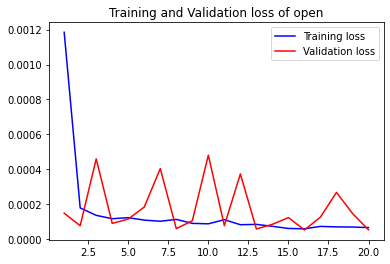

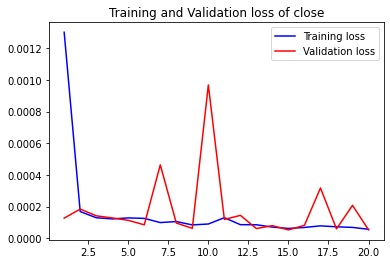

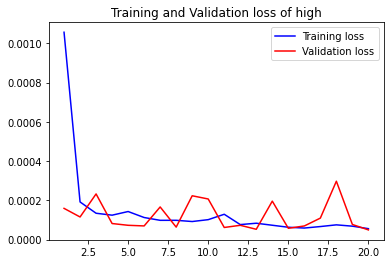

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
low_loss = history.history['low_final_loss']
val_low_loss = history.history['val_low_final_loss']
open_loss = history.history['open_final_loss']
val_open_loss = history.history['val_open_final_loss']
close_loss = history.history['close_final_loss']
val_close_loss = history.history['val_close_final_loss']
high_loss = history.history['high_final_loss']
val_high_loss = history.history['val_high_final_loss']
epochs = range(1, len(loss) + 1)
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

plt.plot(epochs, low_loss, 'b', label='Training loss')
plt.plot(epochs, val_low_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss of low')
plt.legend()
plt.show()

plt.plot(epochs, open_loss, 'b', label='Training loss')
plt.plot(epochs, val_open_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss of open')
plt.legend()
plt.show()

plt.plot(epochs, close_loss, 'b', label='Training loss')
plt.plot(epochs, val_close_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss of close')
plt.legend()
plt.show()

plt.plot(epochs, high_loss, 'b', label='Training loss')
plt.plot(epochs, val_high_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss of high')
plt.legend()
plt.show()

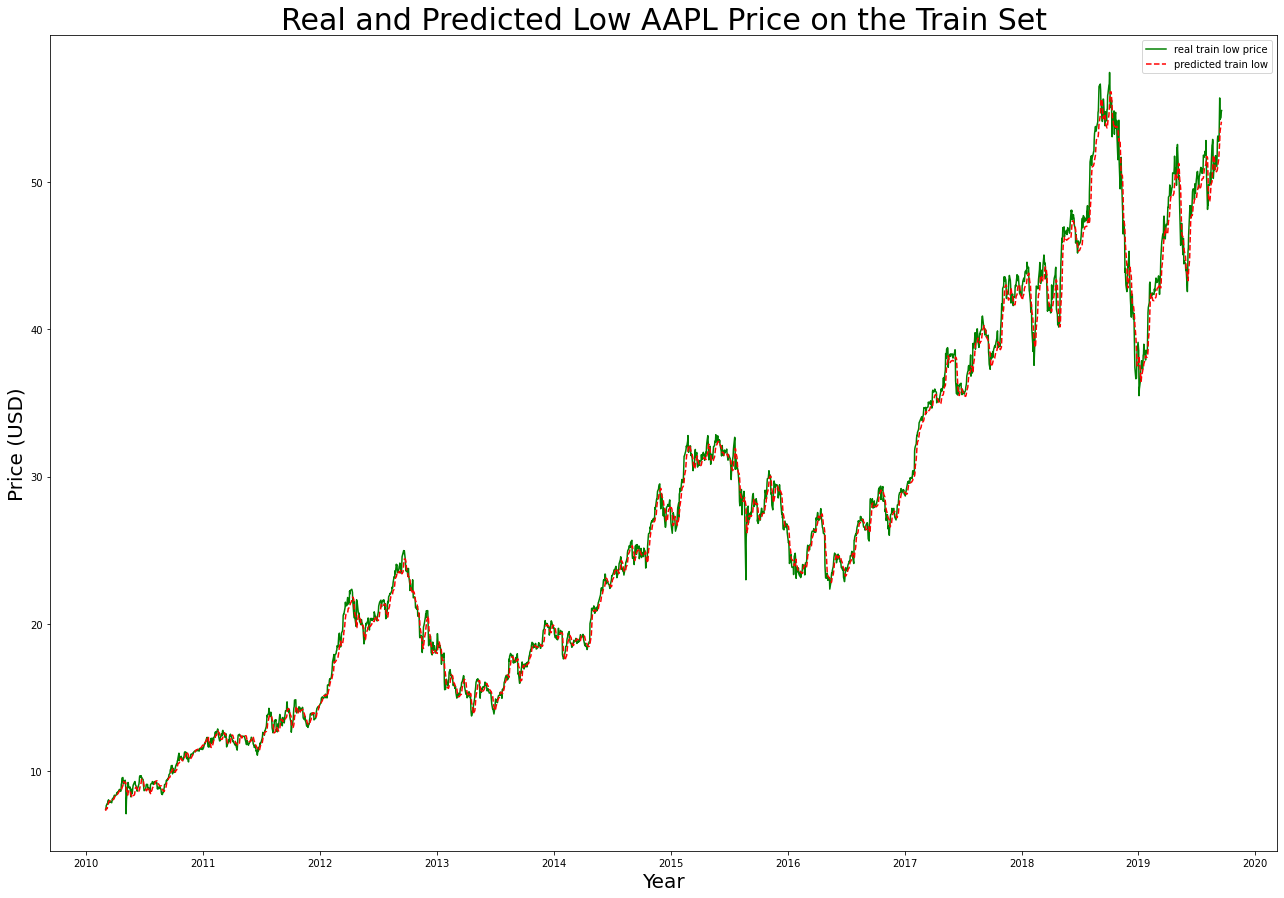

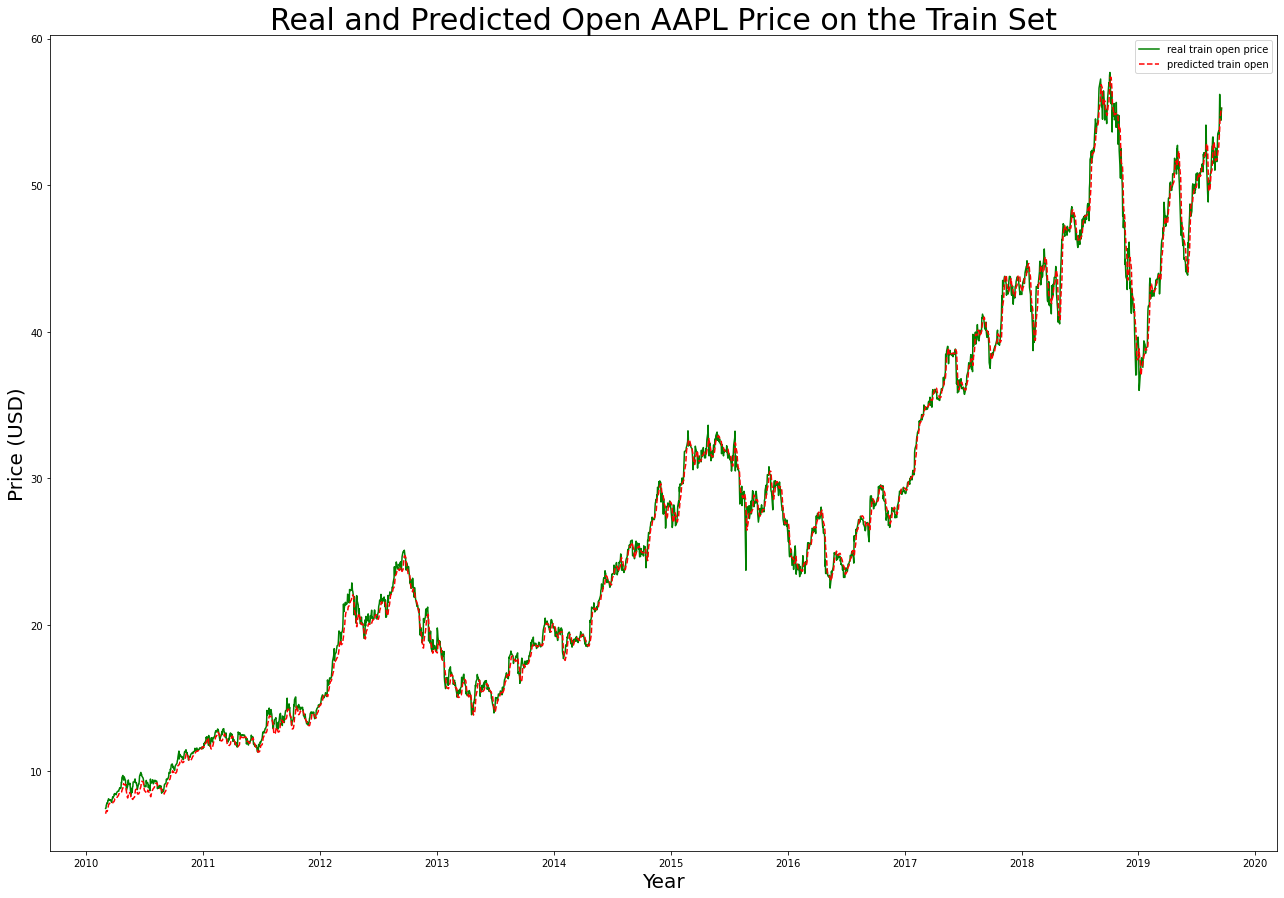

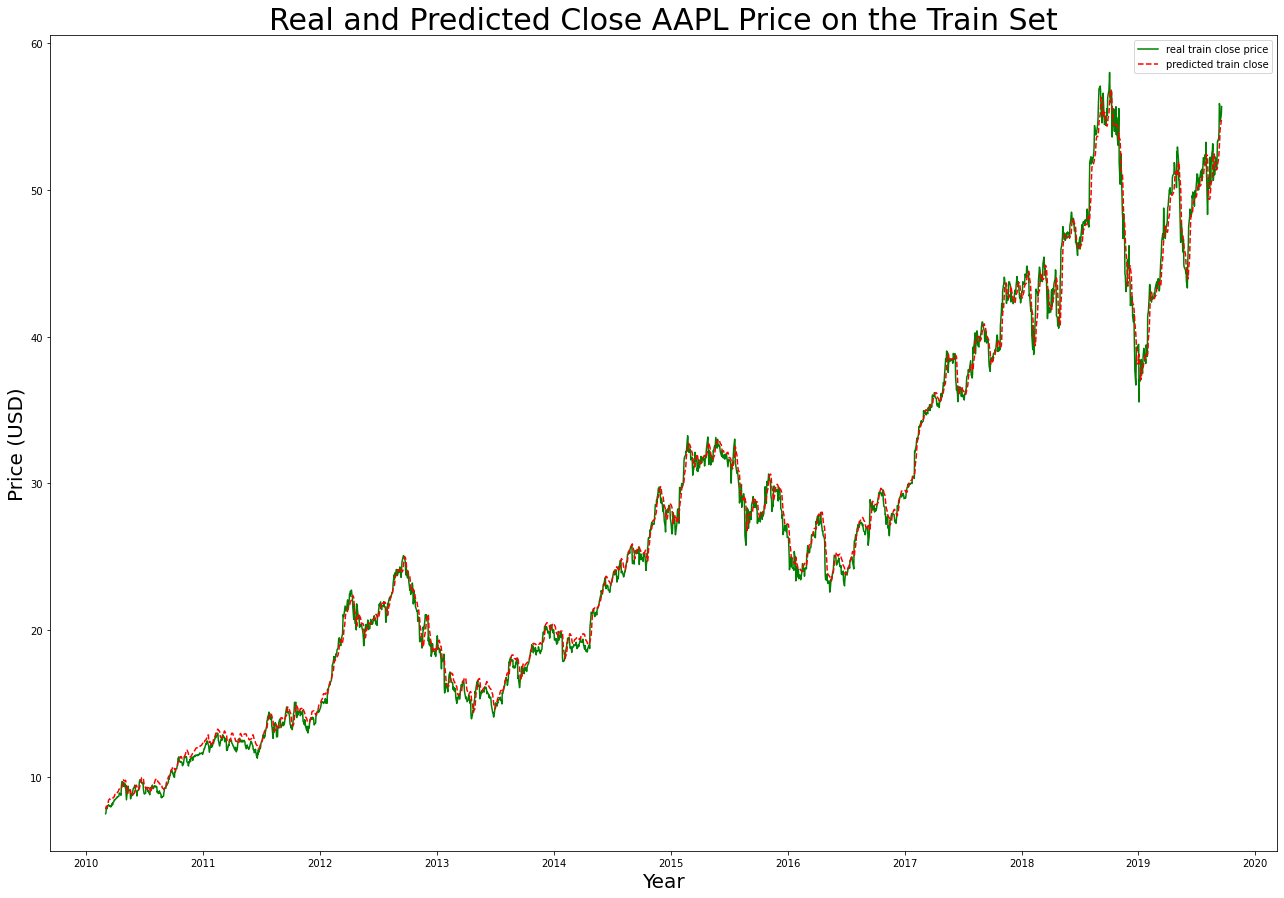

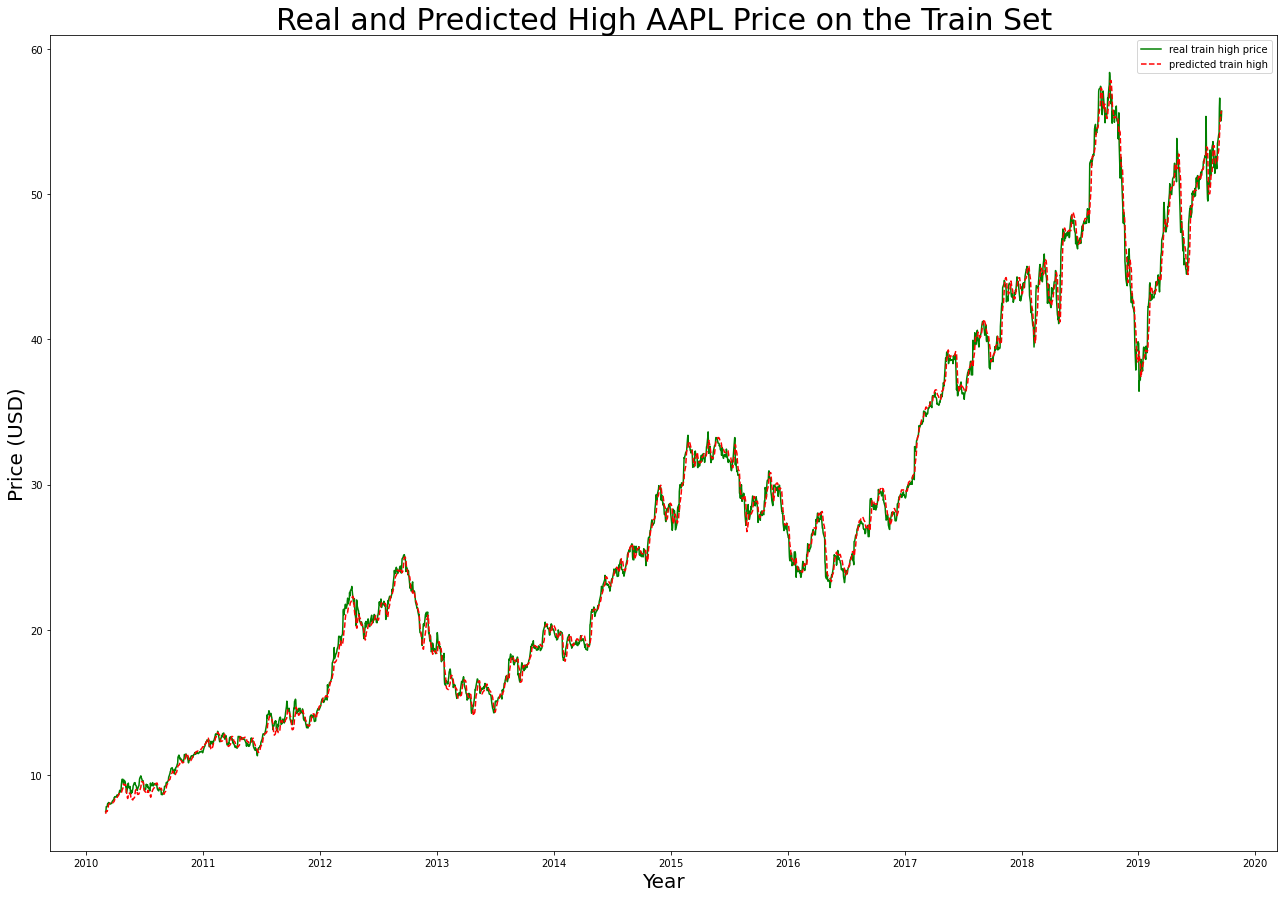

In [ ]:
y_train_low_aapl_pred, y_train_open_aapl_pred, y_train_close_aapl_pred, y_train_high_aapl_pred = model_aapl.predict(X_train_aapl)
trainpreds_arr_aapl = np.hstack((y_train_low_aapl_pred, y_train_open_aapl_pred, y_train_close_aapl_pred, y_train_high_aapl_pred))
y_train_aapl_pred = y_normaliser_aapl.inverse_transform(trainpreds_arr_aapl)

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_aapl, unscaled_y_train_aapl[:,low], label='real train low price', color='g')

# predicted values plotted
plt.plot(dates_train_aapl, y_train_aapl_pred[:,low], label='predicted train low', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low AAPL Price on the Train Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_aapl, unscaled_y_train_aapl[:,open], label='real train open price', color='g')

# predicted values plotted
plt.plot(dates_train_aapl, y_train_aapl_pred[:,open], label='predicted train open', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Open AAPL Price on the Train Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_aapl, unscaled_y_train_aapl[:,close], label='real train close price', color='g')

# predicted values plotted
plt.plot(dates_train_aapl, y_train_aapl_pred[:,close], label='predicted train close', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Close AAPL Price on the Train Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_aapl, unscaled_y_train_aapl[:,high], label='real train high price', color='g')

# predicted values plotted
plt.plot(dates_train_aapl, y_train_aapl_pred[:,high], label='predicted train high', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted High AAPL Price on the Train Set', fontsize=30)

plt.show()

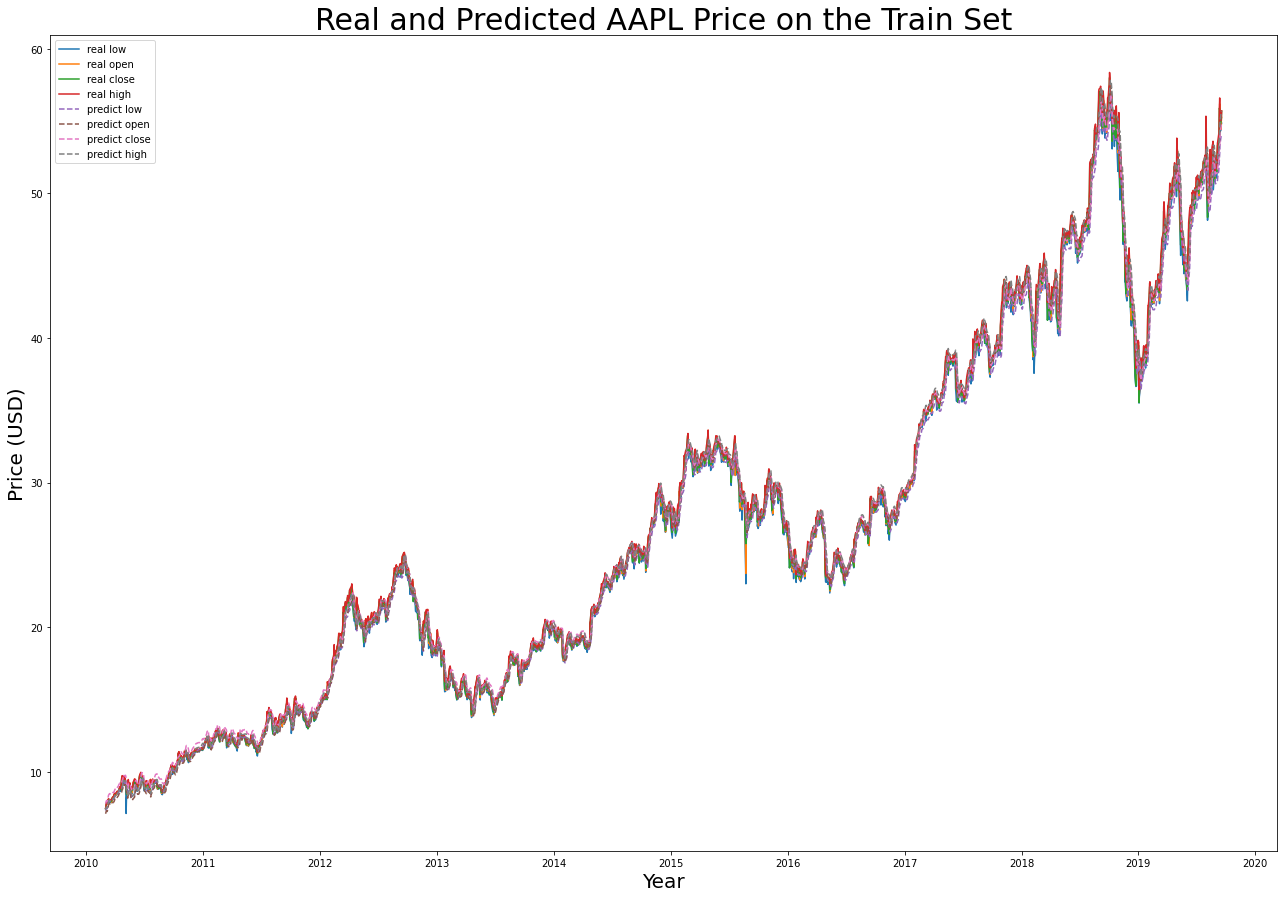

In [ ]:
plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_aapl, unscaled_y_train_aapl)

# predicted values plotted
plt.plot(dates_train_aapl, y_train_aapl_pred, linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend(['real low','real open','real close','real high','predict low','predict open','predict close','predict high'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted AAPL Price on the Train Set', fontsize=30)

plt.show()

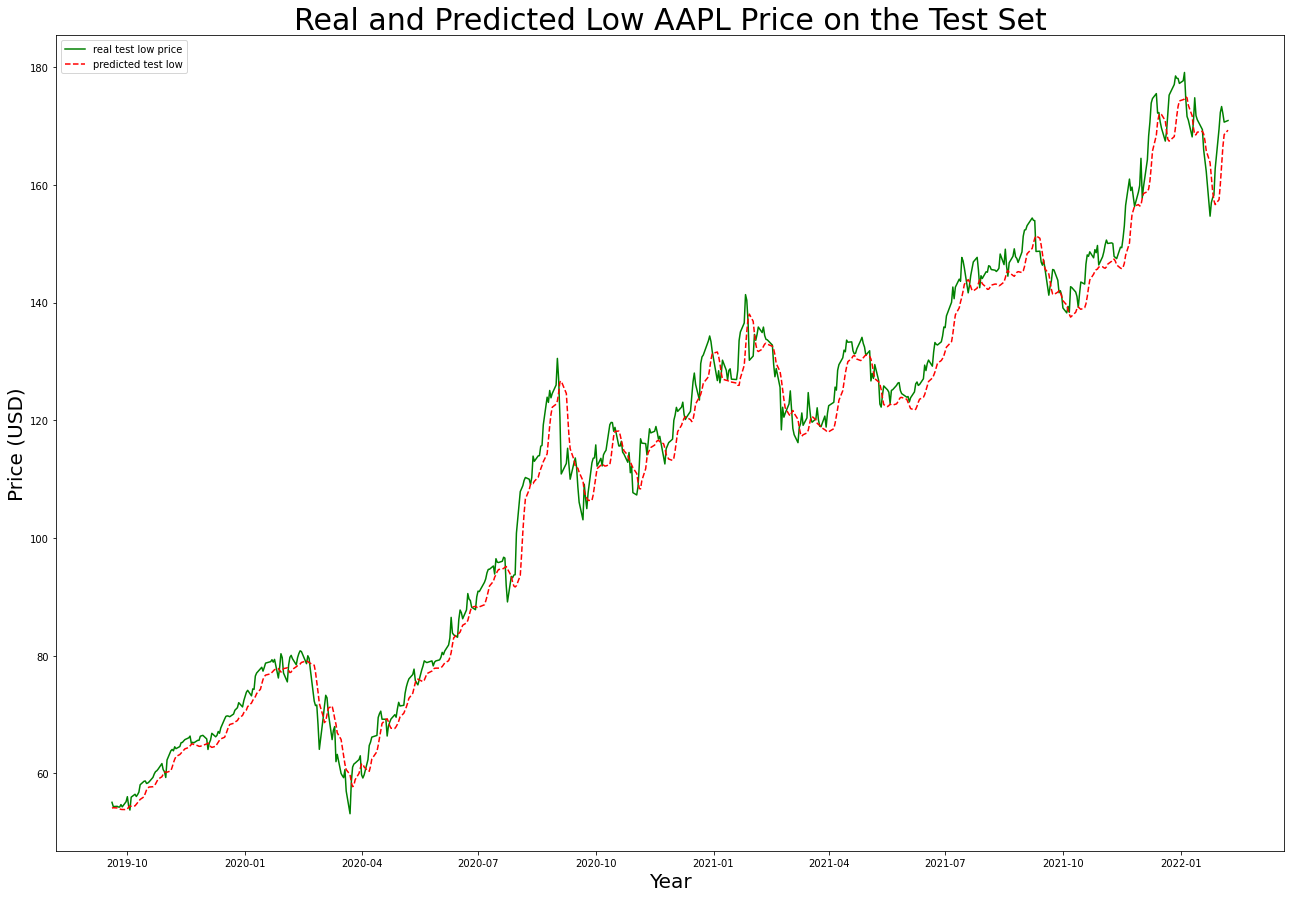

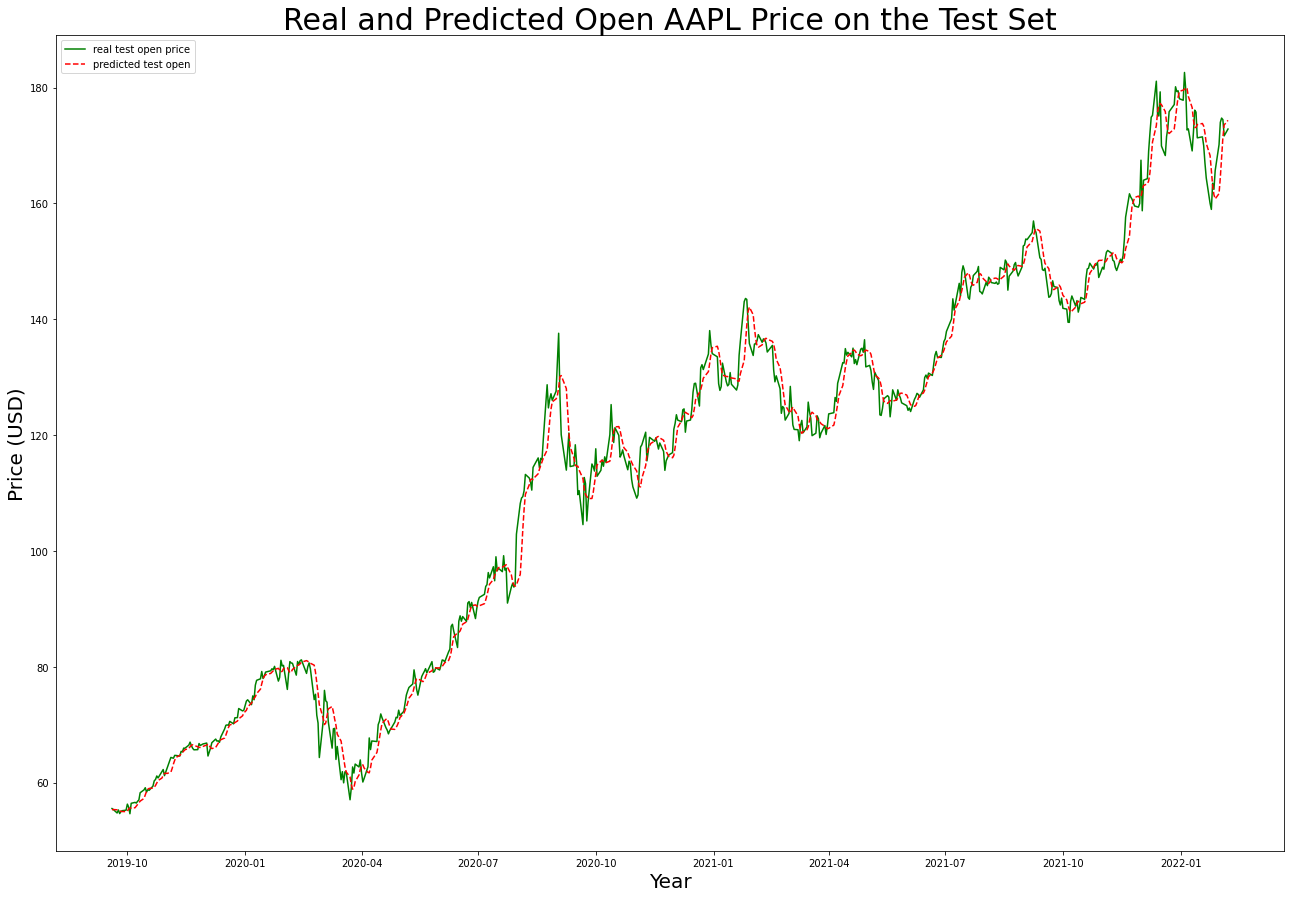

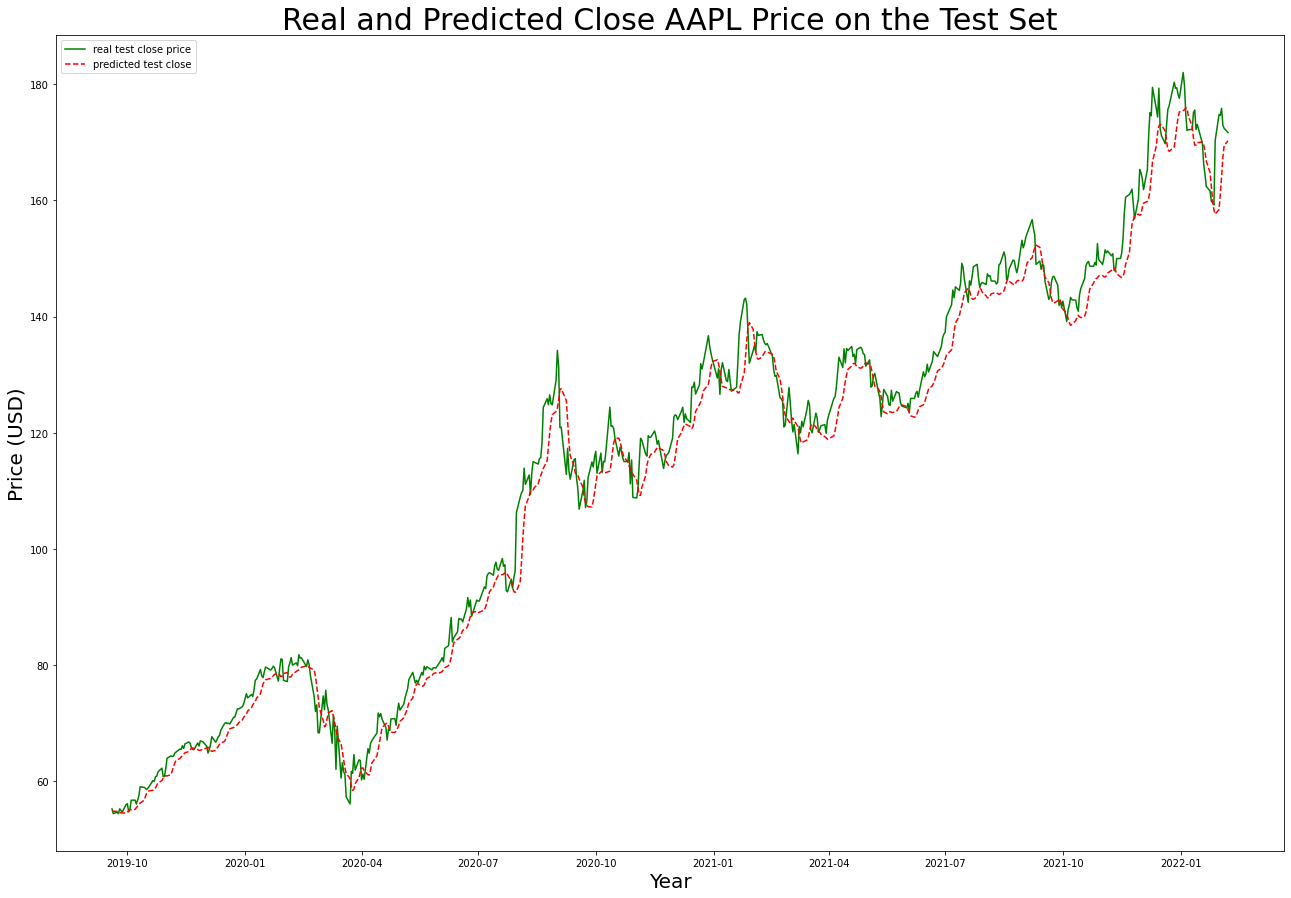

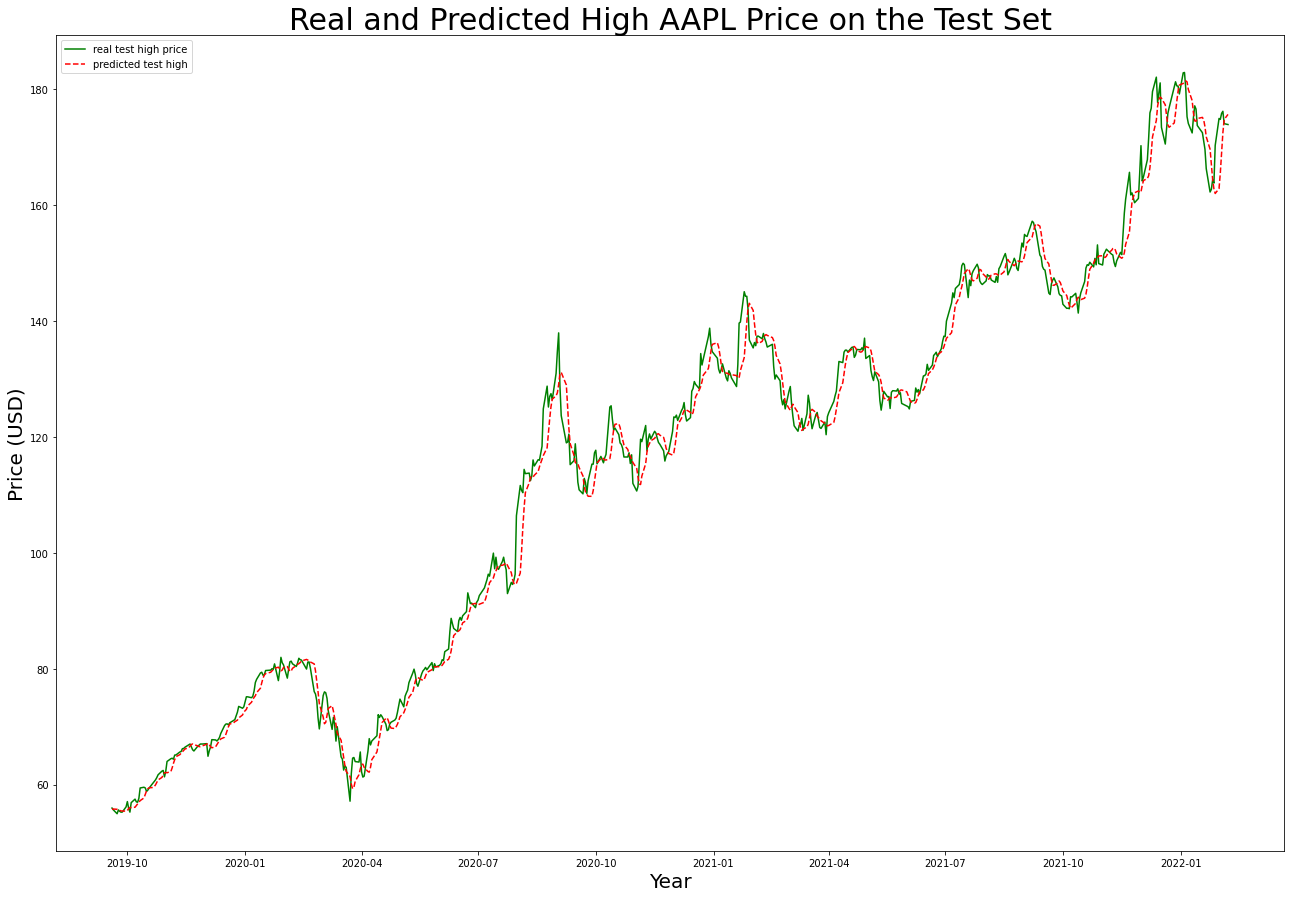

In [ ]:
y_test_low_aapl_pred, y_test_open_aapl_pred, y_test_close_aapl_pred, y_test_high_aapl_pred = model_aapl.predict(X_test_aapl)
testpreds_arr_aapl = np.hstack((y_test_low_aapl_pred, y_test_open_aapl_pred, y_test_close_aapl_pred, y_test_high_aapl_pred))
y_test_aapl_pred = y_normaliser_aapl.inverse_transform(testpreds_arr_aapl)

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_aapl, unscaled_y_test_aapl[:,low], label='real test low price', color='g')

# predicted values plotted
plt.plot(dates_test_aapl, y_test_aapl_pred[:,low], label='predicted test low', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low AAPL Price on the Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_aapl, unscaled_y_test_aapl[:,open], label='real test open price', color='g')

# predicted values plotted
plt.plot(dates_test_aapl, y_test_aapl_pred[:,open], label='predicted test open', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Open AAPL Price on the Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_aapl, unscaled_y_test_aapl[:,close], label='real test close price', color='g')

# predicted values plotted
plt.plot(dates_test_aapl, y_test_aapl_pred[:,close], label='predicted test close', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Close AAPL Price on the Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_aapl, unscaled_y_test_aapl[:,high], label='real test high price', color='g')

# predicted values plotted
plt.plot(dates_test_aapl, y_test_aapl_pred[:,high], label='predicted test high', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted High AAPL Price on the Test Set', fontsize=30)

plt.show()

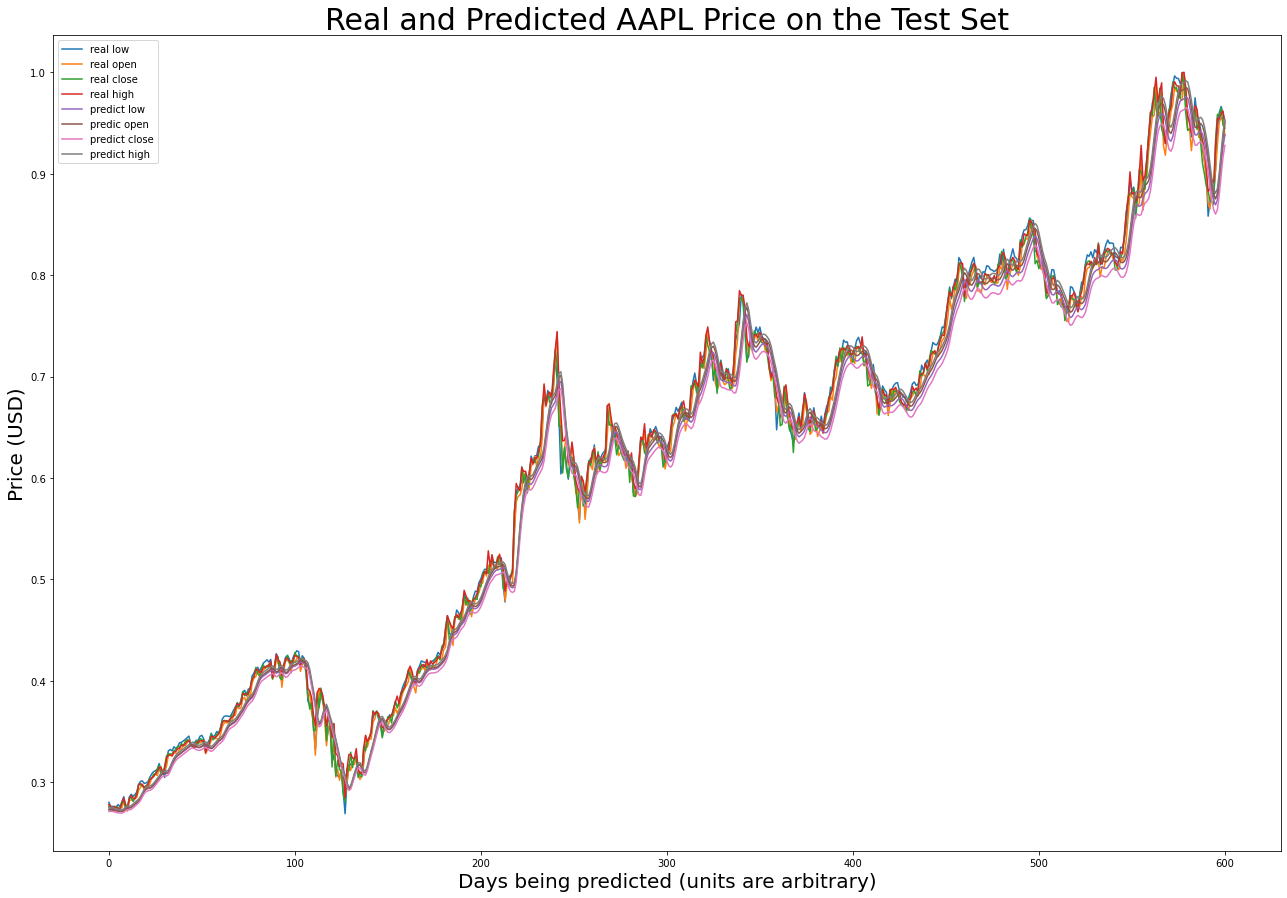

In [ ]:
# Debugging to fix predictions. More specifically, checking if the normalization is the issue.
# Normalization is NOT the issue

y_test_low_aapl_pred, y_test_open_aapl_pred, y_test_close_aapl_pred, y_test_high_aapl_pred = model_aapl.predict(X_test_aapl)
preds_arr_aapl = np.hstack((y_test_low_aapl_pred, y_test_open_aapl_pred, y_test_close_aapl_pred, y_test_high_aapl_pred))
y_test_aapl_pred = preds_arr_aapl

plt.gcf().set_size_inches(22, 15, forward=True)
currentFig.set_facecolor('white')

low = 0
open = 1
close = 2
high = -1

real = plt.plot(y_test_aapl[low:high], label='real')
pred = plt.plot(y_test_aapl_pred[low:high], label='predicted')

plt.legend(['real low','real open','real close','real high','predict low','predic open','predict close','predict high'])
plt.xlabel('Days being predicted (units are arbitrary)', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted AAPL Price on the Test Set', fontsize=30)

plt.show()

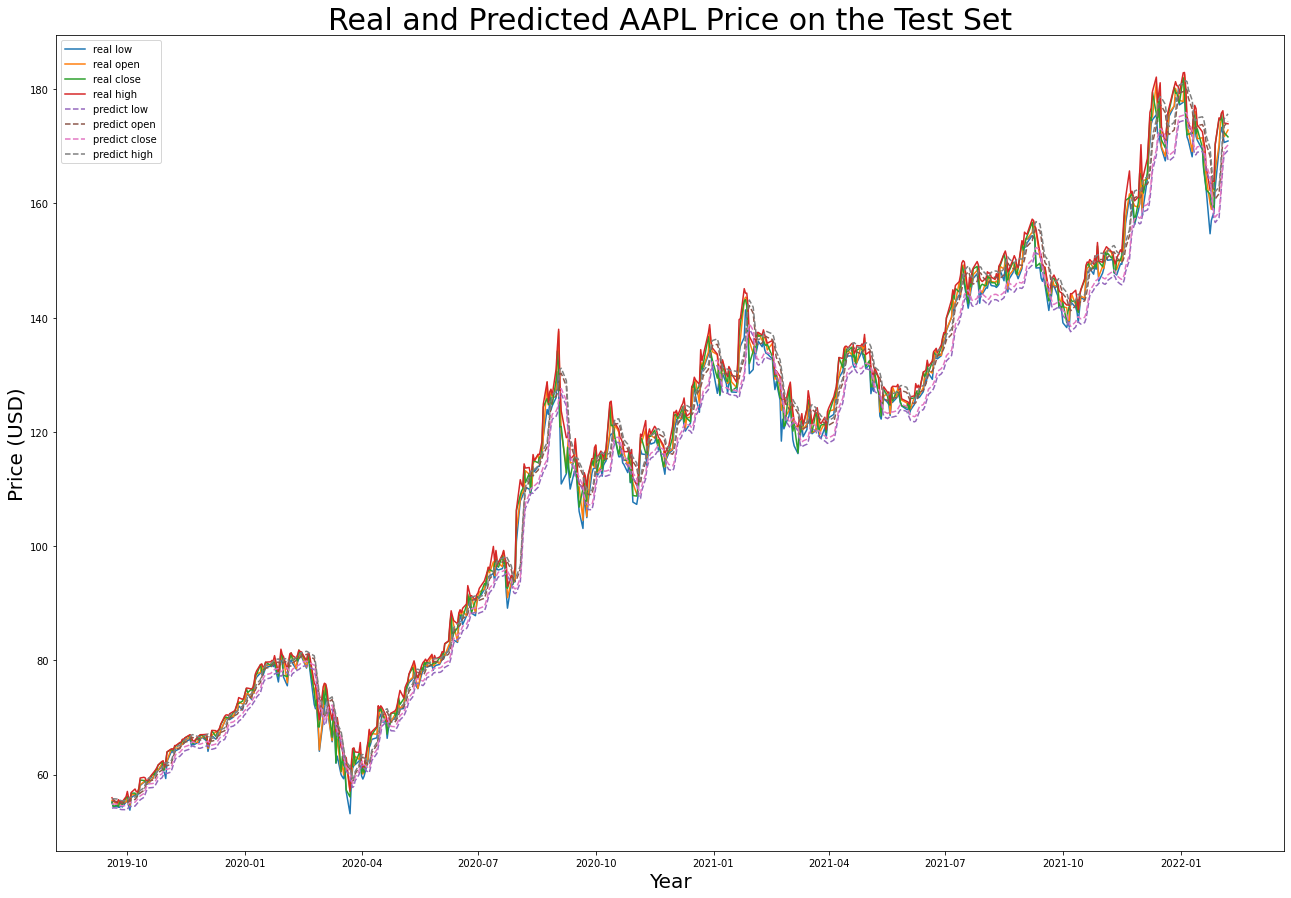

In [ ]:
plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_aapl, unscaled_y_test_aapl)

# predicted values plotted
plt.plot(dates_test_aapl, y_test_aapl_pred, linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend(['real low','real open','real close','real high','predict low','predict open','predict close','predict high'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted AAPL Price on the Test Set', fontsize=30)

plt.show()

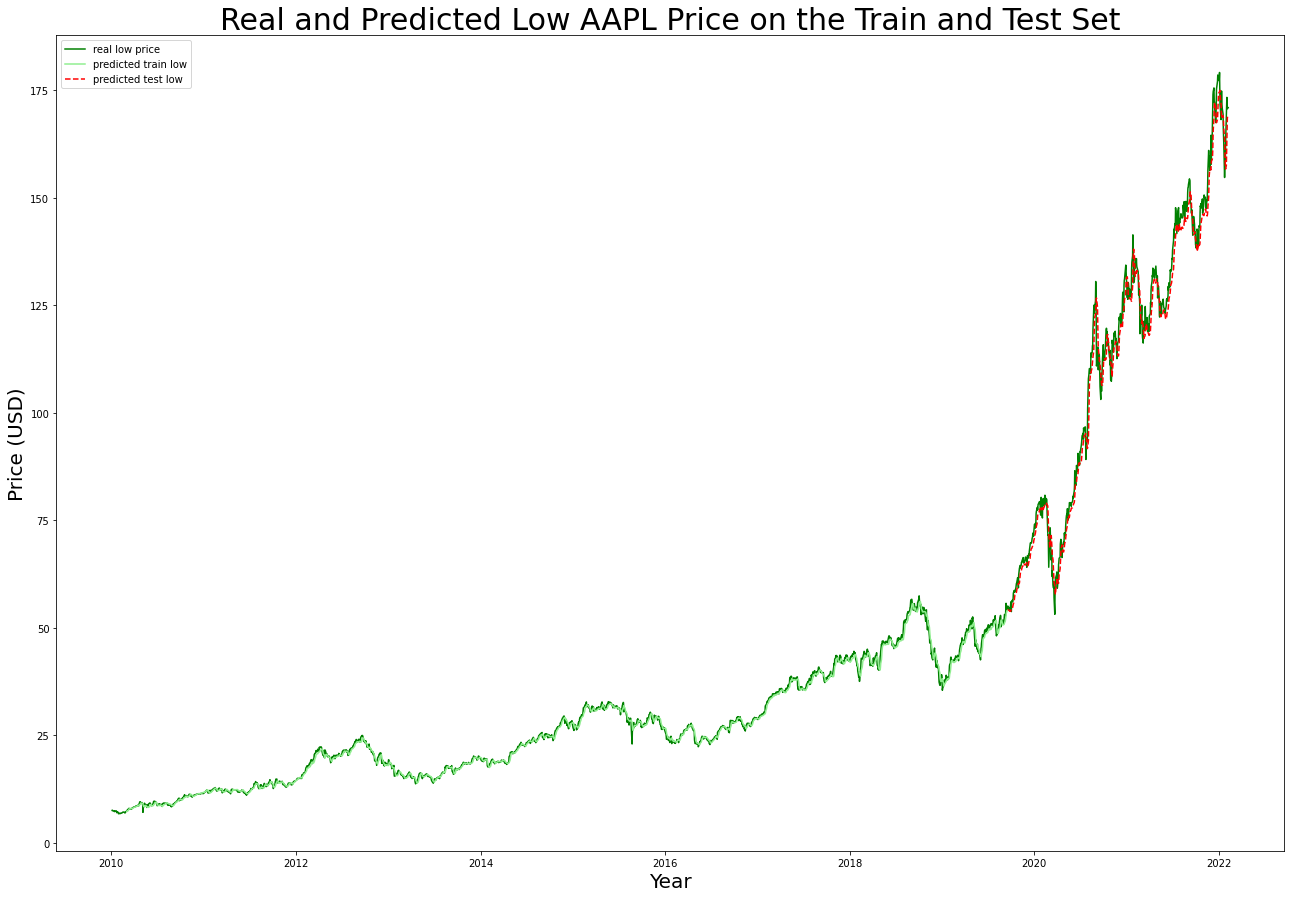

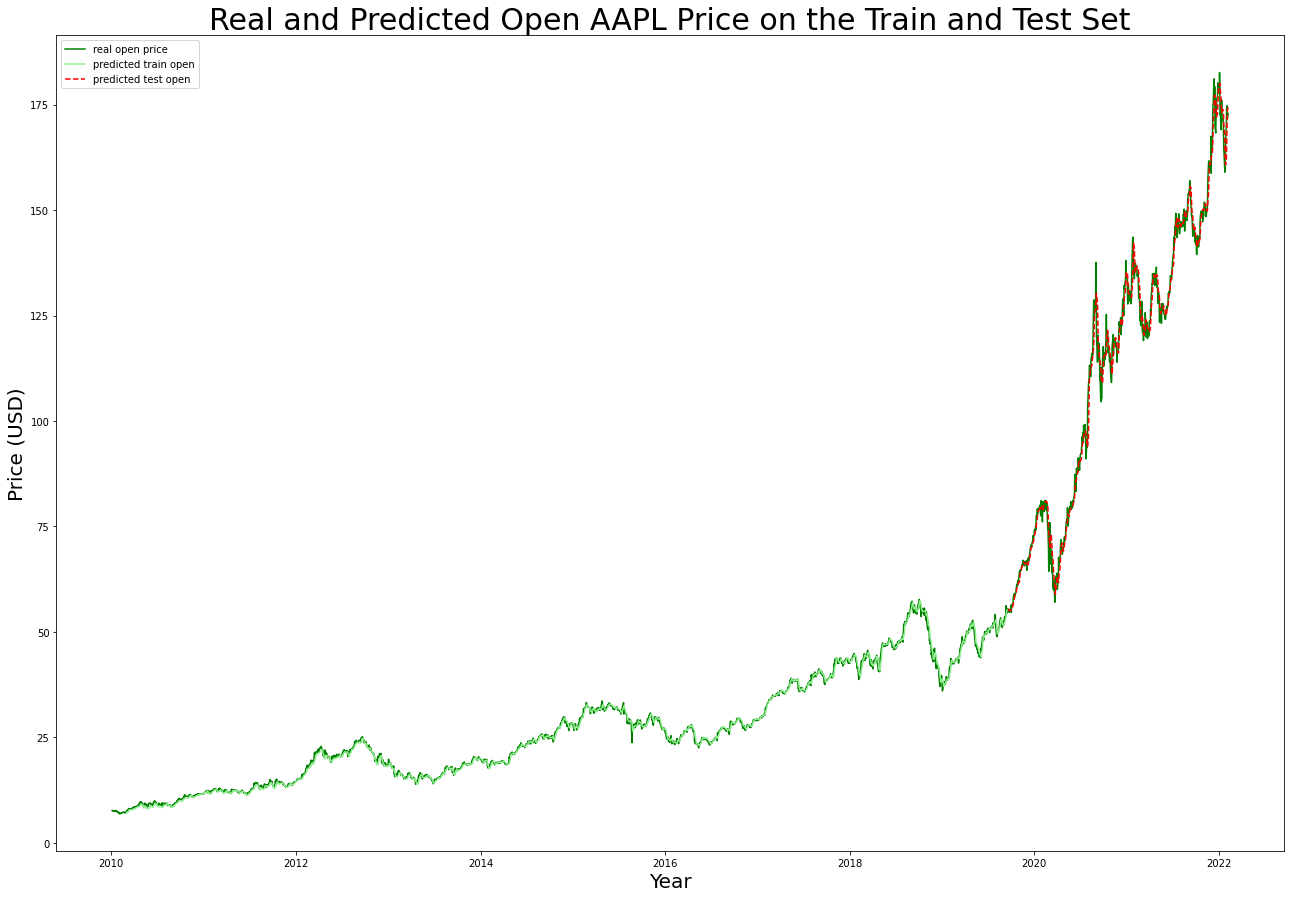

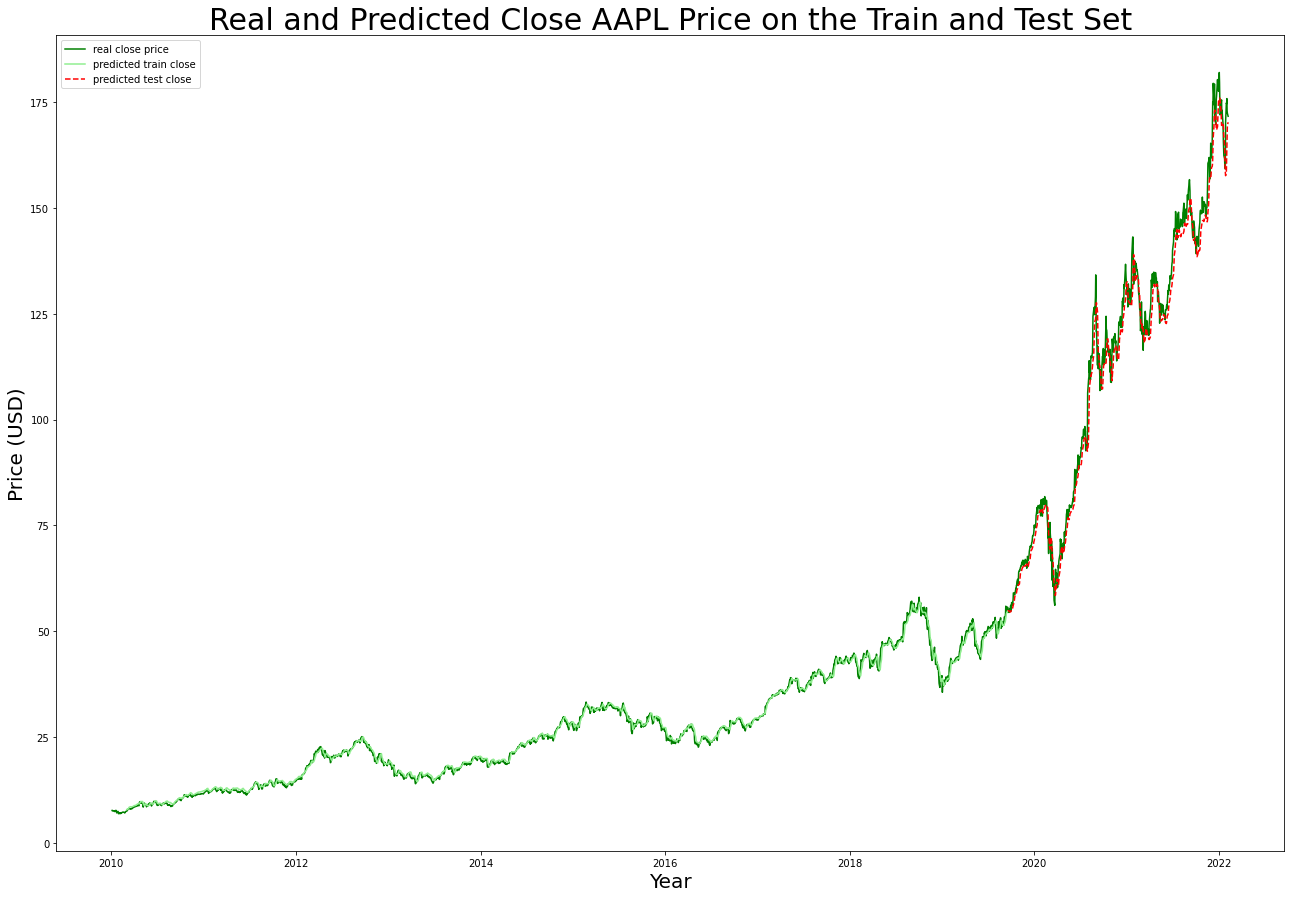

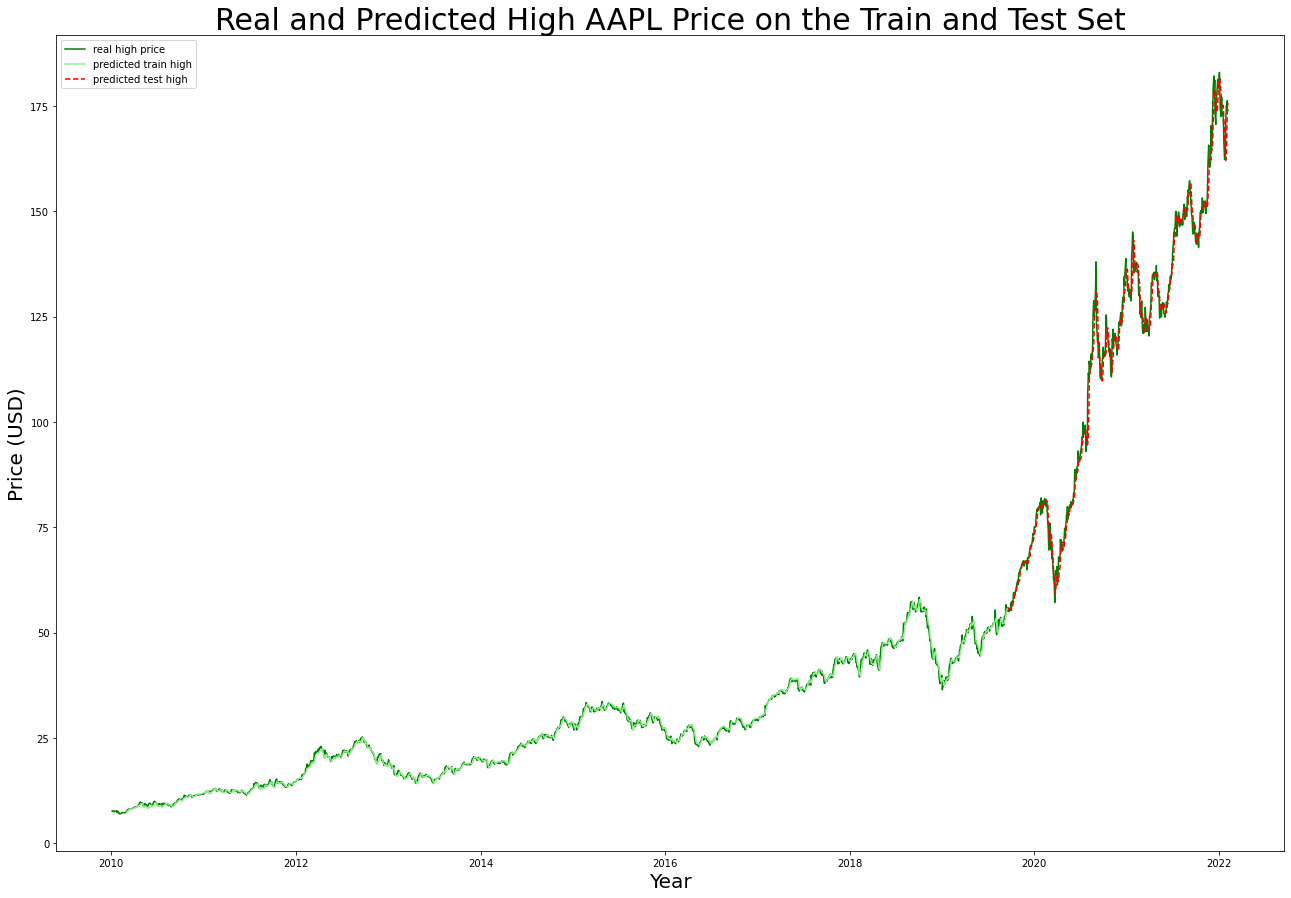

In [ ]:
y_test_low_aapl_pred, y_test_open_aapl_pred, y_test_close_aapl_pred, y_test_high_aapl_pred = model_aapl.predict(X_test_aapl)
testpreds_arr_aapl = np.hstack((y_test_low_aapl_pred, y_test_open_aapl_pred, y_test_close_aapl_pred, y_test_high_aapl_pred))
y_test_aapl_pred = y_normaliser_aapl.inverse_transform(testpreds_arr_aapl)

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_aapl['xlow'], label='real low price', color='g')

# predicted values plotted
plt.plot(dates_train_aapl, y_train_aapl_pred[:,low], label='predicted train low', color='lightgreen')
plt.plot(dates_test_aapl, y_test_aapl_pred[:,low], label='predicted test low', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low AAPL Price on the Train and Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_aapl['xopen'], label='real open price', color='g')

# predicted values plotted
plt.plot(dates_train_aapl, y_train_aapl_pred[:,open], label='predicted train open', color='lightgreen')
plt.plot(dates_test_aapl, y_test_aapl_pred[:,open], label='predicted test open', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Open AAPL Price on the Train and Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_aapl['xclose'], label='real close price', color='g')

# predicted values plotted
plt.plot(dates_train_aapl, y_train_aapl_pred[:,close], label='predicted train close', color='lightgreen')
plt.plot(dates_test_aapl, y_test_aapl_pred[:,close], label='predicted test close', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Close AAPL Price on the Train and Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_aapl['xhigh'], label='real high price', color='g')

# predicted values plotted
plt.plot(dates_train_aapl, y_train_aapl_pred[:,high], label='predicted train high', color='lightgreen')
plt.plot(dates_test_aapl, y_test_aapl_pred[:,high], label='predicted test high', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted High AAPL Price on the Train and Test Set', fontsize=30)

plt.show()

In [ ]:
#Evaluation MAE, RMSE, MAPE, RMSPE of High Price 
def evaluation(unscaled_y_aapl, y_aapl_pred, indexc, x_aapl):
    mae = mean_absolute_error(unscaled_y_aapl[:,indexc], y_aapl_pred[:,indexc])
    rmse = math.sqrt(mean_squared_error(unscaled_y_aapl[:,indexc], y_aapl_pred[:,indexc]))
    mape = np.mean(np.abs((unscaled_y_aapl[:,indexc] - y_aapl_pred[:,indexc])/unscaled_y_aapl[:,indexc]))*100

    prermspe = ((y_aapl_pred[:,indexc] - unscaled_y_aapl[:,indexc])/unscaled_y_aapl[:,indexc])
    rmspe_data = np.array([None]*len(x_aapl))
    for i in range(len(x_aapl)):
        rmspe_data[i] = math.pow(prermspe[i],2)
    rmspe = math.sqrt(np.mean(rmspe_data))*100
    print('MAE:', mae, '  \nRMSE:', rmse, '  \nMAPE:', mape, '  \nRMSPE:', rmspe)
    
# Low
# Calculating Train data prediction performance metrics
print('Evaluation Low Train Data Prediction')
evaluation(unscaled_y_train_aapl, y_train_aapl_pred, low, X_train_aapl)
# Calculating Test data prediction performance metrics
print('Evaluation Low Test Data Prediction')
evaluation(unscaled_y_test_aapl, y_test_aapl_pred, low, X_test_aapl)

# Open
# Calculating Train data prediction performance metrics
print('\nEvaluation Open Train Data Prediction')
evaluation(unscaled_y_train_aapl, y_train_aapl_pred, open, X_train_aapl)
# Calculating Test data prediction performance metrics
print('Evaluation Open Test Data Prediction')
evaluation(unscaled_y_test_aapl, y_test_aapl_pred, open, X_test_aapl)

# Close
# Calculating Train data prediction performance metrics
print('\nEvaluation Close Train Data Prediction')
evaluation(unscaled_y_train_aapl, y_train_aapl_pred, close, X_train_aapl)
# Calculating Test data prediction performance metrics
print('Evaluation Close Test Data Prediction')
evaluation(unscaled_y_test_aapl, y_test_aapl_pred, close, X_test_aapl)

# High
# Calculating Train data prediction performance metrics
print('\nEvaluation High Train Data Prediction')
evaluation(unscaled_y_train_aapl, y_train_aapl_pred, high, X_train_aapl)
# Calculating Test data prediction performance metrics
print('Evaluation High Test Data Prediction')
evaluation(unscaled_y_test_aapl, y_test_aapl_pred, high, X_test_aapl)

Evaluation Low Train Data Prediction
MAE: 0.5351175825528416   
RMSE: 0.7519148023743718   
MAPE: 2.0510045116940407   
RMSPE: 2.718375185821954
Evaluation Low Test Data Prediction
MAE: 2.9507430447296445   
RMSE: 3.7522705065204724   
MAPE: 2.7023507610500217   
RMSPE: 3.371969553239934

Evaluation Open Train Data Prediction
MAE: 0.46804205946835026   
RMSE: 0.6626726063618771   
MAPE: 1.9905765441546346   
RMSPE: 2.76624778603835
Evaluation Open Test Data Prediction
MAE: 2.156732831682478   
RMSE: 2.995079445776932   
MAPE: 1.9446109724526344   
RMSPE: 2.7196855848108457

Evaluation Close Train Data Prediction
MAE: 0.5545298184412292   
RMSE: 0.7592360796541598   
MAPE: 2.3007764111422575   
RMSPE: 2.997158206550666
Evaluation Close Test Data Prediction
MAE: 3.2477009351863417   
RMSE: 4.197950124836432   
MAPE: 2.865677263875928   
RMSPE: 3.556615983997978

Evaluation High Train Data Prediction
MAE: 0.4612368535678121   
RMSE: 0.6571809885836274   
MAPE: 1.8333922261742495   
RMSPE:

In [ ]:
df_real = pd.DataFrame(data=unscaled_y_test_aapl)
df_pred = pd.DataFrame(data=y_test_aapl_pred)
display(df_real, df_real[[3]], df_pred[[3]])

0           1           2           3
0     55.092499   55.502499   55.240002   55.939999
1     54.367500   55.345001   54.432499   55.639999
2     54.412498   54.737499   54.680000   54.959999
3     54.297501   55.257500   54.419998   55.622501
4     54.285000   54.637501   55.257500   55.375000
..          ...         ...         ...         ...
597  172.309998  174.009995  174.610001  174.839996
598  173.330002  174.750000  175.839996  175.880005
599  172.119995  174.479996  172.899994  176.240005
600  170.679993  171.679993  172.389999  174.100006
601  170.949997  172.860001  171.660004  173.949997

[602 rows x 4 columns]

3
0     55.939999
1     55.639999
2     54.959999
3     55.622501
4     55.375000
..          ...
597  174.839996
598  175.880005
599  176.240005
600  174.100006
601  173.949997

[602 rows x 1 columns]

3
0     55.723820
1     55.772419
2     55.726768
3     55.635948
4     55.525360
..          ...
597  165.604187
598  169.170090
599  172.528885
600  174.818100
601  175.698822

[602 rows x 1 columns]

In [ ]:
display(df_real, df_real[[0]], df_pred[[0]])

0           1           2           3
0     55.092499   55.502499   55.240002   55.939999
1     54.367500   55.345001   54.432499   55.639999
2     54.412498   54.737499   54.680000   54.959999
3     54.297501   55.257500   54.419998   55.622501
4     54.285000   54.637501   55.257500   55.375000
..          ...         ...         ...         ...
597  172.309998  174.009995  174.610001  174.839996
598  173.330002  174.750000  175.839996  175.880005
599  172.119995  174.479996  172.899994  176.240005
600  170.679993  171.679993  172.389999  174.100006
601  170.949997  172.860001  171.660004  173.949997

[602 rows x 4 columns]

0
0     55.092499
1     54.367500
2     54.412498
3     54.297501
4     54.285000
..          ...
597  172.309998
598  173.330002
599  172.119995
600  170.679993
601  170.949997

[602 rows x 1 columns]

0
0     54.113972
1     54.173733
2     54.137356
3     54.056942
4     53.957115
..          ...
597  160.086868
598  163.417267
599  166.501938
600  168.559982
601  169.311234

[602 rows x 1 columns]

In [ ]:
unscaled_y_test_aapl[:,high]

array([ 55.93999863,  55.63999939,  54.95999908,  55.62250137,
        55.375     ,  55.23500061,  55.24000168,  56.14500046,
        57.05500031,  55.89500046,  55.24000168,  56.87250137,
        57.48249817,  57.01499939,  56.94749832,  57.61000061,
        59.40999985,  59.53250122,  59.41249847,  58.81000137,
        59.03749847,  59.39500046,  60.24750137,  60.54999924,
        60.81000137,  61.20000076,  61.68249893,  62.3125    ,
        62.4375    ,  61.32500076,  62.29249954,  63.98249817,
        64.46250153,  64.54750061,  64.37249756,  65.08750153,
        65.11000061,  65.61750031,  65.69750214,  66.19499969,
        66.22000122,  66.44499969,  66.85749817,  67.        ,
        66.51999664,  66.00250244,  65.79499817,  66.61000061,
        66.79000092,  66.99500275,  67.        ,  67.0625    ,
        64.88249969,  65.82749939,  66.47250366,  67.75      ,
        67.69999695,  67.51750183,  67.77500153,  68.13999939,
        68.82499695,  70.19750214,  70.44249725,  70.47

In [ ]:
y_train_close_aapl_pred

array([[0.00184847],
       [0.00244344],
       [0.00290935],
       ...,
       [0.26966277],
       [0.27078837],
       [0.27103248]], dtype=float32)

In [ ]:
y_test_aapl_pred[:,high]

array([ 55.72382 ,  55.77242 ,  55.72677 ,  55.63595 ,  55.52536 ,
        55.449448,  55.428375,  55.411392,  55.52464 ,  55.83647 ,
        56.04565 ,  56.011486,  56.083412,  56.36563 ,  56.67519 ,
        56.954014,  57.225056,  57.685314,  58.31386 ,  58.916008,
        59.280693,  59.43744 ,  59.48746 ,  59.64103 ,  59.942505,
        60.354507,  60.799503,  61.22444 ,  61.68204 ,  62.007145,
        62.081757,  62.034092,  62.254635,  62.876812,  63.655758,
        64.30823 ,  64.81112 ,  65.16138 ,  65.417816,  65.65314 ,
        65.89823 ,  66.138336,  66.374664,  66.6397  ,  66.91442 ,
        67.007324,  66.8957  ,  66.68164 ,  66.54951 ,  66.547356,
        66.71135 ,  66.957214,  67.11706 ,  66.87934 ,  66.52878 ,
        66.345825,  66.53155 ,  66.897804,  67.27863 ,  67.62738 ,
        67.87593 ,  68.16481 ,  68.68765 ,  69.36659 ,  69.99628 ,
        70.44299 ,  70.65052 ,  70.85291 ,  71.12102 ,  71.49752 ,
        72.01307 ,  72.51018 ,  72.974884,  73.577705,  74.207

In [ ]:
model_aapl.get_weights()

[array([[-3.7958637e-02, -8.7555088e-03, -2.8593691e-02, ...,
          5.8906386e-03,  1.0488633e-04, -3.2008670e-02],
        [-1.1078904e-01, -4.5220204e-02, -8.0878302e-02, ...,
         -1.5873501e-02,  6.3175276e-02, -6.7877881e-02],
        [-5.0717816e-02,  1.1592542e-02, -6.3701048e-02, ...,
         -1.8015341e-03, -2.4429731e-02, -9.0704426e-02],
        [-1.3997155e-01, -5.0616302e-03,  5.9990332e-02, ...,
          1.3247752e-02, -9.7837418e-02,  6.8765096e-02],
        [-7.3255301e-02, -1.1482194e-01, -1.6244296e-02, ...,
          7.5113624e-02,  2.0316653e-02, -6.5269113e-02]], dtype=float32),
 array([[-0.00517671,  0.05611513,  0.0365086 , ..., -0.04526001,
         -0.02928981, -0.00530556],
        [-0.0234207 , -0.05979041,  0.03112808, ...,  0.04014174,
         -0.03807556,  0.00144983],
        [-0.0255031 ,  0.03890643, -0.01872872, ...,  0.00937425,
          0.03319742,  0.01666936],
        ...,
        [-0.01400325, -0.03337261,  0.04067066, ..., -0.09340768

In [ ]:
model_aapl.save('modelaapl.h5')

# **Predict for 1 Day AAPL**

In [ ]:
data_pred_aapl = normalizedData_aapl[num_data_aapl-200:,:5].reshape(5,40,5)
data_pred_aapl

array([[[0.7356164 , 0.72803767, 0.73000454, 0.72786175, 0.01407887],
        [0.73880805, 0.72906176, 0.72812044, 0.7298511 , 0.01359556],
        [0.73283099, 0.72507906, 0.72349587, 0.72763444, 0.0362827 ],
        [0.72917509, 0.73736859, 0.7229249 , 0.73928615, 0.05983757],
        [0.72116704, 0.71068441, 0.71139206, 0.71933611, 0.03741281],
        [0.72557727, 0.71216367, 0.71755809, 0.72223488, 0.0185517 ],
        [0.69580797, 0.70732757, 0.69078124, 0.70757078, 0.05248087],
        [0.70317778, 0.69600526, 0.69220862, 0.70165963, 0.02337008],
        [0.69830325, 0.68855192, 0.70157196, 0.69768102, 0.02017845],
        [0.71194024, 0.70539314, 0.70425537, 0.70626346, 0.02063769],
        [0.6964463 , 0.69720011, 0.68507188, 0.69648739, 0.0255822 ],
        [0.67300227, 0.66357463, 0.67970511, 0.67790153, 0.04627331],
        [0.66998474, 0.66300568, 0.66177769, 0.66863702, 0.03868064],
        [0.68164874, 0.66971939, 0.6743383 , 0.67721951, 0.03525074],
        [0.69087545,

In [ ]:
# x_input_aapl = data_used_aapl[train_size_aapl+test_size_aapl-1:, :, :]
ylow_aapl,yopen_aapl,yclose_aapl,yhigh_aapl = model_aapl.predict(data_pred_aapl[[4]])
yhat_aapl = ylow_aapl,yopen_aapl,yclose_aapl,yhigh_aapl
nextday_pred_aapl = np.hstack((ylow_aapl,yopen_aapl,yclose_aapl,yhigh_aapl))
nextday_pred_aapl = y_normaliser_aapl.inverse_transform(nextday_pred_aapl)
nextday_pred_aapl

array([[169.20473, 174.21242, 170.16441, 175.60861]], dtype=float32)

# **APC.F**

In [ ]:
# Extract price
data_f = stock_f.filter(['xlow','xopen','xclose','xhigh','Volume'])
dataset_f = data_f.values

In [ ]:
# Preprocess the data
normalizer = MinMaxScaler(feature_range=(0,1)) 
normalizedData_f = normalizer.fit_transform(dataset_f) # values between 0,1
print(normalizedData_f)

[[0.00435207 0.00386831 0.00453674 0.00395143 0.10458693]
 [0.00496838 0.00445421 0.00487231 0.00442506 0.14356463]
 [0.00427795 0.00464903 0.00416955 0.00420525 0.07540247]
 ...
 [0.94842459 0.94428041 0.93032874 0.96177592 0.00374172]
 [0.94782209 0.95604265 0.94587898 0.9532425  0.00658165]
 [0.95194887 0.94288628 0.93569625 0.94471974 0.00307409]]


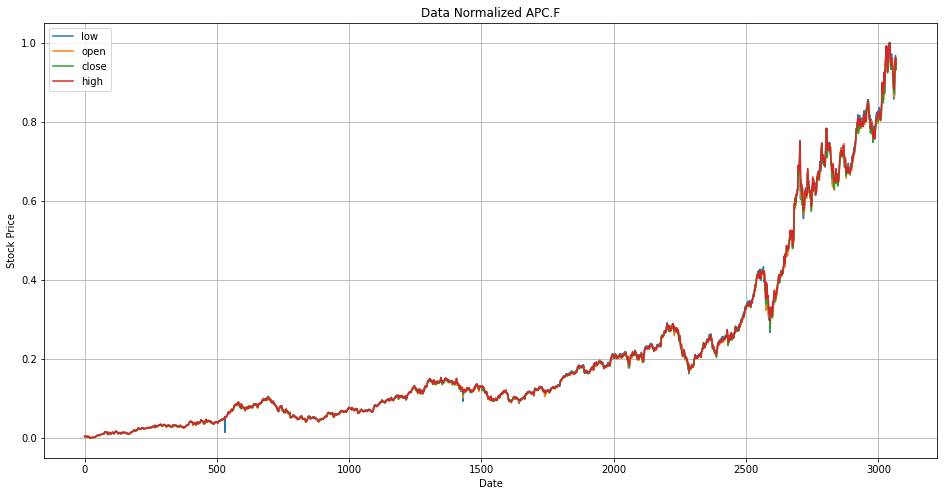

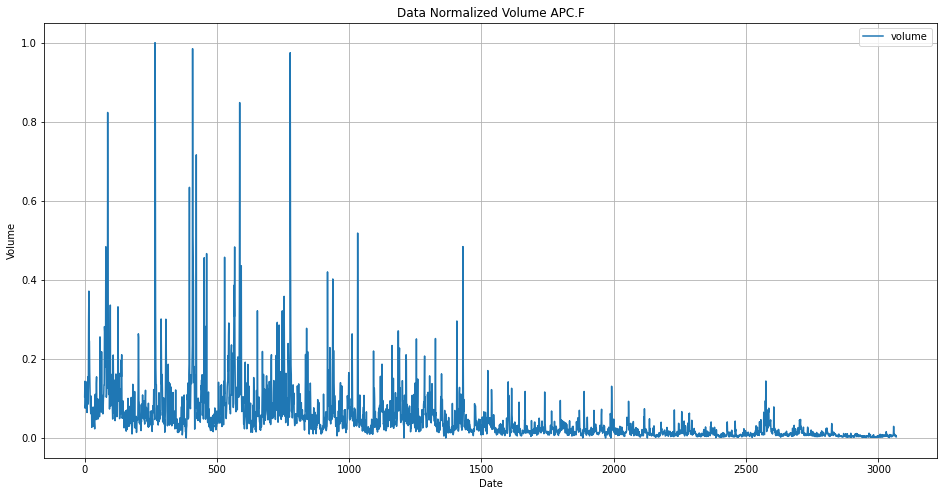

In [ ]:
# Visualization data normalized

# APC.F
plt.figure(figsize=(16,8))
plt.title('Data Normalized APC.F')
plt.plot(normalizedData_f[:,:4])

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['low','open','close','high'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

plt.figure(figsize=(16,8))
plt.title('Data Normalized Volume APC.F')
plt.plot(normalizedData_f[:,4:])

plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(['volume'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

In [ ]:
# Storing the number of data points in the array
num_data_f = len(normalizedData_f)
num_days_used = 40
data_used_f = np.array([normalizedData_f[i : i + num_days_used].copy() for i in range(num_data_f - num_days_used)])

# Creating a numpy array that contains the value(s) to predict
# Currently, trying to fit the 4 outputs
data_to_predict_f = np.array(normalizedData_f[(num_days_used):, :4])

# Creating a dates array for the dates that were used by data_used
dates_used_f = stock_f.index[num_days_used:num_data_f]

# Storing the scaler object for prediction later
y_normaliser_f = MinMaxScaler()
y_normaliser_f.fit(stock_f[['xlow', 'xopen', 'xclose', 'xhigh']].to_numpy()[num_days_used:])

display(normalizedData_f.shape, data_used_f.shape,data_to_predict_f.shape, dates_used_f.shape)

(3069, 5)

(3029, 40, 5)

(3029, 4)

(3029,)

In [ ]:
train_split = 0.8
data_size_f = data_used_f.shape[0]
num_features_f = data_used_f.shape[2]
train_size_f = int(data_size_f * train_split)
test_size_f = data_size_f - train_size_f

# Splitting the dataset up into train and test sets
X_train_f = data_used_f[0:train_size_f, :, :]
y_train_f = data_to_predict_f[0:train_size_f, :]
dates_train_f = dates_used_f[0:train_size_f]
X_test_f = data_used_f[train_size_f:, :, :]
y_test_f = data_to_predict_f[train_size_f:, :]
dates_test_f = dates_used_f[train_size_f:]

unscaled_y_train_f = stock_f[['xlow', 'xopen', 'xclose', 'xhigh']].to_numpy()[(num_days_used):][0:train_size_f, :]
unscaled_y_test_f = stock_f[['xlow', 'xopen', 'xclose', 'xhigh']].to_numpy()[(num_days_used):][train_size_f:, :]

display("X_train shape:", X_train_f.shape, "y_train shape:", y_train_f.shape, 
        "X_test shape:", X_test_f.shape, "y_test shape:", y_test_f.shape,
        "unscaled_y_train shape:", unscaled_y_train_f.shape, "unscaled_y_test shape:", unscaled_y_test_f.shape)

'X_train shape:'

(2423, 40, 5)

'y_train shape:'

(2423, 4)

'X_test shape:'

(606, 40, 5)

'y_test shape:'

(606, 4)

'unscaled_y_train shape:'

(2423, 4)

'unscaled_y_test shape:'

(606, 4)

In [ ]:
# Creating the input layer, whose shape is (num_days_used, num_features) because it is
# the open, high, low, close, volume for the past num_days_used days 
input = Input(shape=(num_days_used, num_features_f), name = 'input')

x = GRU(200, return_sequences=True, name='gru_1')(input)
x = Dropout(0.5)(x)
x = Dense(4, name='dense_2')(x)

# Branching out
output1 = GRU(200, return_sequences=True, name='low_0')(x)
output1 = Dropout(0.5)(output1)
output1 = GRU(200, name='low_1')(output1)
output1 = Dropout(0.5)(output1)
output1 = Dense(1, name='low_final')(output1)

output2 = GRU(200, return_sequences=True, name='open_0')(x)
output2 = Dropout(0.5)(output2)
output2 = GRU(200, name='open_1')(output2)
output2 = Dropout(0.5)(output2)
output2 = Dense(1, name='open_final')(output2)

output3 = GRU(200, return_sequences=True, name='close_0')(x)
output3 = Dropout(0.5)(output3)
output3 = GRU(200, name='clsoe_1')(output3)
output3 = Dropout(0.5)(output3)
output3 = Dense(1, name='close_final')(output3)

output4 = GRU(200, return_sequences=True, name='high_0')(x)
output4 = Dropout(0.5)(output4)
output4 = GRU(200, name='high_1')(output4)
output4 = Dropout(0.5)(output4)
output4 = Dense(1, name='high_final')(output4)

model_f = Model(inputs = input, outputs = [output1, output2, output3, output4])

# Choosing Adam as the optimizer
# Adam is an optimizer of hyperparameters
adam = Adam(learning_rate=0.001)

# model.compile is where you define the type of optimizer, loss, etc. 
# that you want to use. Here, we use Adam and MAE
model_f.compile(optimizer=adam, loss='mae')
model_f.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 40, 5)]      0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 40, 200)      124200      input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 40, 200)      0           gru_1[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 40, 4)        804         dropout[0][0]                    
______________________________________________________________________________________________

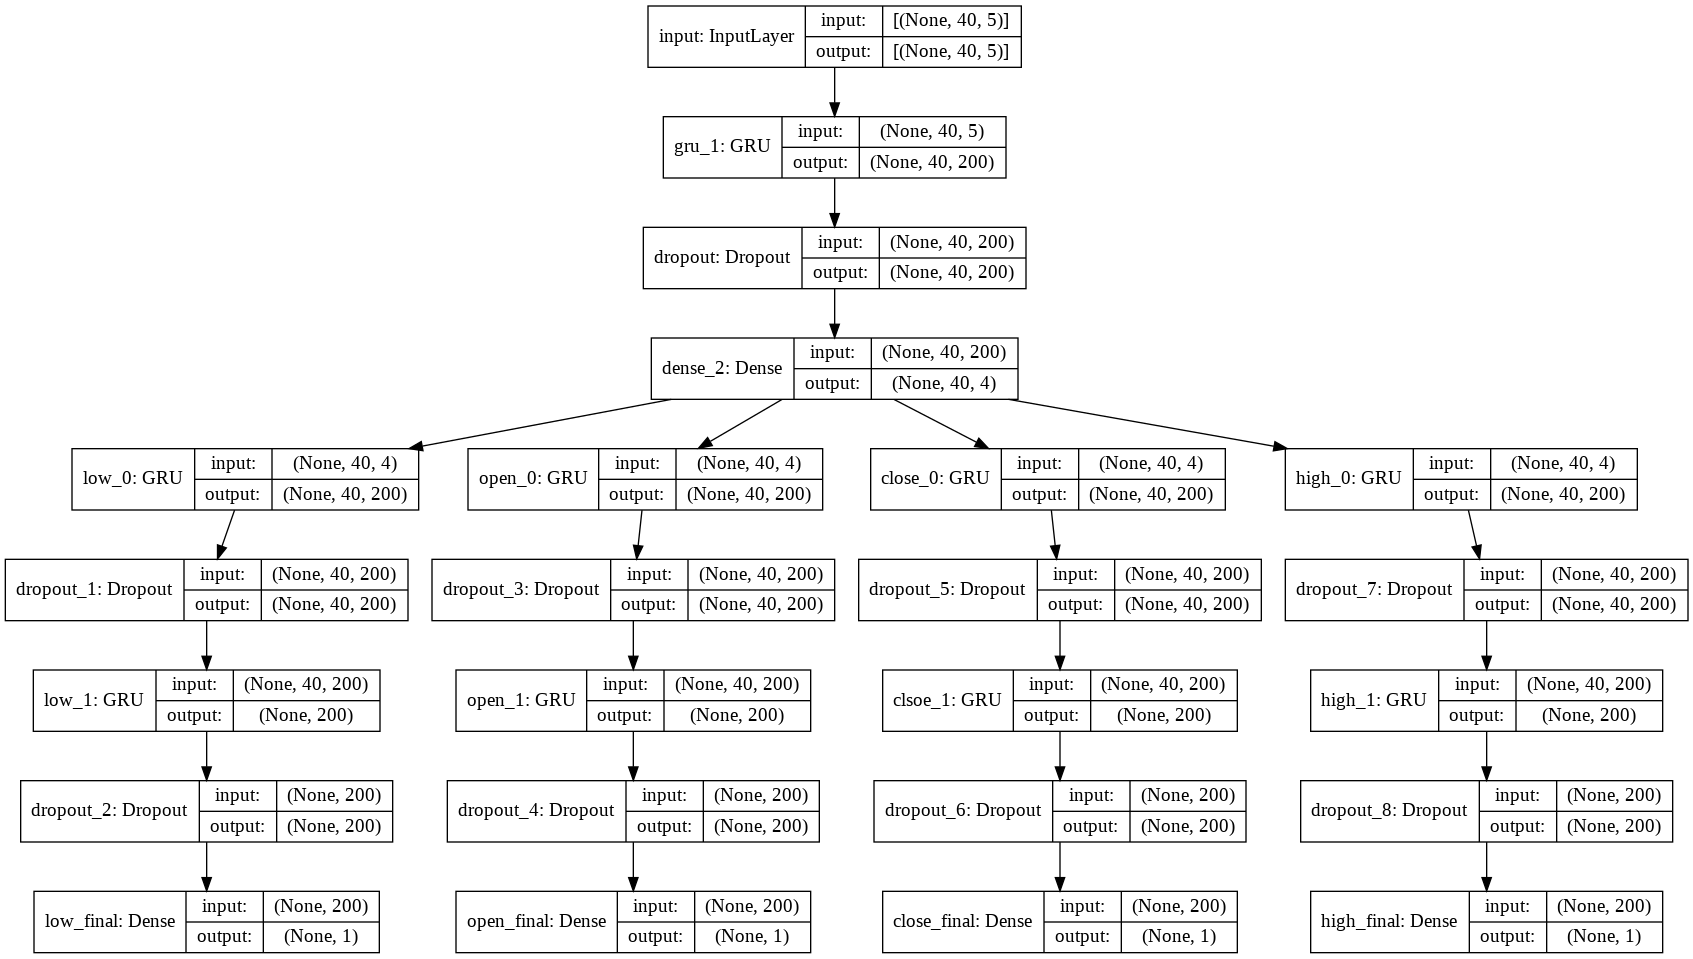

In [ ]:
# Displaying the structure of the final model
plot_model(model_f, show_shapes=True)

In [ ]:
history = model_f.fit(x=X_train_f, y=y_train_f, batch_size=32, epochs=20, validation_split=0.2)
evaluation = model_f.evaluate(X_test_f, y_test_f)
print(evaluation)

Epoch 1/20
61/61 [==============================] - 90s 954ms/step - loss: 0.0033 - low_final_loss: 8.5431e-04 - open_final_loss: 8.1745e-04 - close_final_loss: 8.2619e-04 - high_final_loss: 7.9187e-04 - val_loss: 3.8643e-04 - val_low_final_loss: 7.7130e-05 - val_open_final_loss: 1.2483e-04 - val_close_final_loss: 7.9962e-05 - val_high_final_loss: 1.0451e-04
Epoch 2/20
61/61 [==============================] - 51s 838ms/step - loss: 5.8360e-04 - low_final_loss: 1.3179e-04 - open_final_loss: 1.5660e-04 - close_final_loss: 1.5388e-04 - high_final_loss: 1.4133e-04 - val_loss: 5.6541e-04 - val_low_final_loss: 1.0382e-04 - val_open_final_loss: 1.0767e-04 - val_close_final_loss: 2.5825e-04 - val_high_final_loss: 9.5669e-05
Epoch 3/20
61/61 [==============================] - 50s 828ms/step - loss: 4.8916e-04 - low_final_loss: 1.1864e-04 - open_final_loss: 1.2491e-04 - close_final_loss: 1.2050e-04 - high_final_loss: 1.2511e-04 - val_loss: 5.8141e-04 - val_low_final_loss: 1.0709e-04 - val_open_f

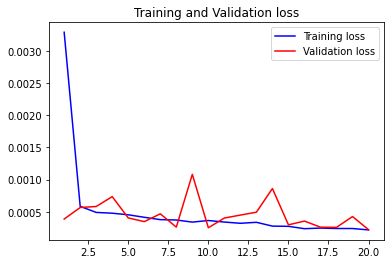

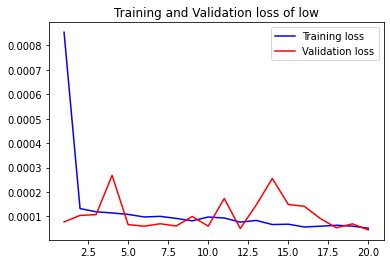

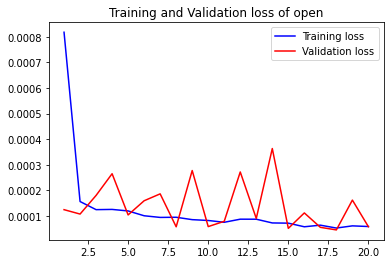

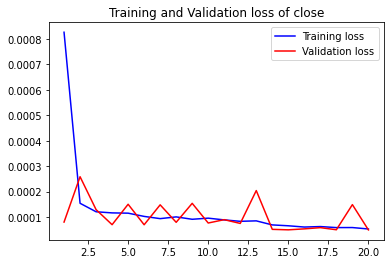

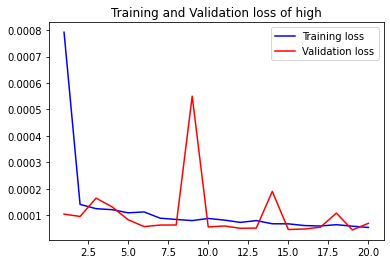

In [ ]:
loss_f = history.history['loss']
val_loss_f = history.history['val_loss']
low_loss_f = history.history['low_final_loss']
val_low_loss_f = history.history['val_low_final_loss']
open_loss_f = history.history['open_final_loss']
val_open_loss_f = history.history['val_open_final_loss']
close_loss_f = history.history['close_final_loss']
val_close_loss_f = history.history['val_close_final_loss']
high_loss_f = history.history['high_final_loss']
val_high_loss_f = history.history['val_high_final_loss']
epochs_f = range(1, len(loss_f) + 1)
plt.figure()

#Train and validation loss
plt.plot(epochs_f, loss_f, 'b', label='Training loss')
plt.plot(epochs_f, val_loss_f, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

plt.plot(epochs_f, low_loss_f, 'b', label='Training loss')
plt.plot(epochs_f, val_low_loss_f, 'r', label='Validation loss')
plt.title('Training and Validation loss of low')
plt.legend()
plt.show()

plt.plot(epochs_f, open_loss_f, 'b', label='Training loss')
plt.plot(epochs_f, val_open_loss_f, 'r', label='Validation loss')
plt.title('Training and Validation loss of open')
plt.legend()
plt.show()

plt.plot(epochs_f, close_loss_f, 'b', label='Training loss')
plt.plot(epochs_f, val_close_loss_f, 'r', label='Validation loss')
plt.title('Training and Validation loss of close')
plt.legend()
plt.show()

plt.plot(epochs_f, high_loss_f, 'b', label='Training loss')
plt.plot(epochs_f, val_high_loss_f, 'r', label='Validation loss')
plt.title('Training and Validation loss of high')
plt.legend()
plt.show()

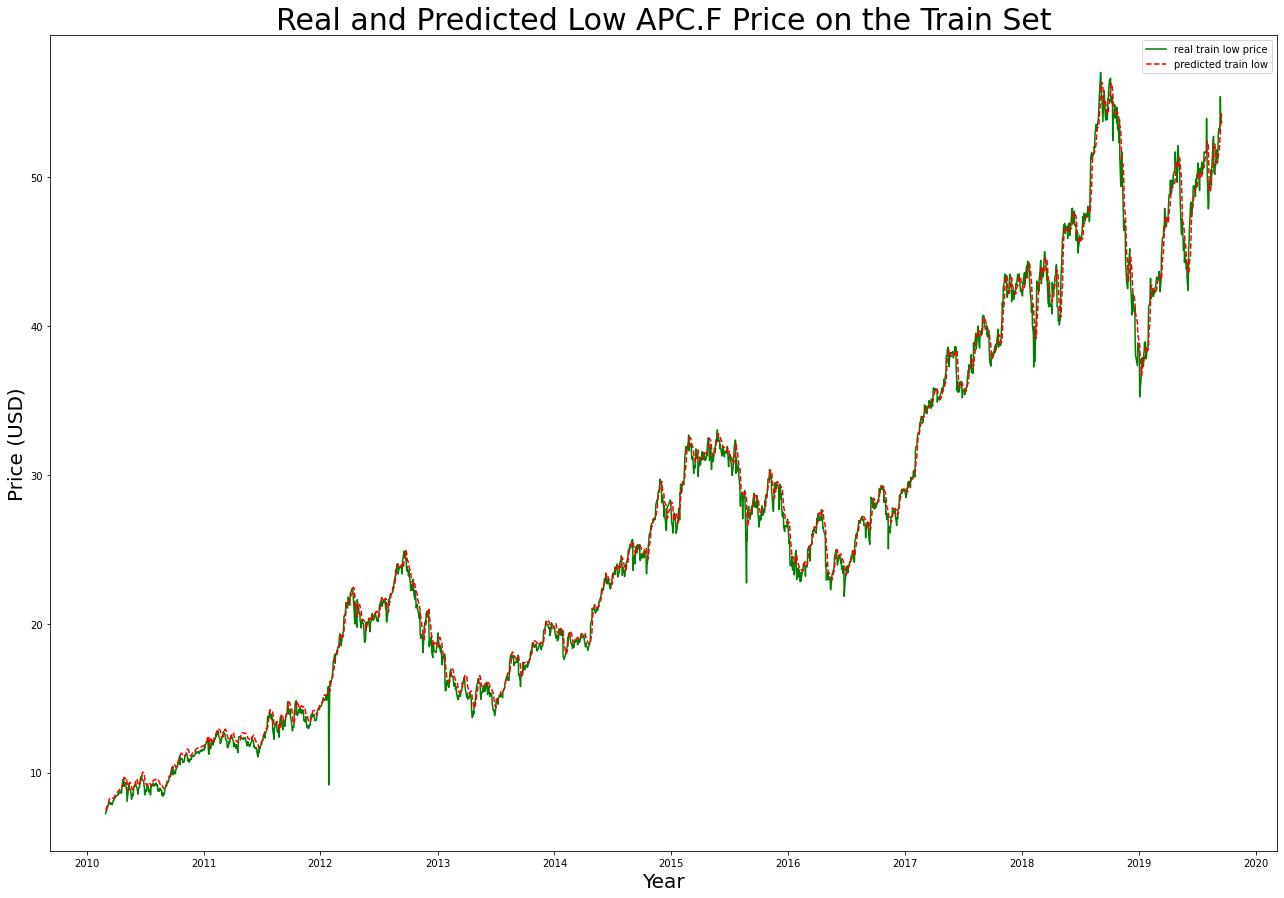

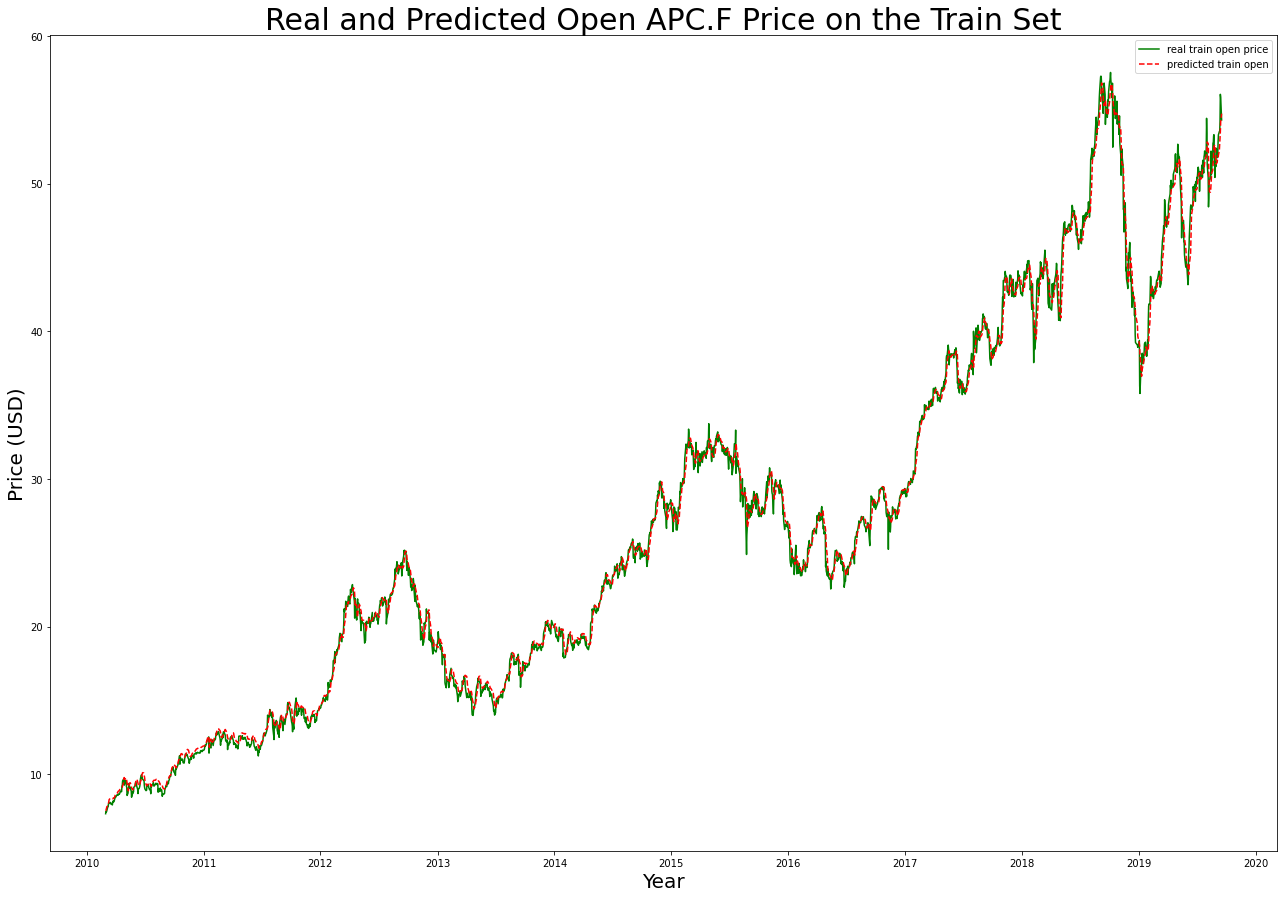

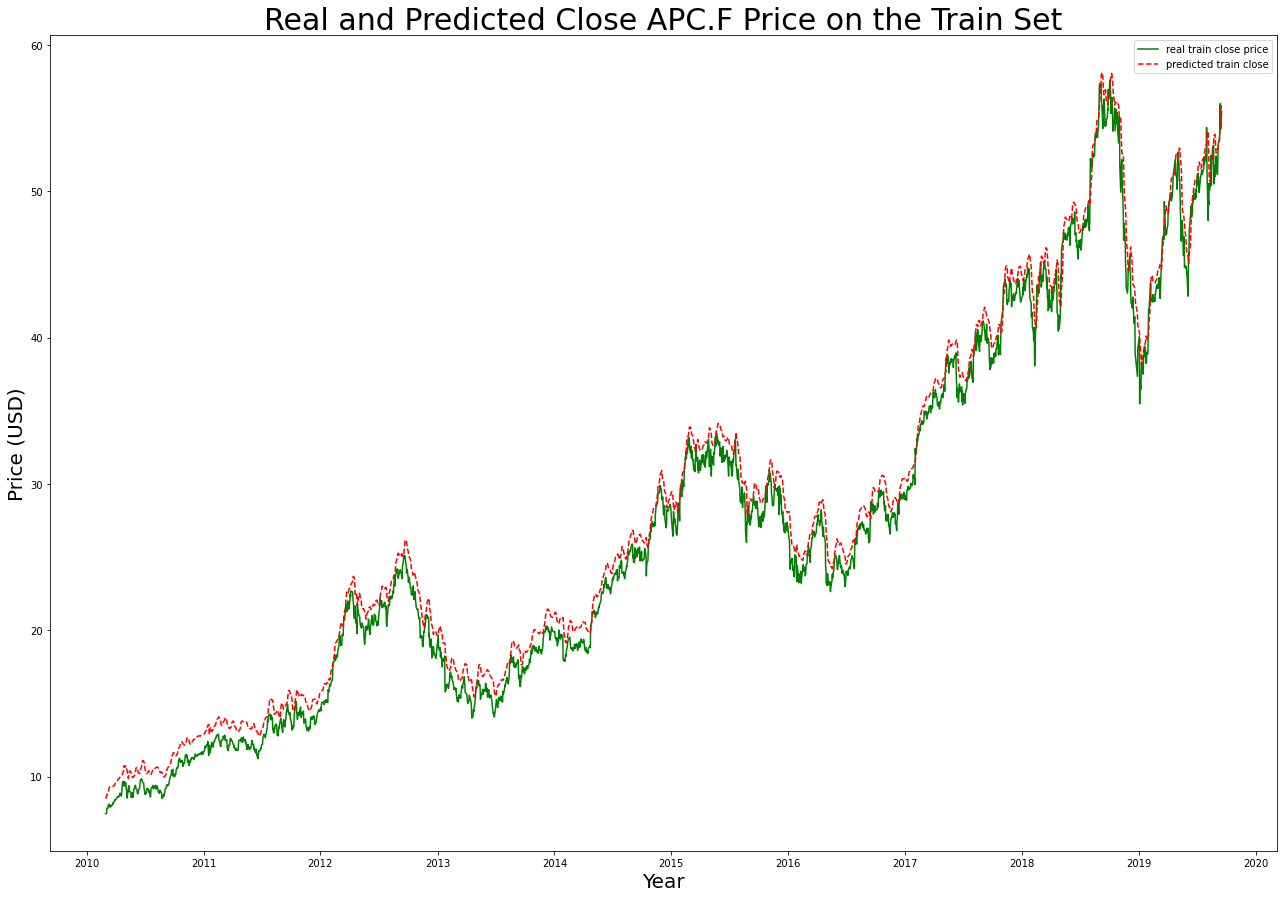

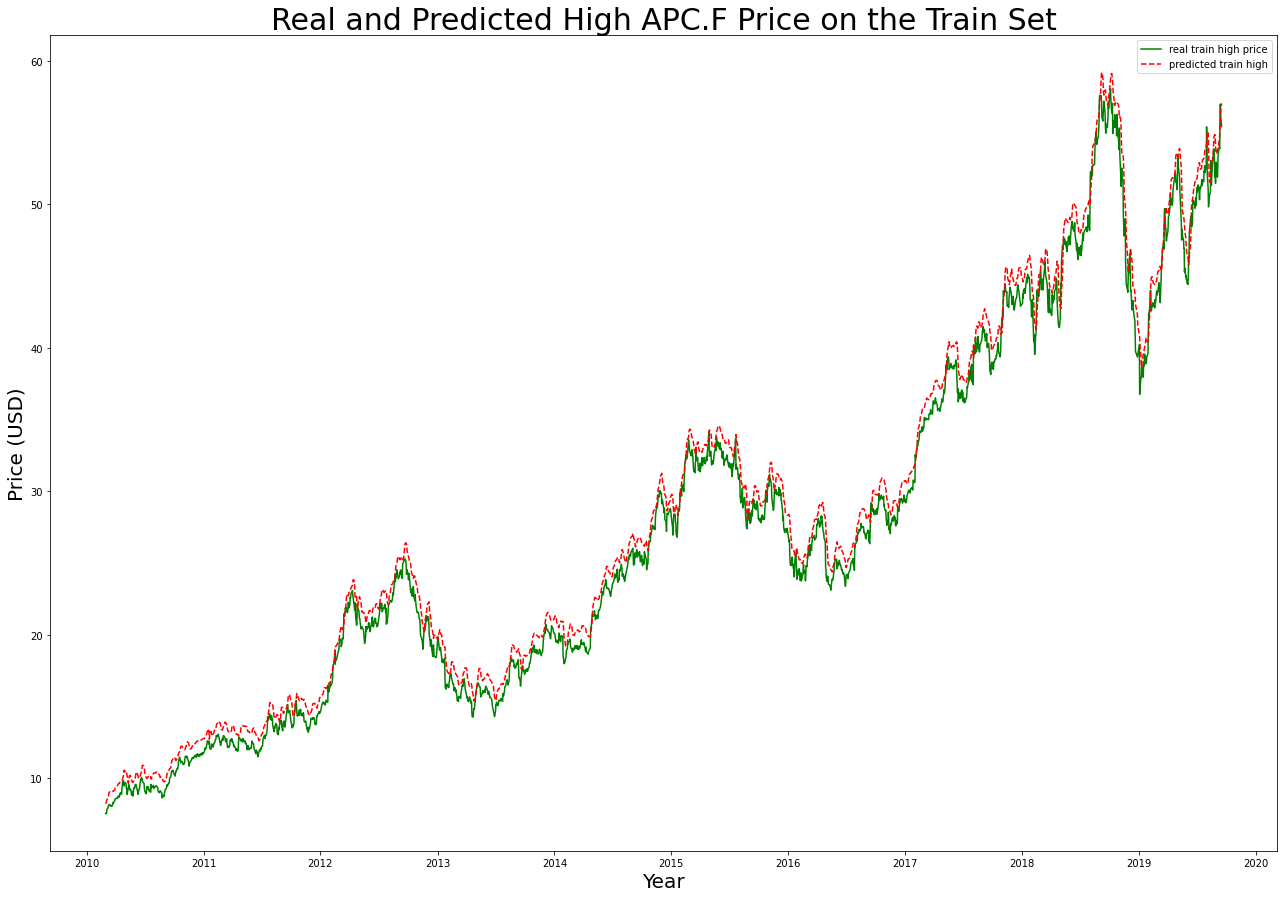

In [ ]:
y_train_low_f_pred, y_train_open_f_pred, y_train_close_f_pred, y_train_high_f_pred = model_f.predict(X_train_f)
trainpreds_arr_f = np.hstack((y_train_low_f_pred, y_train_open_f_pred, y_train_close_f_pred, y_train_high_f_pred))
y_train_f_pred = y_normaliser_f.inverse_transform(trainpreds_arr_f)

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_f, unscaled_y_train_f[:,low], label='real train low price', color='g')

# predicted values plotted
plt.plot(dates_train_f, y_train_f_pred[:,low], label='predicted train low', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low APC.F Price on the Train Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_f, unscaled_y_train_f[:,open], label='real train open price', color='g')

# predicted values plotted
plt.plot(dates_train_f, y_train_f_pred[:,open], label='predicted train open', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Open APC.F Price on the Train Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_f, unscaled_y_train_f[:,close], label='real train close price', color='g')

# predicted values plotted
plt.plot(dates_train_f, y_train_f_pred[:,close], label='predicted train close', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Close APC.F Price on the Train Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_f, unscaled_y_train_f[:,high], label='real train high price', color='g')

# predicted values plotted
plt.plot(dates_train_f, y_train_f_pred[:,high], label='predicted train high', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted High APC.F Price on the Train Set', fontsize=30)

plt.show()

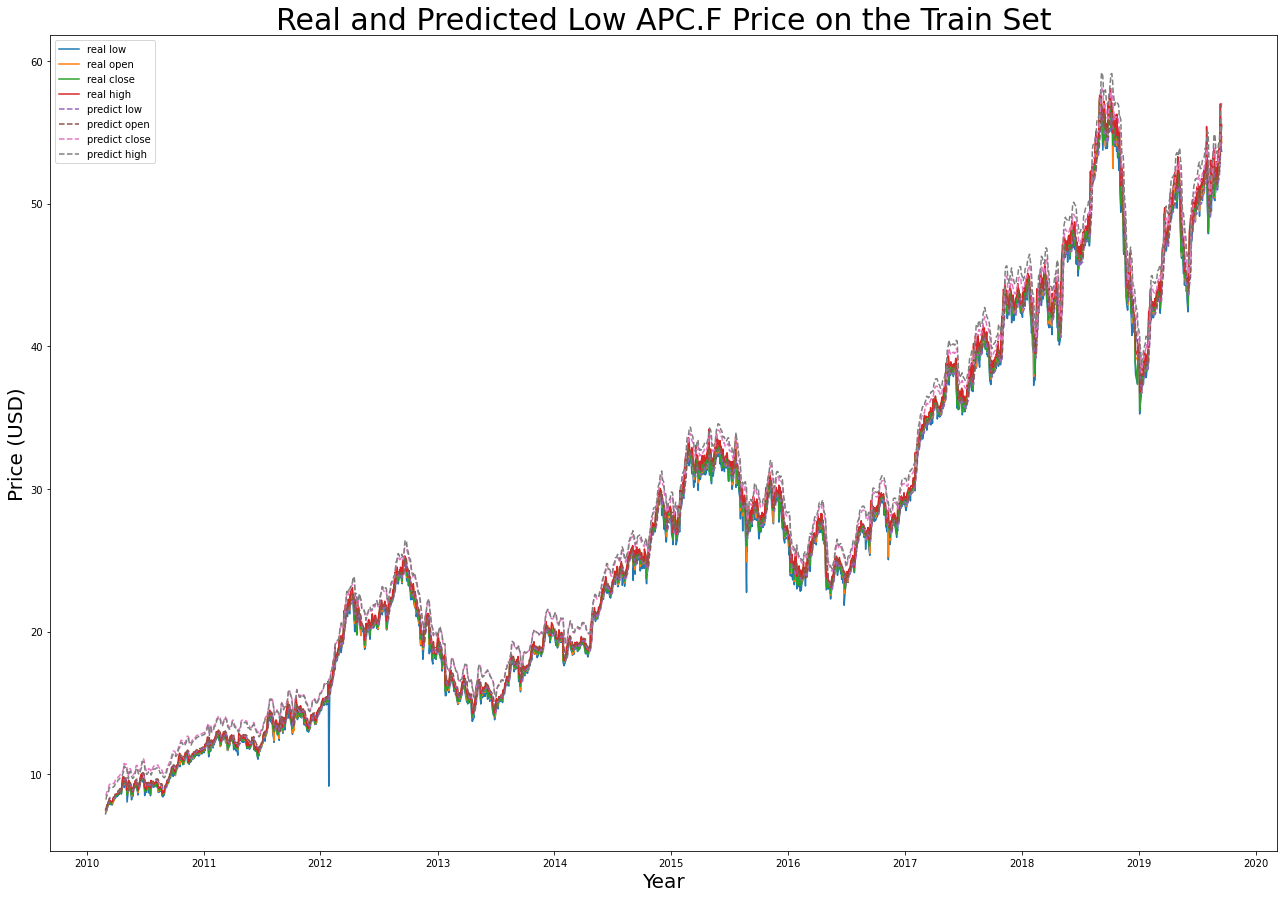

In [ ]:
plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_f, unscaled_y_train_f)

# predicted values plotted
plt.plot(dates_train_f, y_train_f_pred, linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend(['real low','real open','real close','real high','predict low','predict open','predict close','predict high'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low APC.F Price on the Train Set', fontsize=30)

plt.show()

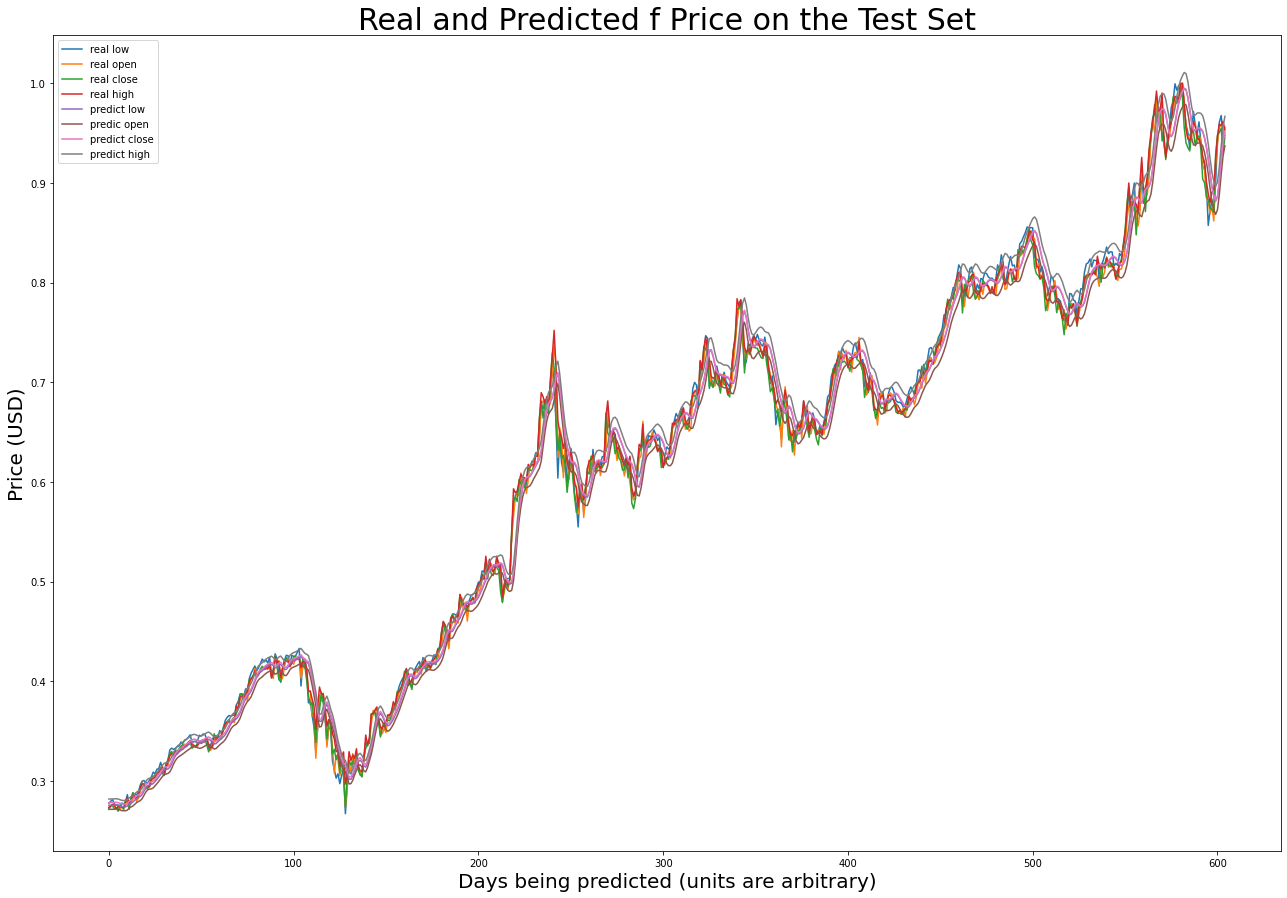

In [ ]:
# Debugging to fix predictions. More specifically, checking if the normalization is the issue.
# Normalization is NOT the issue

low = 0
open = 1
close = 2
high = -1

y_test_low_f_pred, y_test_open_f_pred, y_test_close_f_pred, y_test_high_f_pred = model_f.predict(X_test_f)
preds_arr_f = np.hstack((y_test_low_f_pred, y_test_open_f_pred, y_test_close_f_pred, y_test_high_f_pred))
y_test_f_pred = preds_arr_f

plt.gcf().set_size_inches(22, 15, forward=True)
currentFig.set_facecolor('white')

real = plt.plot(y_test_f[low:high], label='real')
pred = plt.plot(y_test_f_pred[low:high], label='predicted')

plt.legend(['real low','real open','real close','real high','predict low','predic open','predict close','predict high'])
plt.xlabel('Days being predicted (units are arbitrary)', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted f Price on the Test Set', fontsize=30)

plt.show()

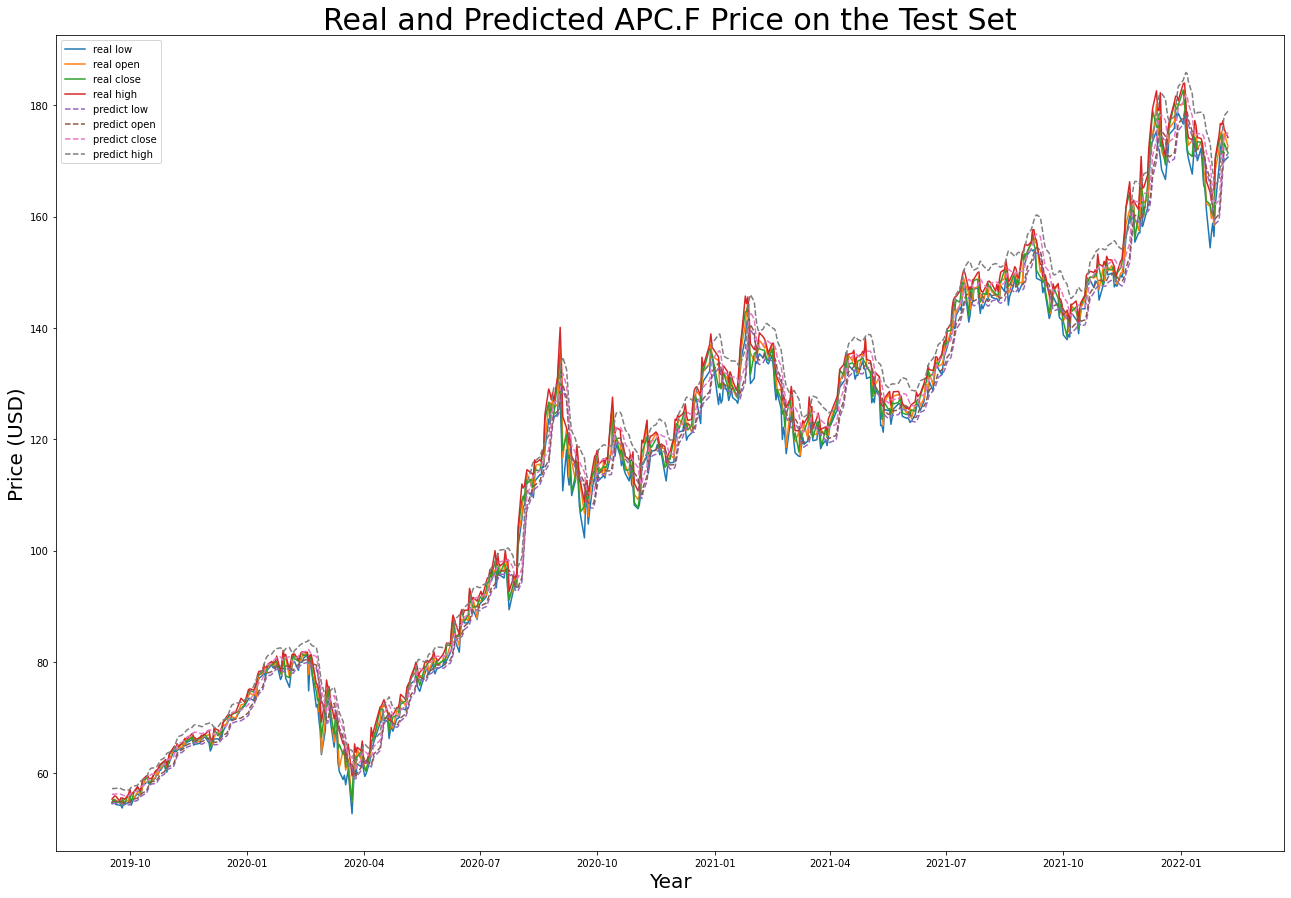

In [ ]:
plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_f, unscaled_y_test_f)

# predicted values plotted
plt.plot(dates_test_f, y_test_f_pred, linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend(['real low','real open','real close','real high','predict low','predict open','predict close','predict high'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted APC.F Price on the Test Set', fontsize=30)

plt.show()

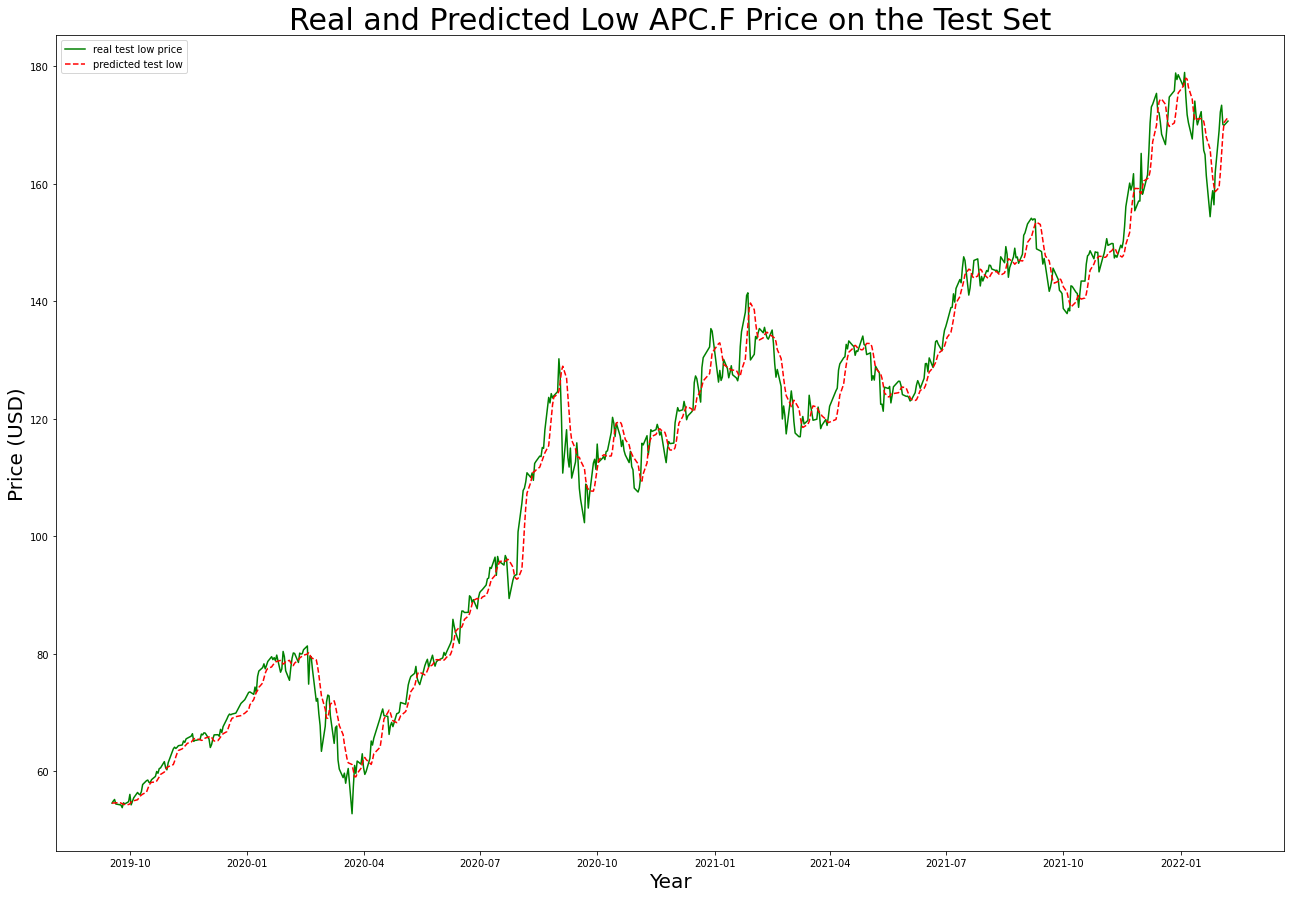

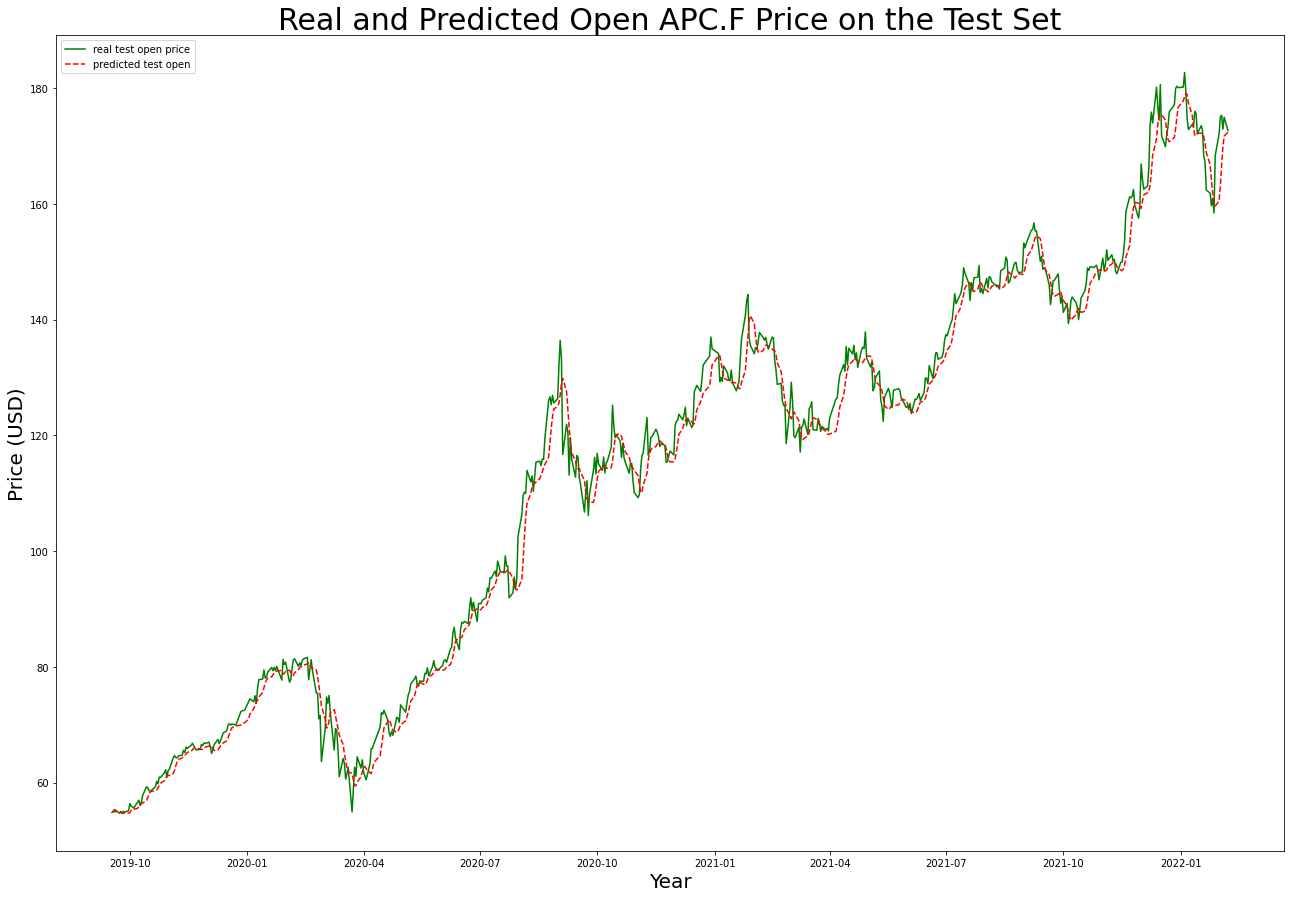

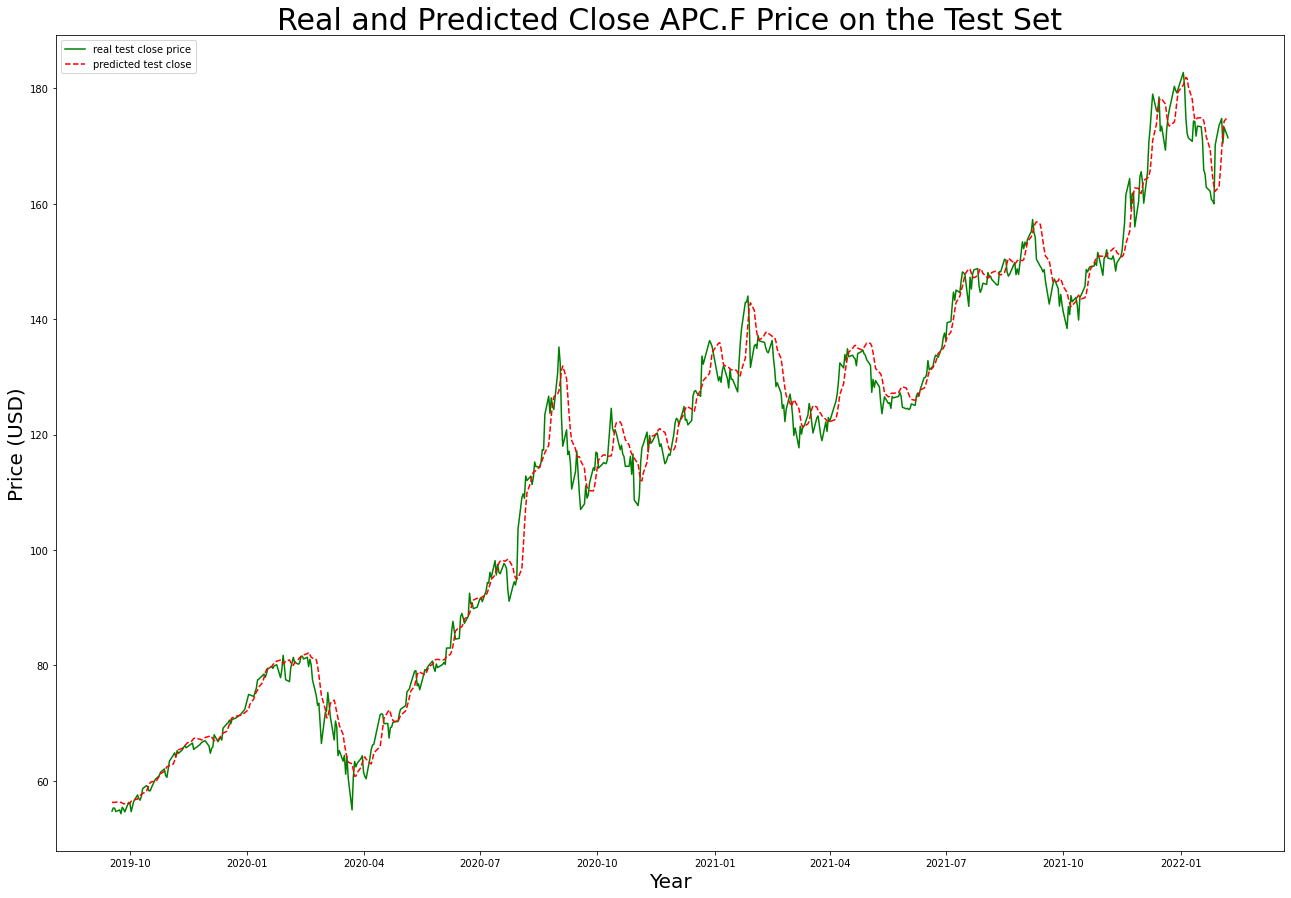

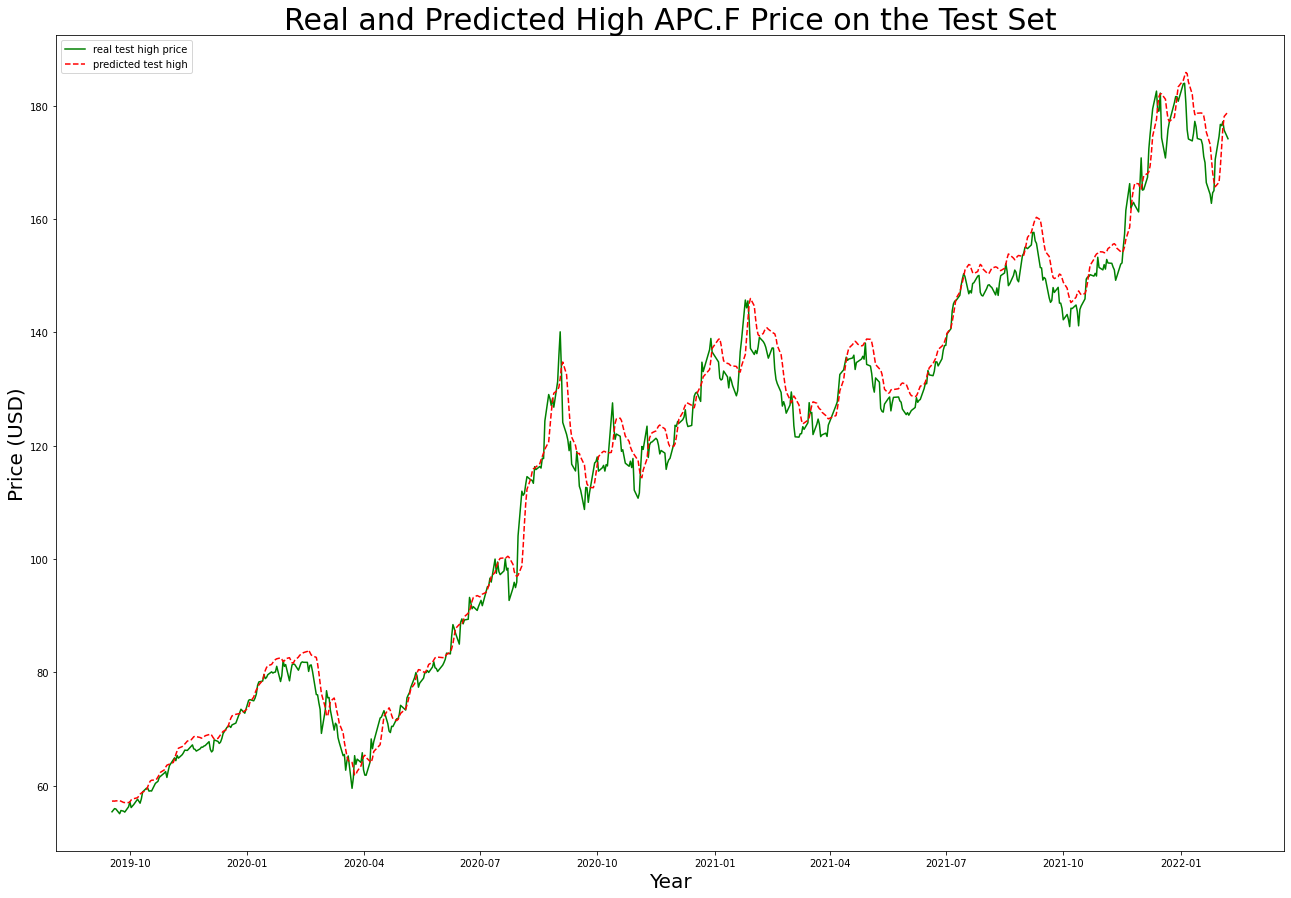

In [ ]:
y_test_low_f_pred, y_test_open_f_pred, y_test_close_f_pred, y_test_high_f_pred = model_f.predict(X_test_f)
testpreds_arr_f = np.hstack((y_test_low_f_pred, y_test_open_f_pred, y_test_close_f_pred, y_test_high_f_pred))
y_test_f_pred = y_normaliser_f.inverse_transform(testpreds_arr_f)

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_f, unscaled_y_test_f[:,low], label='real test low price', color='g')

# predicted values plotted
plt.plot(dates_test_f, y_test_f_pred[:,low], label='predicted test low', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low APC.F Price on the Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_f, unscaled_y_test_f[:,open], label='real test open price', color='g')

# predicted values plotted
plt.plot(dates_test_f, y_test_f_pred[:,open], label='predicted test open', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Open APC.F Price on the Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_f, unscaled_y_test_f[:,close], label='real test close price', color='g')

# predicted values plotted
plt.plot(dates_test_f, y_test_f_pred[:,close], label='predicted test close', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Close APC.F Price on the Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_f, unscaled_y_test_f[:,high], label='real test high price', color='g')

# predicted values plotted
plt.plot(dates_test_f, y_test_f_pred[:,high], label='predicted test high', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted High APC.F Price on the Test Set', fontsize=30)

plt.show()

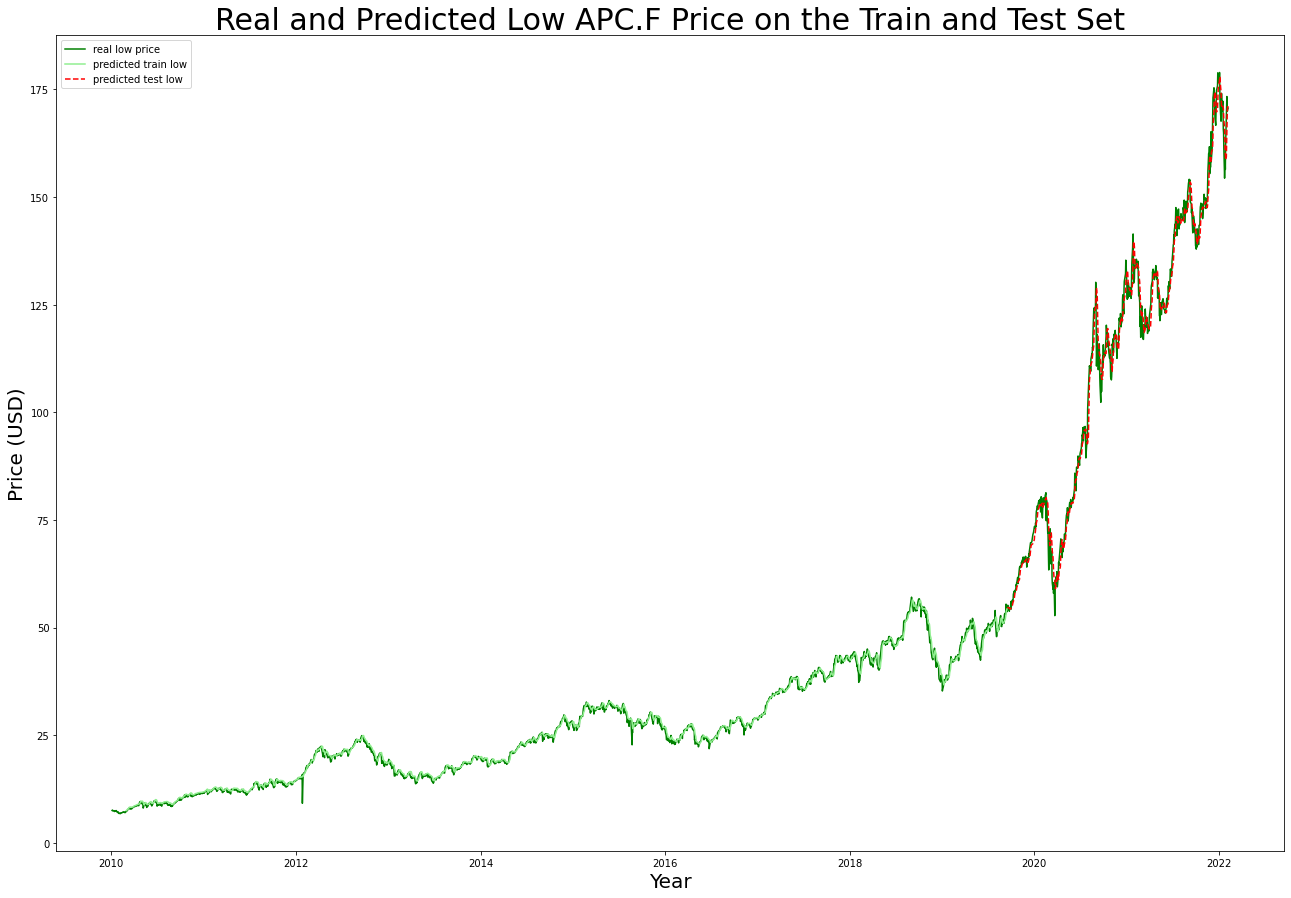

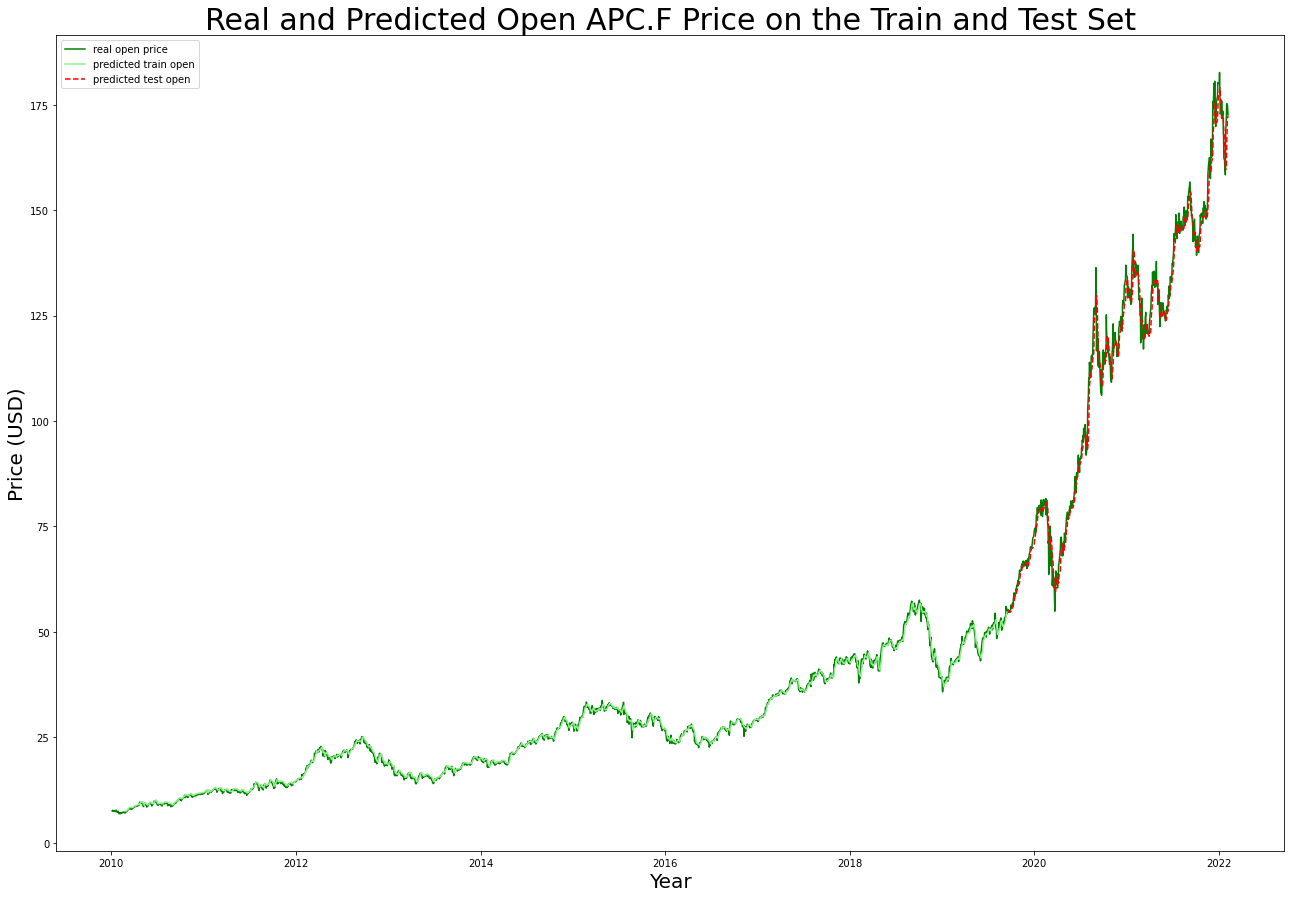

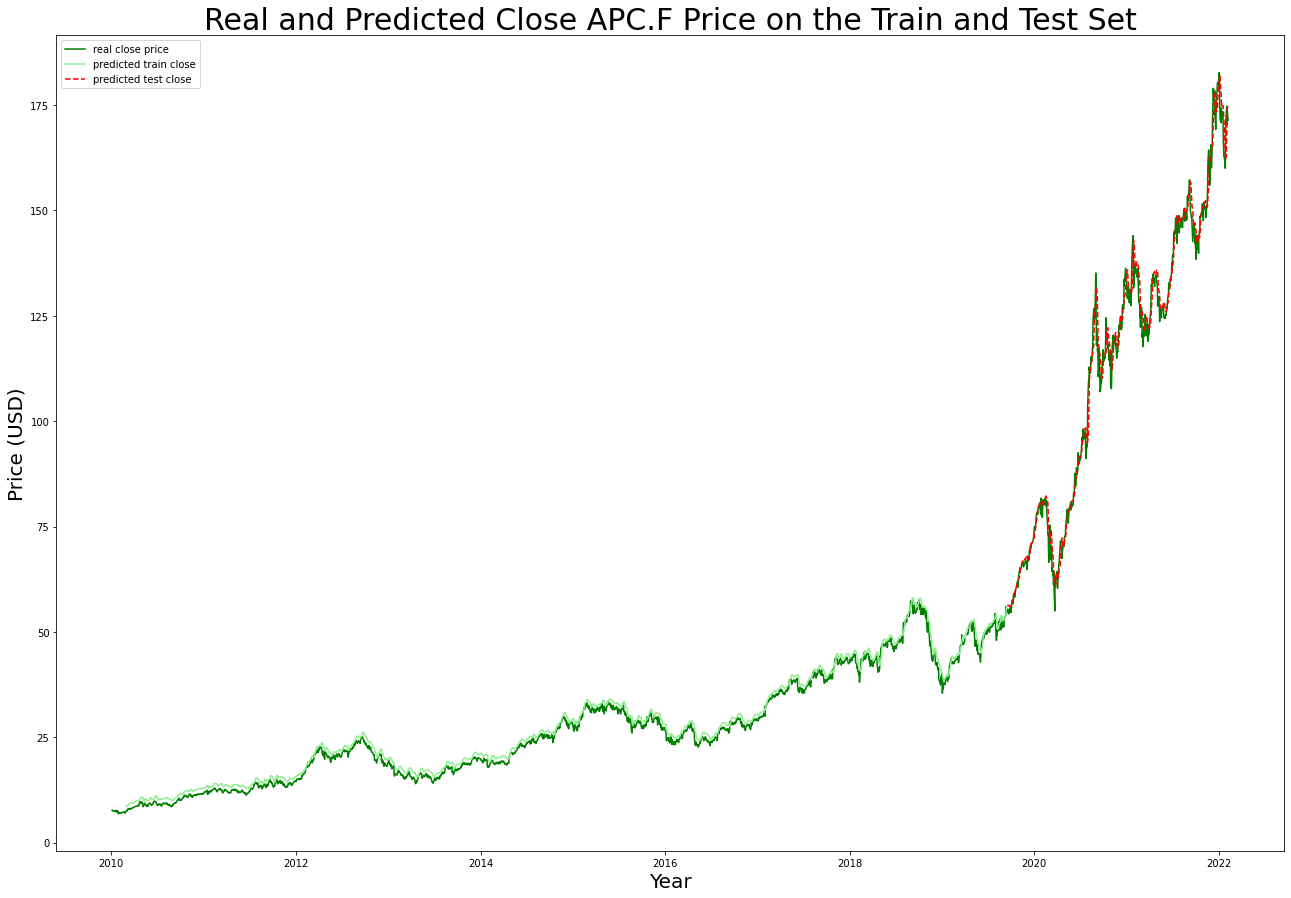

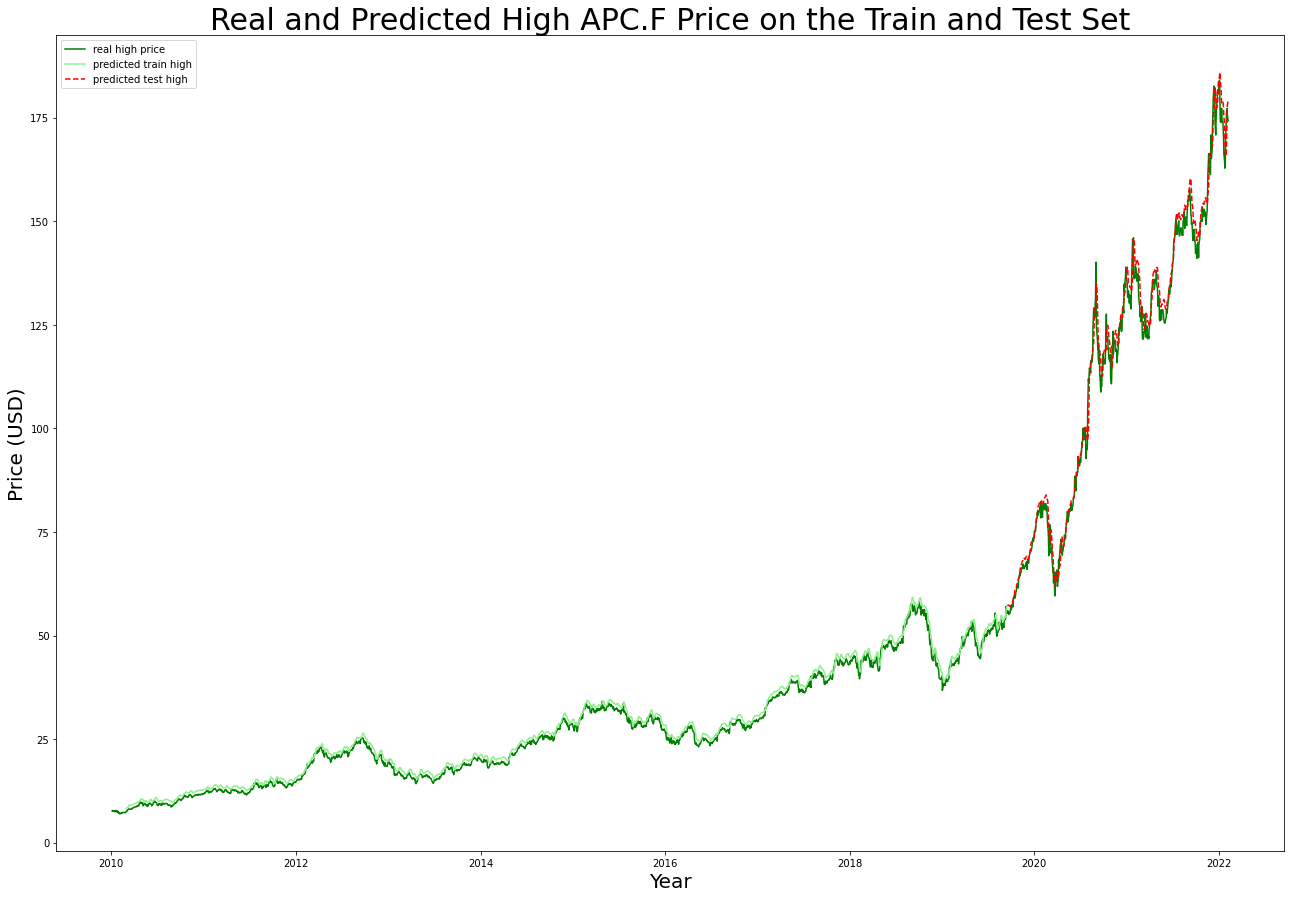

In [ ]:
y_test_low_f_pred, y_test_open_f_pred, y_test_close_f_pred, y_test_high_f_pred = model_f.predict(X_test_f)
testpreds_arr_f = np.hstack((y_test_low_f_pred, y_test_open_f_pred, y_test_close_f_pred, y_test_high_f_pred))
y_test_f_pred = y_normaliser_f.inverse_transform(testpreds_arr_f)

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_f['xlow'], label='real low price', color='g')

# predicted values plotted
plt.plot(dates_train_f, y_train_f_pred[:,low], label='predicted train low', color='lightgreen')
plt.plot(dates_test_f, y_test_f_pred[:,low], label='predicted test low', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low APC.F Price on the Train and Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_f['xopen'], label='real open price', color='g')

# predicted values plotted
plt.plot(dates_train_f, y_train_f_pred[:,open], label='predicted train open', color='lightgreen')
plt.plot(dates_test_f, y_test_f_pred[:,open], label='predicted test open', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Open APC.F Price on the Train and Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_f['xclose'], label='real close price', color='g')

# predicted values plotted
plt.plot(dates_train_f, y_train_f_pred[:,close], label='predicted train close', color='lightgreen')
plt.plot(dates_test_f, y_test_f_pred[:,close], label='predicted test close', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Close APC.F Price on the Train and Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_f['xhigh'], label='real high price', color='g')

# predicted values plotted
plt.plot(dates_train_f, y_train_f_pred[:,high], label='predicted train high', color='lightgreen')
plt.plot(dates_test_f, y_test_f_pred[:,high], label='predicted test high', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted High APC.F Price on the Train and Test Set', fontsize=30)

plt.show()

In [ ]:
#Evaluation MAE, RMSE, MAPE, RMSPE of High Price 
def evaluation(unscaled_y_f, y_f_pred, indexc, x_f):
    mae = mean_absolute_error(unscaled_y_f[:,indexc], y_f_pred[:,indexc])
    rmse = math.sqrt(mean_squared_error(unscaled_y_f[:,indexc], y_f_pred[:,indexc]))
    mape = np.mean(np.abs((unscaled_y_f[:,indexc] - y_f_pred[:,indexc])/unscaled_y_f[:,indexc]))*100

    prermspe = ((y_f_pred[:,indexc] - unscaled_y_f[:,indexc])/unscaled_y_f[:,indexc])
    rmspe_data = np.array([None]*len(x_f))
    for i in range(len(x_f)):
        rmspe_data[i] = math.pow(prermspe[i],2)
    rmspe = math.sqrt(np.mean(rmspe_data))*100
    print('MAE:', mae, '  \nRMSE:', rmse, '  \nMAPE:', mape, '  \nRMSPE:', rmspe)
    
# Low
# Calculating Train data prediction performance metrics
print('Evaluation Low Train Data Prediction')
evaluation(unscaled_y_train_f, y_train_f_pred, low, X_train_f)
# Calculating Test data prediction performance metrics
print('Evaluation Low Test Data Prediction')
evaluation(unscaled_y_test_f, y_test_f_pred, low, X_test_f)

# Open
# Calculating Train data prediction performance metrics
print('\nEvaluation Open Train Data Prediction')
evaluation(unscaled_y_train_f, y_train_f_pred, open, X_train_f)
# Calculating Test data prediction performance metrics
print('Evaluation Open Test Data Prediction')
evaluation(unscaled_y_test_f, y_test_f_pred, open, X_test_f)

# Close
# Calculating Train data prediction performance metrics
print('\nEvaluation Close Train Data Prediction')
evaluation(unscaled_y_train_f, y_train_f_pred, close, X_train_f)
# Calculating Test data prediction performance metrics
print('Evaluation Close Test Data Prediction')
evaluation(unscaled_y_test_f, y_test_f_pred, close, X_test_f)

# High
# Calculating Train data prediction performance metrics
print('\nEvaluation High Train Data Prediction')
evaluation(unscaled_y_train_f, y_train_f_pred, high, X_train_f)
# Calculating Test data prediction performance metrics
print('Evaluation High Test Data Prediction')
evaluation(unscaled_y_test_f, y_test_f_pred, high, X_test_f)

Evaluation Low Train Data Prediction
MAE: 0.5252791432895623   
RMSE: 0.7599106515598766   
MAPE: 2.2144160130480395   
RMSPE: 3.307788508931874
Evaluation Low Test Data Prediction
MAE: 2.4478917595866196   
RMSE: 3.327937781670474   
MAPE: 2.2669070164746974   
RMSPE: 3.1585827028672764

Evaluation Open Train Data Prediction
MAE: 0.4578890469846401   
RMSE: 0.6501420283574264   
MAPE: 1.8738707177635852   
RMSPE: 2.5078998155132237
Evaluation Open Test Data Prediction
MAE: 2.406995519590574   
RMSE: 3.2361371601501947   
MAPE: 2.162497053788809   
RMSPE: 2.8943240541951853

Evaluation Close Train Data Prediction
MAE: 1.1782359971318601   
RMSE: 1.343353761643822   
MAPE: 5.663711628348071   
RMSPE: 6.922272915556155
Evaluation Close Test Data Prediction
MAE: 2.4771318778738136   
RMSE: 3.4114047296075407   
MAPE: 2.202838432561547   
RMSPE: 3.0165105385902646

Evaluation High Train Data Prediction
MAE: 1.108037301097581   
RMSE: 1.2513967701534394   
MAPE: 4.856449484294893   
RMSPE: 

In [ ]:
unscaled_y_test_f[:,high]

array([ 55.39568321,  55.66633335,  55.95640691,  55.89844882,
        55.05194119,  55.62041795,  55.56473637,  55.50833044,
        55.34003925,  56.28694856,  57.16121306,  56.14576064,
        56.66516081,  57.61826408,  57.25835563,  56.91105135,
        57.69336468,  58.90512988,  59.56318244,  59.56259456,
        59.03658362,  59.09744421,  59.06072107,  60.41759675,
        60.6026731 ,  60.77433292,  61.46717086,  61.66555511,
        62.23899309,  62.48749296,  61.45694362,  62.59081173,
        63.54061333,  64.60309249,  64.92642057,  64.42083812,
        65.34216869,  64.86285035,  65.47487517,  65.83305645,
        66.27452235,  66.25845673,  66.22443482,  66.97577614,
        67.20430151,  66.49673223,  66.42605928,  66.11162818,
        66.50667455,  66.80725917,  66.79378256,  66.99724304,
        67.08366327,  67.76874747,  66.41708304,  65.95836963,
        66.21321291,  68.09089848,  67.81163877,  67.45921826,
        67.70255458,  68.31439212,  69.1911821 ,  70.28

In [ ]:
y_train_close_f_pred

array([[0.00586565],
       [0.00601676],
       [0.00649191],
       ...,
       [0.26992095],
       [0.2738177 ],
       [0.2769812 ]], dtype=float32)

In [ ]:
y_test_f_pred[:,high]

array([ 56.63271 ,  56.6543  ,  56.642086,  56.690105,  56.71211 ,
        56.641083,  56.52943 ,  56.423443,  56.39849 ,  56.397457,
        56.514645,  56.850117,  57.064026,  57.229263,  57.525402,
        57.846935,  58.03996 ,  58.198784,  58.544518,  59.119972,
        59.722996,  60.107468,  60.25523 ,  60.301502,  60.47402 ,
        60.8298  ,  61.21495 ,  61.638817,  62.05356 ,  62.51019 ,
        62.862736,  62.95536 ,  63.05562 ,  63.33889 ,  63.949615,
        64.72604 ,  65.34412 ,  65.79815 ,  66.082726,  66.284386,
        66.52526 ,  66.78053 ,  67.04344 ,  67.26593 ,  67.507576,
        67.78654 ,  67.88175 ,  67.817276,  67.66275 ,  67.548035,
        67.60393 ,  67.75824 ,  67.97076 ,  68.16801 ,  68.26803 ,
        68.07317 ,  67.704865,  67.42358 ,  67.51624 ,  67.83928 ,
        68.150116,  68.454865,  68.71369 ,  69.08568 ,  69.65553 ,
        70.3335  ,  70.97278 ,  71.40554 ,  71.67669 ,  71.85705 ,
        72.28275 ,  72.88406 ,  73.757545,  74.68084 ,  75.364

In [ ]:
model_f.get_weights()

[array([[ 0.05289034, -0.0213502 , -0.06152522, ...,  0.04225517,
          0.02190528, -0.106705  ],
        [-0.08826155,  0.00753723,  0.10485487, ..., -0.01210919,
          0.04630487, -0.03984876],
        [-0.06191273, -0.00044518, -0.00135928, ...,  0.09616548,
         -0.10852078, -0.0745186 ],
        [ 0.01199476, -0.03927205, -0.03310902, ...,  0.07409807,
          0.06457741,  0.05967698],
        [ 0.05441974,  0.07328043,  0.02844703, ..., -0.06561062,
          0.10494754, -0.08138619]], dtype=float32),
 array([[ 0.06997361,  0.01561798,  0.02854899, ...,  0.00634375,
         -0.03140269,  0.06067409],
        [-0.00981274, -0.04001559,  0.04725136, ...,  0.0800566 ,
         -0.01381747,  0.01401914],
        [ 0.01440756, -0.07653814,  0.07042517, ...,  0.03545579,
          0.01941076,  0.12091627],
        ...,
        [ 0.05770068,  0.00543223,  0.00967097, ..., -0.02740091,
         -0.13570374,  0.08098333],
        [-0.00833888,  0.05088223,  0.01897246, ...,

In [ ]:
model_f.save('modelf.h5')

# **Predict for 1 Day APC.F**

In [ ]:
data_pred_f = normalizedData_f[num_data_f-200:,:5].reshape(5,40,5)
data_pred_f

array([[[0.73020654, 0.74505157, 0.72137   , 0.74091873, 0.01151813],
        [0.72110559, 0.71938266, 0.71709385, 0.71966859, 0.00431071],
        [0.72285652, 0.71062596, 0.71158508, 0.71800476, 0.00686664],
        [0.69571465, 0.71544931, 0.68487708, 0.71024891, 0.00855315],
        [0.70022081, 0.68716727, 0.69767668, 0.69769065, 0.0053261 ],
        [0.69590164, 0.69028308, 0.68987052, 0.69199852, 0.00386429],
        [0.70962178, 0.70004684, 0.69642875, 0.70616832, 0.00371681],
        [0.70271592, 0.70668562, 0.69022116, 0.70194098, 0.00441932],
        [0.67199291, 0.67860786, 0.67488692, 0.67566029, 0.01095214],
        [0.67213261, 0.67148561, 0.66377377, 0.67285873, 0.00662051],
        [0.66509048, 0.65716565, 0.67300193, 0.67205003, 0.00213044],
        [0.68887263, 0.68072089, 0.68048315, 0.68009823, 0.00240447],
        [0.68760631, 0.68957095, 0.67392235, 0.68568111, 0.0030442 ],
        [0.68961977, 0.68533015, 0.67471838, 0.68718881, 0.00326791],
        [0.67333717,

In [ ]:
ylow_f,yopen_f,yclose_f,yhigh_f = model_f.predict(data_pred_f[[4]])
yhat_f = ylow_f,yopen_f,yclose_f,yhigh_f
nextday_pred_f = np.hstack((ylow_f,yopen_f,yclose_f,yhigh_f))
nextday_pred_f = y_normaliser_f.inverse_transform(nextday_pred_f)
nextday_pred_f

array([[171.33496, 172.32486, 175.05684, 178.90228]], dtype=float32)

# **AAPL.MX**

In [ ]:
# Extract price
data_mx = stock_mx.filter(['xlow', 'xopen', 'xclose', 'xhigh','Volume'])
dataset_mx = data_mx.values

In [ ]:
# Preprocess the data
normalizer = MinMaxScaler(feature_range=(0,1)) # instantiate scaler
normalizedData_mx = normalizer.fit_transform(dataset_mx) # values between 0,1
print(normalizedData_mx)

[[3.19212205e-02 3.13326239e-02 3.21587031e-02 3.17898653e-02
  7.26798683e-03]
 [3.25168880e-02 3.21313586e-02 3.21627182e-02 3.21371204e-02
  1.98715989e-02]
 [3.18275149e-02 3.20288968e-02 3.15433187e-02 3.20437233e-02
  2.76875689e-03]
 ...
 [9.72027966e-01 9.58266537e-01 9.66420424e-01 9.60652594e-01
  2.54379539e-03]
 [9.67936209e-01 9.58497547e-01 9.54233601e-01 9.61119485e-01
  2.71560664e-03]
 [9.53174716e-01 9.42294461e-01 9.56938093e-01 9.51641586e-01
  6.25442404e-04]]


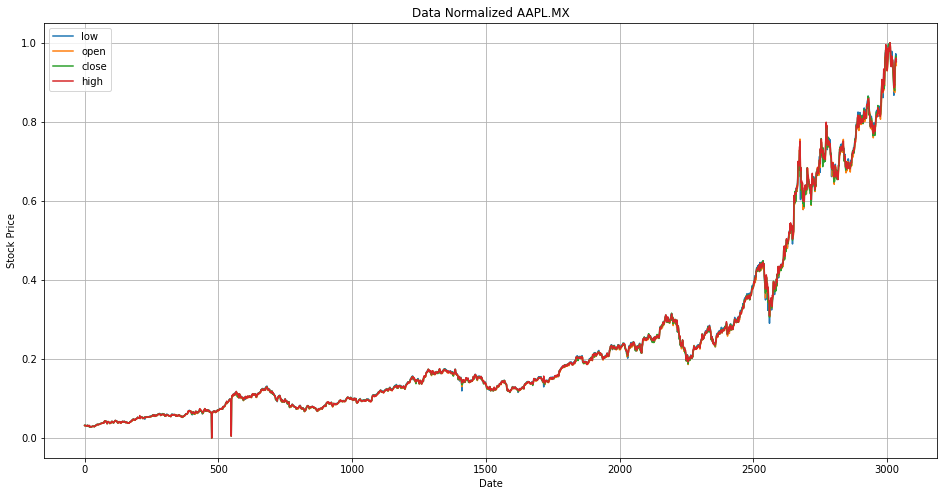

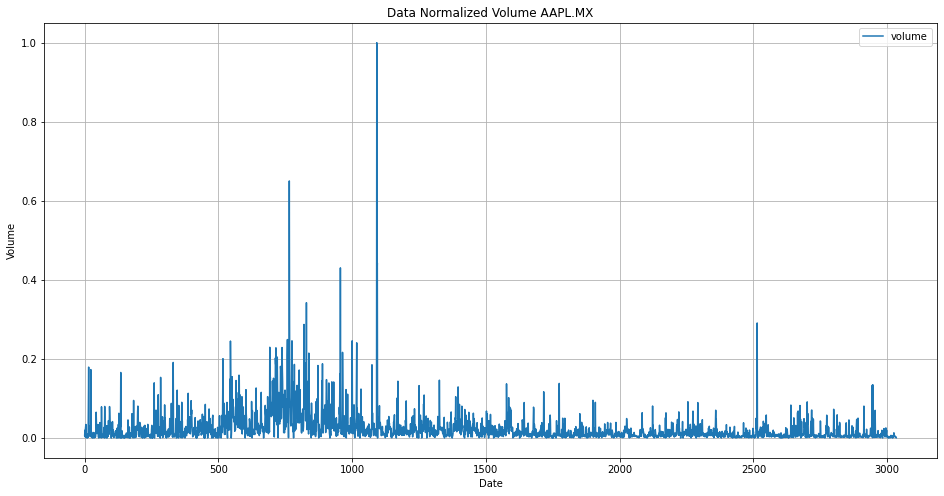

In [ ]:
# Visualization data normalized

# AAPL.MX
plt.figure(figsize=(16,8))
plt.title('Data Normalized AAPL.MX')
plt.plot(normalizedData_mx[:,:4])

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['low','open','close','high'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

plt.figure(figsize=(16,8))
plt.title('Data Normalized Volume AAPL.MX')
plt.plot(normalizedData_mx[:,4:])

plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(['volume'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

In [ ]:
# Storing the number of data points in the array
num_data_mx = len(normalizedData_mx)
num_days_used = 40
data_used_mx = np.array([normalizedData_mx[i : i + num_days_used].copy() for i in range(num_data_mx - num_days_used)])

# Creating a numpy array that contains the value(s) to predict
# Currently, trying to fit the 4 outputs
data_to_predict_mx = np.array(normalizedData_mx[(num_days_used):, :4])

# Creating a dates array for the dates that were used by data_used
dates_used_mx = stock_mx.index[num_days_used:num_data_mx]

# Storing the scaler object for prediction later
y_normaliser_mx = MinMaxScaler()
y_normaliser_mx.fit(stock_mx[['xlow', 'xopen', 'xclose', 'xhigh']].to_numpy()[num_days_used:])

display(normalizedData_mx.shape, data_used_mx.shape,data_to_predict_mx.shape, dates_used_mx.shape)

(3035, 5)

(2995, 40, 5)

(2995, 4)

(2995,)

In [ ]:
train_split = 0.8
data_size_mx = data_used_mx.shape[0]
num_features_mx = data_used_mx.shape[2]
train_size_mx = int(data_size_mx * train_split)
test_size_mx = data_size_mx - train_size_mx

# Splitting the dataset up into train and test sets
X_train_mx = data_used_mx[0:train_size_mx, :, :]
y_train_mx = data_to_predict_mx[0:train_size_mx, :]
dates_train_mx = dates_used_mx[0:train_size_mx]
X_test_mx = data_used_mx[train_size_mx:, :, :]
y_test_mx = data_to_predict_mx[train_size_mx:, :]
dates_test_mx = dates_used_mx[train_size_mx:]

unscaled_y_train_mx = stock_mx[['xlow', 'xopen', 'xclose', 'xhigh']].to_numpy()[(num_days_used):][0:train_size_mx, :]
unscaled_y_test_mx = stock_mx[['xlow', 'xopen', 'xclose', 'xhigh']].to_numpy()[(num_days_used):][train_size_mx:, :]

display("X_train shape:", X_train_mx.shape, "y_train shape:", y_train_mx.shape, 
        "X_test shape:", X_test_mx.shape, "y_test shape:", y_test_mx.shape,
        "unscaled_y_train shape:", unscaled_y_train_mx.shape, "unscaled_y_test shape:", unscaled_y_test_mx.shape)

'X_train shape:'

(2396, 40, 5)

'y_train shape:'

(2396, 4)

'X_test shape:'

(599, 40, 5)

'y_test shape:'

(599, 4)

'unscaled_y_train shape:'

(2396, 4)

'unscaled_y_test shape:'

(599, 4)

In [ ]:
# Creating the input layer, whose shape is (num_days_used, num_mxeatures) because it is
# the open, high, low, close, volume for the past num_days_used days 
input = Input(shape=(num_days_used, num_features_mx), name = 'input')

x = GRU(200, return_sequences=True, name='gru_1')(input)
x = Dropout(0.5)(x)
x = Dense(4, name='dense_2')(x)

# Branching out
output1 = GRU(200, return_sequences=True, name='low_0')(x)
output1 = Dropout(0.5)(output1)
output1 = GRU(200, name='low_1')(output1)
output1 = Dropout(0.5)(output1)
output1 = Dense(1, name='low_final')(output1)

output2 = GRU(200, return_sequences=True, name='open_0')(x)
output2 = Dropout(0.5)(output2)
output2 = GRU(200, name='open_1')(output2)
output2 = Dropout(0.5)(output2)
output2 = Dense(1, name='open_final')(output2)

output3 = GRU(200, return_sequences=True, name='close_0')(x)
output3 = Dropout(0.5)(output3)
output3 = GRU(200, name='close_1')(output3)
output3 = Dropout(0.5)(output3)
output3 = Dense(1, name='close_final')(output3)

output4 = GRU(200, return_sequences=True, name='high_0')(x)
output4 = Dropout(0.5)(output4)
output4 = GRU(200, name='high_1')(output4)
output4 = Dropout(0.5)(output4)
output4 = Dense(1, name='high_final')(output4)

model_mx = Model(inputs = input, outputs = [output1, output2, output3, output4])

# Choosing Adam as the optimizer
# Adam is an optimizer of hyperparameters
adam = Adam(learning_rate=0.001)

# model.compile is where you define the type of optimizer, loss, etc. 
# that you want to use. Here, we use Adam and MAE
model_mx.compile(optimizer=adam, loss='mae')
model_mx.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 40, 5)]      0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 40, 200)      124200      input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 40, 200)      0           gru_1[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 40, 4)        804         dropout[0][0]                    
______________________________________________________________________________________________

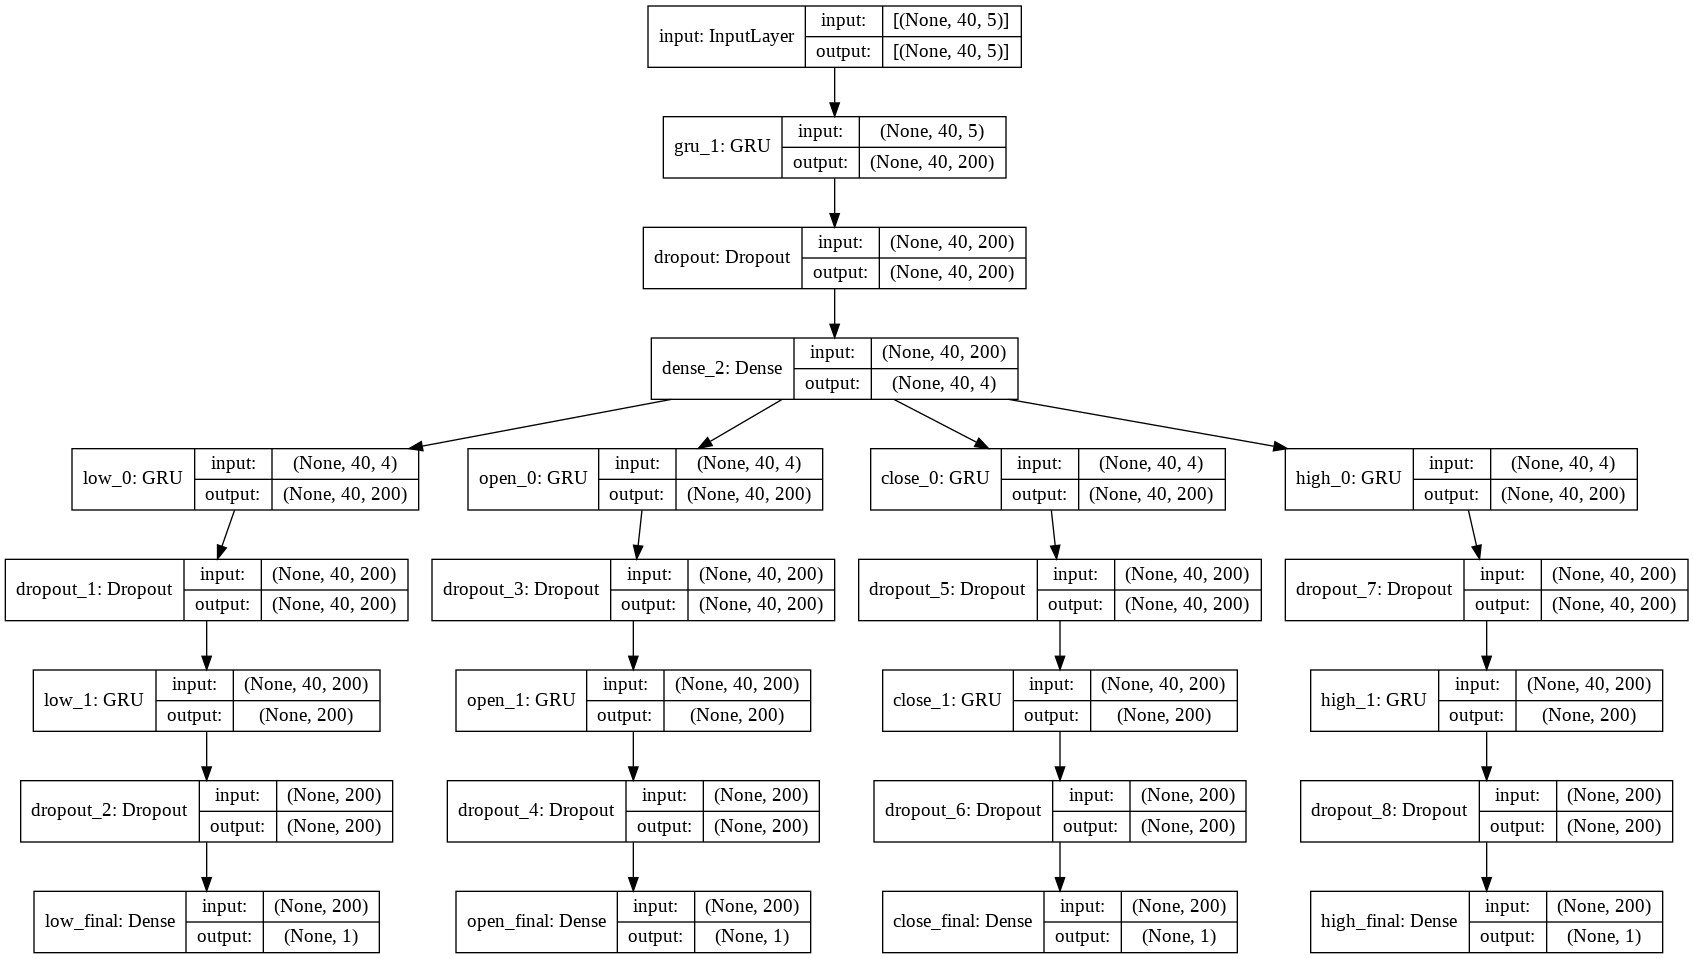

In [ ]:
# Displaying the structure of the final model
plot_model(model_mx, show_shapes=True)

In [ ]:
history = model_mx.fit(x=X_train_mx, y=y_train_mx, batch_size=32, epochs=20, validation_split=0.2)
evaluation = model_mx.evaluate(X_test_mx, y_test_mx)
print(evaluation)

Epoch 1/20
60/60 [==============================] - 96s 992ms/step - loss: 0.0054 - low_final_loss: 0.0013 - open_final_loss: 0.0014 - close_final_loss: 0.0014 - high_final_loss: 0.0013 - val_loss: 3.5799e-04 - val_low_final_loss: 7.2067e-05 - val_open_final_loss: 8.2689e-05 - val_close_final_loss: 1.1080e-04 - val_high_final_loss: 9.2435e-05
Epoch 2/20
60/60 [==============================] - 59s 982ms/step - loss: 7.7392e-04 - low_final_loss: 1.9414e-04 - open_final_loss: 1.9724e-04 - close_final_loss: 1.9511e-04 - high_final_loss: 1.8743e-04 - val_loss: 5.6497e-04 - val_low_final_loss: 1.4310e-04 - val_open_final_loss: 1.3698e-04 - val_close_final_loss: 1.0497e-04 - val_high_final_loss: 1.7991e-04
Epoch 3/20
60/60 [==============================] - 59s 993ms/step - loss: 6.6743e-04 - low_final_loss: 1.7263e-04 - open_final_loss: 1.6321e-04 - close_final_loss: 1.7423e-04 - high_final_loss: 1.5736e-04 - val_loss: 8.3344e-04 - val_low_final_loss: 2.2266e-04 - val_open_final_loss: 3.876

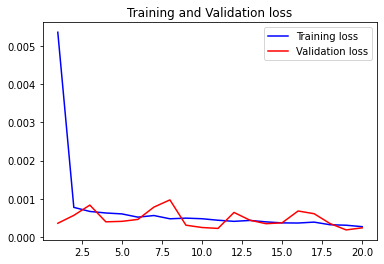

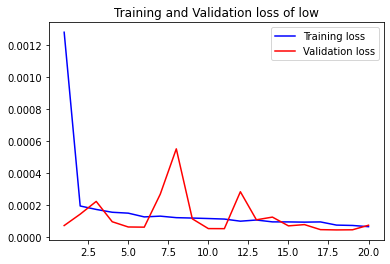

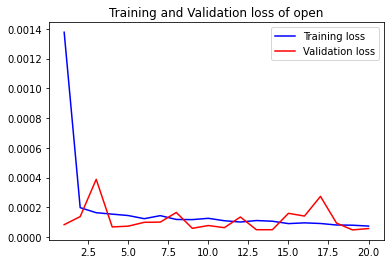

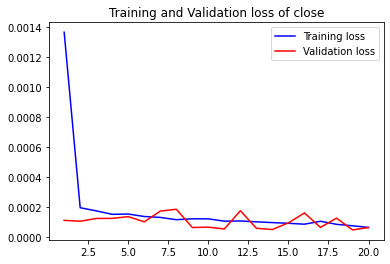

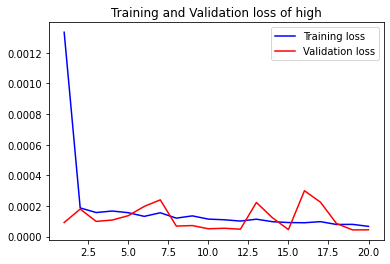

In [ ]:
loss_mx = history.history['loss']
val_loss_mx = history.history['val_loss']
low_loss_mx = history.history['low_final_loss']
val_low_loss_mx = history.history['val_low_final_loss']
open_loss_mx = history.history['open_final_loss']
val_open_loss_mx = history.history['val_open_final_loss']
close_loss_mx = history.history['close_final_loss']
val_close_loss_mx = history.history['val_close_final_loss']
high_loss_mx = history.history['high_final_loss']
val_high_loss_mx = history.history['val_high_final_loss']
epochs_mx = range(1, len(loss_mx) + 1)
plt.figure()

#Train and validation loss
plt.plot(epochs_mx, loss_mx, 'b', label='Training loss')
plt.plot(epochs_mx, val_loss_mx, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

plt.plot(epochs_mx, low_loss_mx, 'b', label='Training loss')
plt.plot(epochs_mx, val_low_loss_mx, 'r', label='Validation loss')
plt.title('Training and Validation loss of low')
plt.legend()
plt.show()

plt.plot(epochs_mx, open_loss_mx, 'b', label='Training loss')
plt.plot(epochs_mx, val_open_loss_mx, 'r', label='Validation loss')
plt.title('Training and Validation loss of open')
plt.legend()
plt.show()

plt.plot(epochs_mx, close_loss_mx, 'b', label='Training loss')
plt.plot(epochs_mx, val_close_loss_mx, 'r', label='Validation loss')
plt.title('Training and Validation loss of close')
plt.legend()
plt.show()

plt.plot(epochs_mx, high_loss_mx, 'b', label='Training loss')
plt.plot(epochs_mx, val_high_loss_mx, 'r', label='Validation loss')
plt.title('Training and Validation loss of high')
plt.legend()
plt.show()

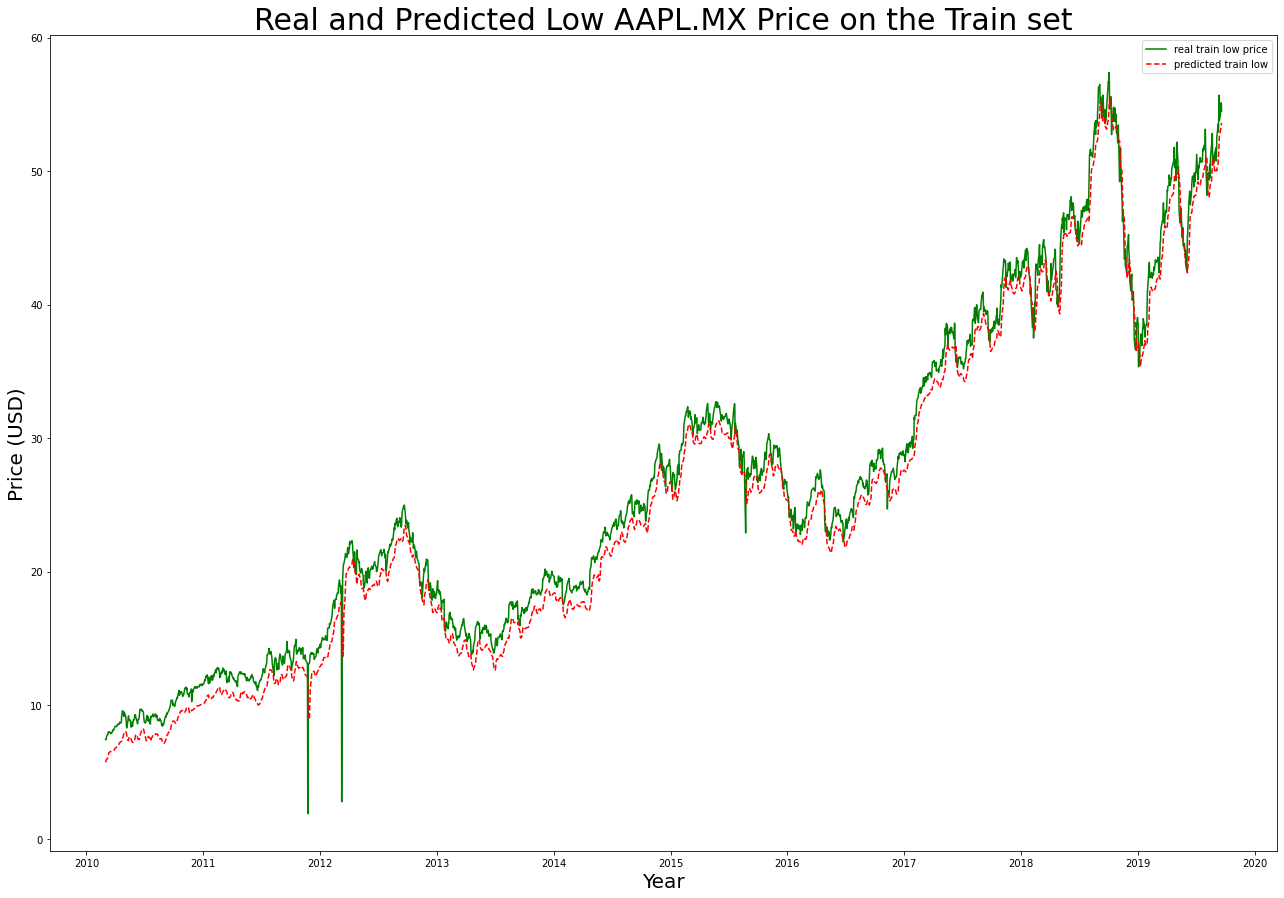

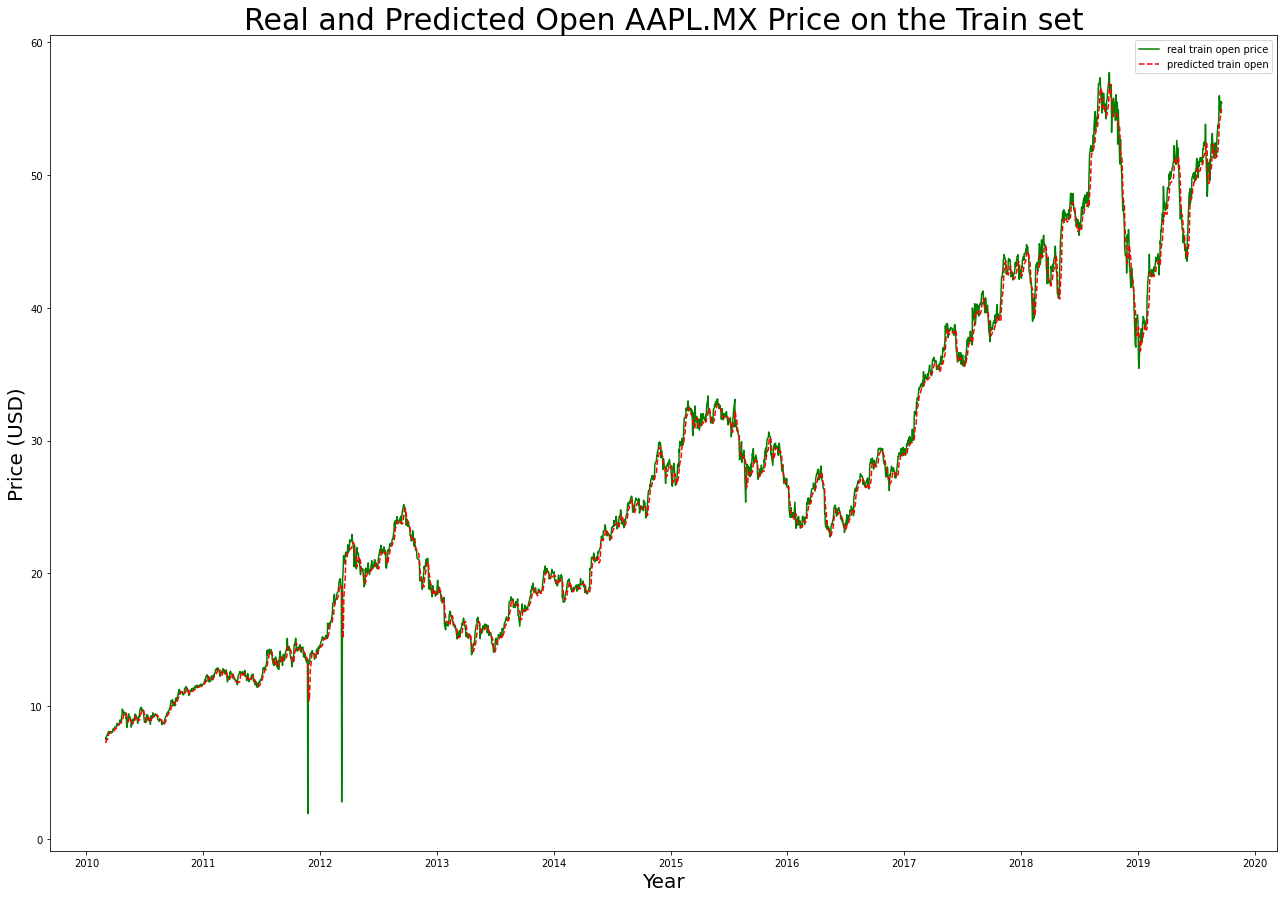

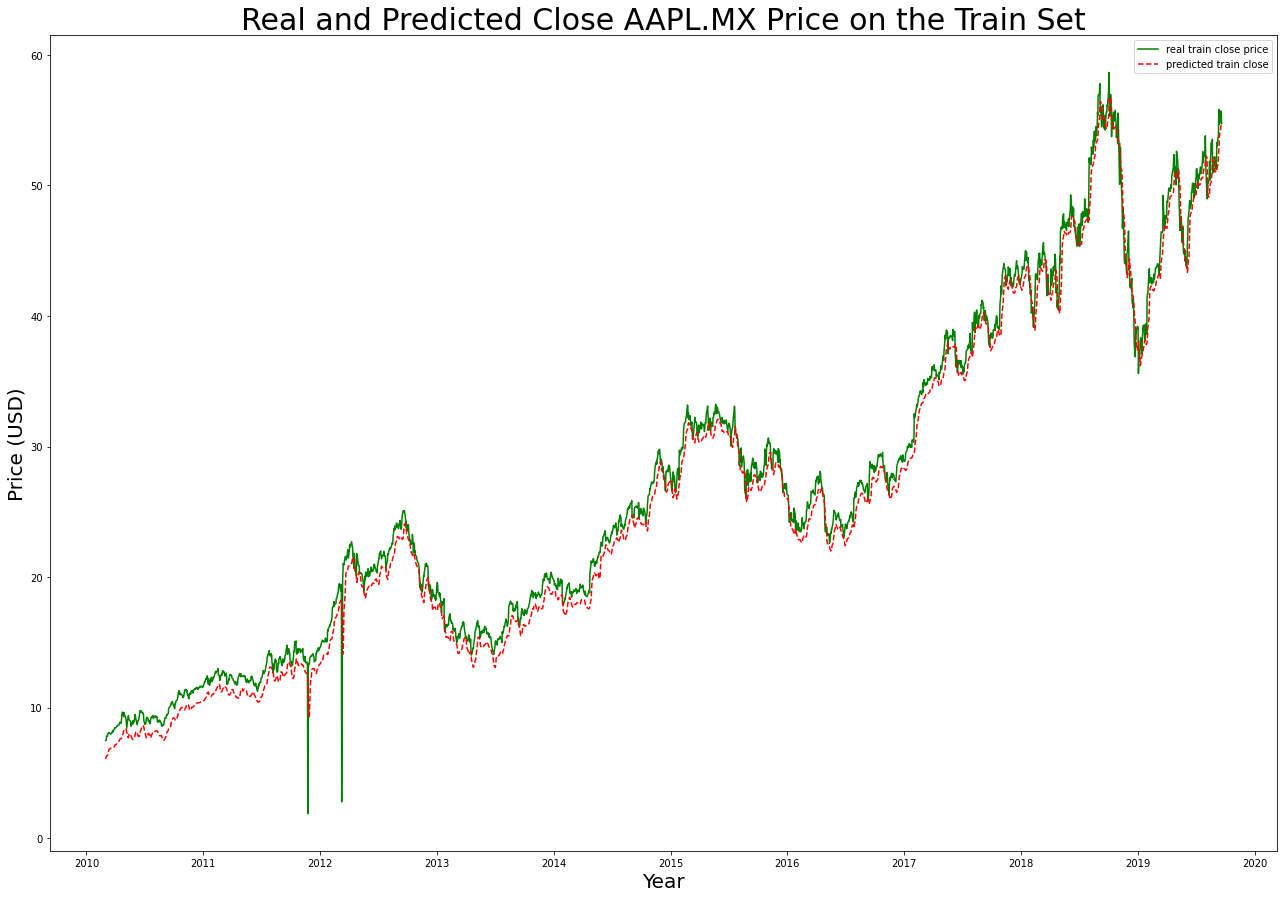

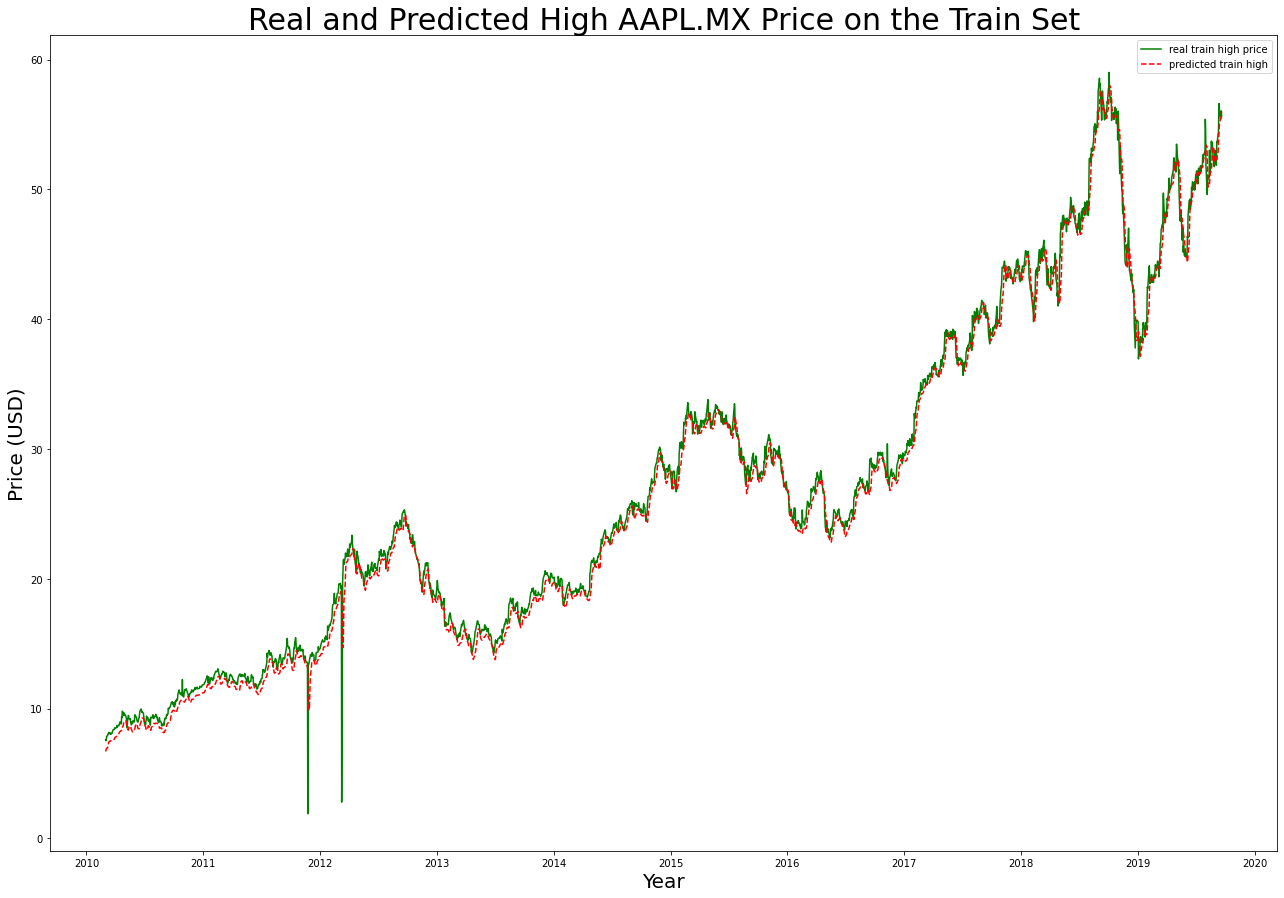

In [ ]:
y_train_low_mx_pred, y_train_open_mx_pred, y_train_close_mx_pred, y_train_high_mx_pred = model_mx.predict(X_train_mx)
trainpreds_arr_mx = np.hstack((y_train_low_mx_pred, y_train_open_mx_pred, y_train_close_mx_pred, y_train_high_mx_pred))
y_train_mx_pred = y_normaliser_mx.inverse_transform(trainpreds_arr_mx)

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_mx, unscaled_y_train_mx[:,low], label='real train low price', color='g')

# predicted values plotted
plt.plot(dates_train_mx, y_train_mx_pred[:,low], label='predicted train low', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low AAPL.MX Price on the Train set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_mx, unscaled_y_train_mx[:,open], label='real train open price', color='g')

# predicted values plotted
plt.plot(dates_train_mx, y_train_mx_pred[:,open], label='predicted train open', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Open AAPL.MX Price on the Train set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_mx, unscaled_y_train_mx[:,close], label='real train close price', color='g')

# predicted values plotted
plt.plot(dates_train_mx, y_train_mx_pred[:,close], label='predicted train close', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Close AAPL.MX Price on the Train Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_mx, unscaled_y_train_mx[:,high], label='real train high price', color='g')

# predicted values plotted
plt.plot(dates_train_mx, y_train_mx_pred[:,high], label='predicted train high', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted High AAPL.MX Price on the Train Set', fontsize=30)

plt.show()

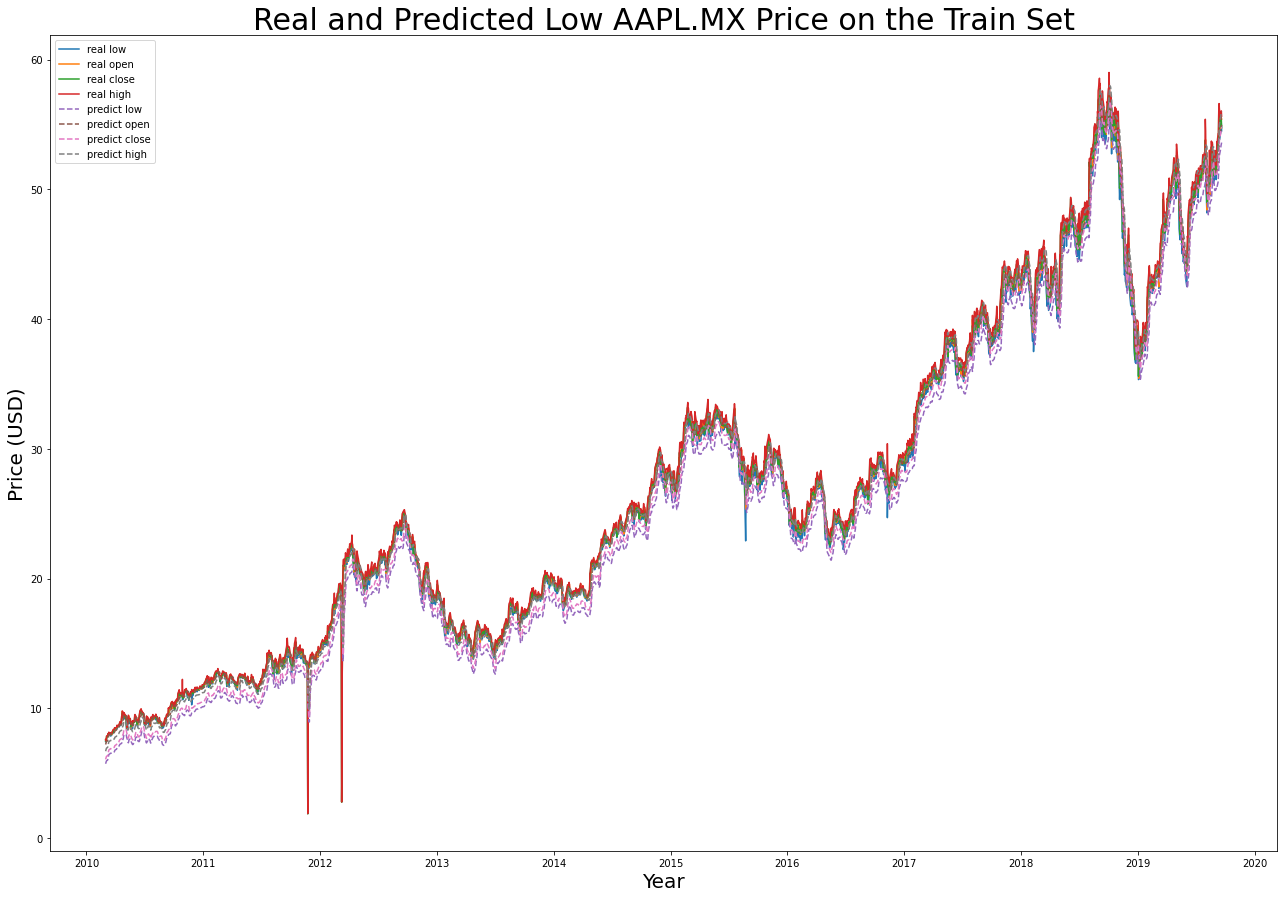

In [ ]:
plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_train_mx, unscaled_y_train_mx)

# predicted values plotted
plt.plot(dates_train_mx, y_train_mx_pred, linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend(['real low','real open','real close','real high','predict low','predict open','predict close','predict high'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low AAPL.MX Price on the Train Set', fontsize=30)

plt.show()

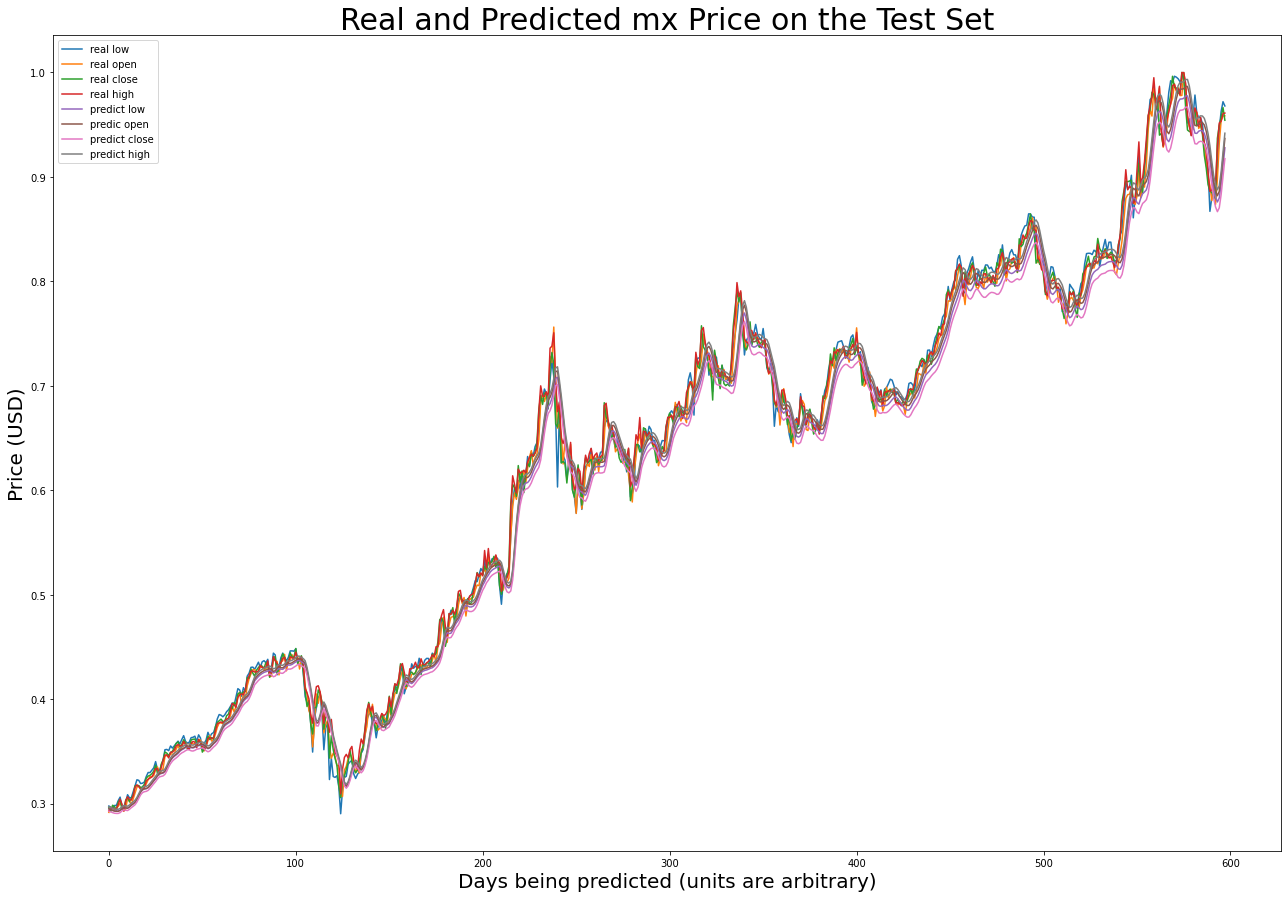

In [ ]:
# Debugging to fix predictions. More specifically, checking if the normalization is the issue.
# Normalization is NOT the issue
low = 0
open = 1
close = 2
high = -1

y_test_low_mx_pred, y_test_open_mx_pred, y_test_close_mx_pred, y_test_high_mx_pred = model_mx.predict(X_test_mx)
preds_arr_mx = np.hstack((y_test_low_mx_pred, y_test_open_mx_pred, y_test_close_mx_pred, y_test_high_mx_pred))
y_test_mx_pred = preds_arr_mx

plt.gcf().set_size_inches(22, 15, forward=True)
currentFig.set_facecolor('white')

real = plt.plot(y_test_mx[low:high], label='real')
pred = plt.plot(y_test_mx_pred[low:high], label='predicted')

plt.legend(['real low','real open','real close','real high','predict low','predic open','predict close','predict high'])
plt.xlabel('Days being predicted (units are arbitrary)', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted mx Price on the Test Set', fontsize=30)

plt.show()

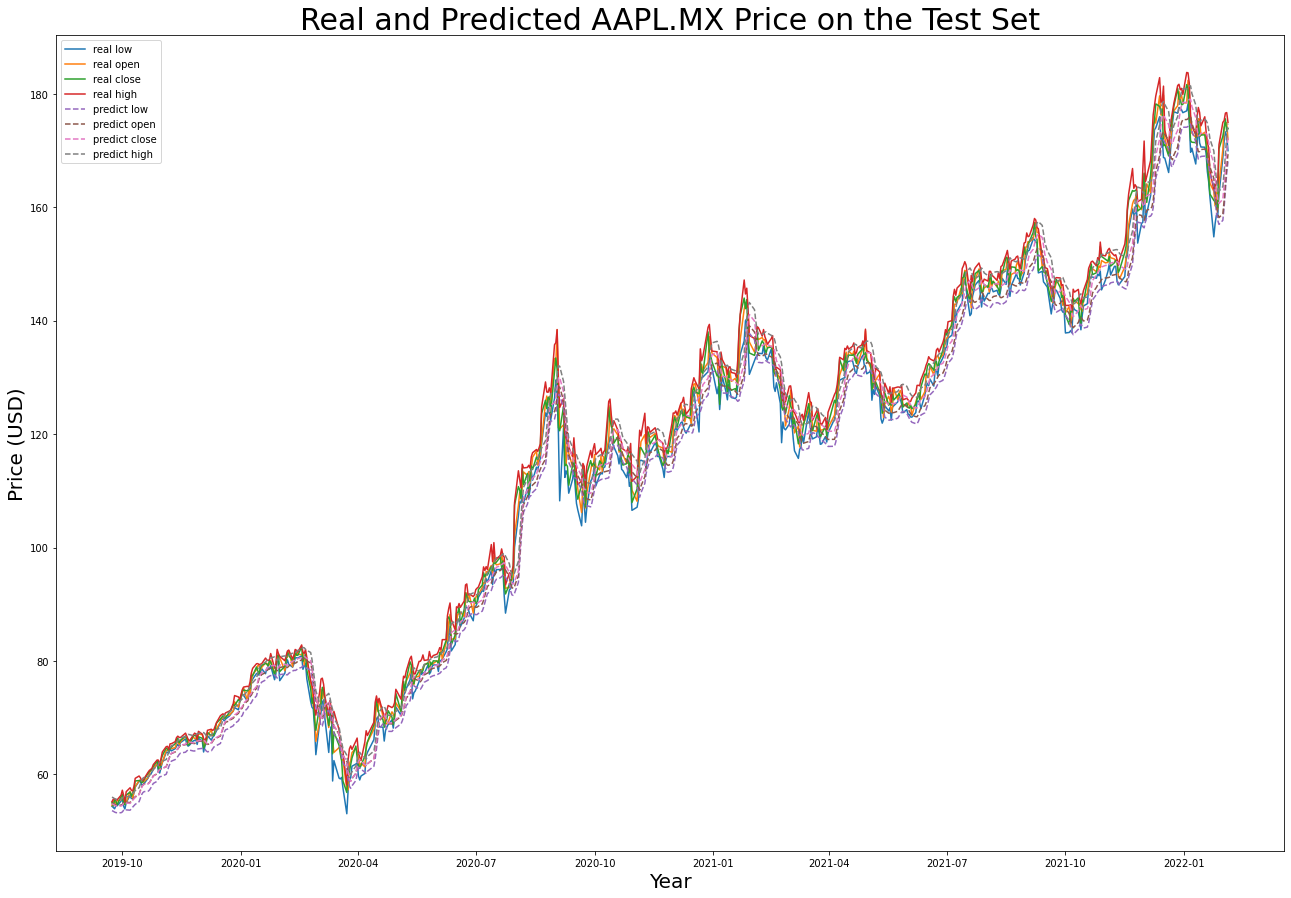

In [ ]:
plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_mx, unscaled_y_test_mx)

# predicted values plotted
plt.plot(dates_test_mx, y_test_mx_pred, linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend(['real low','real open','real close','real high','predict low','predict open','predict close','predict high'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted AAPL.MX Price on the Test Set', fontsize=30)

plt.show()

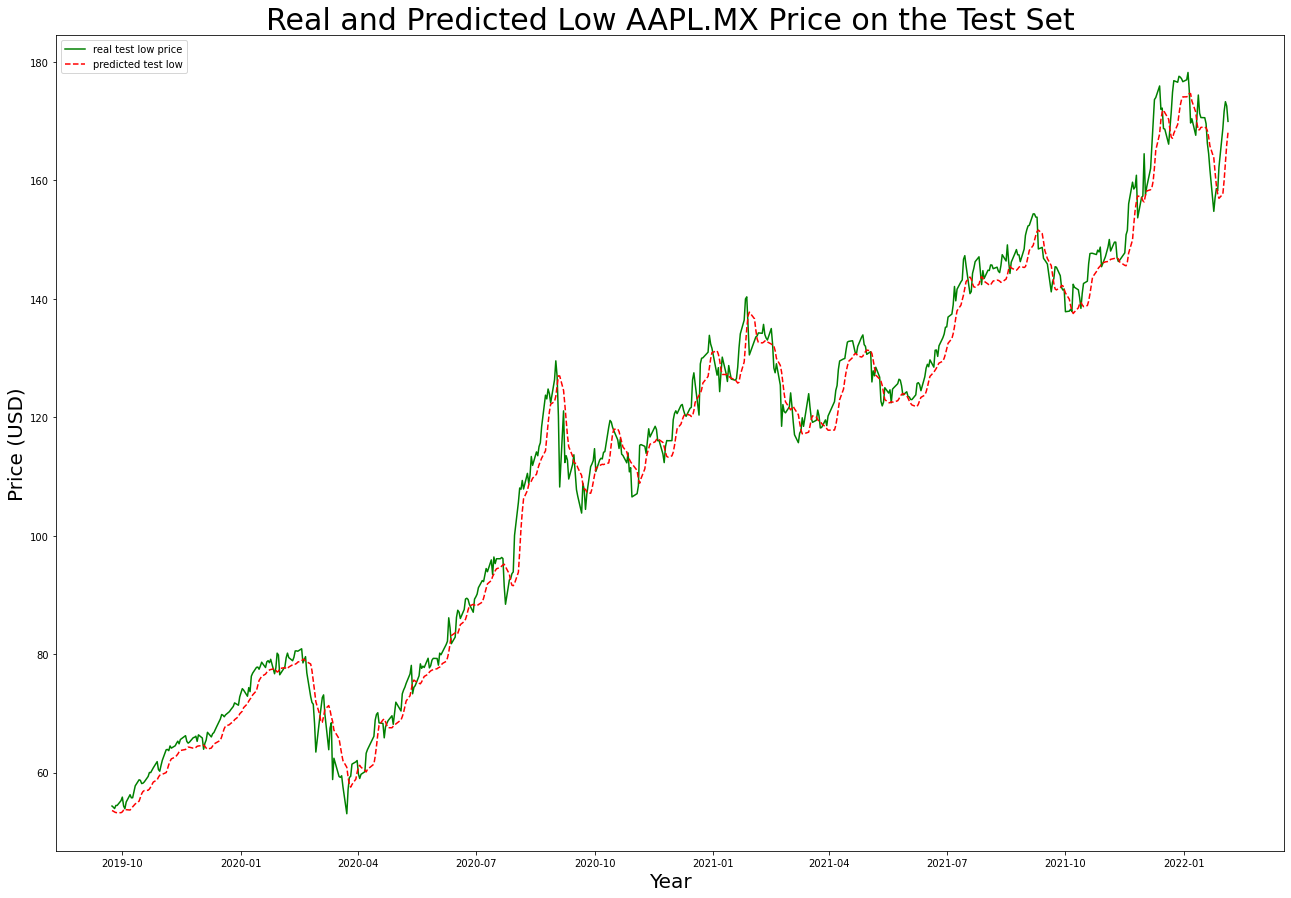

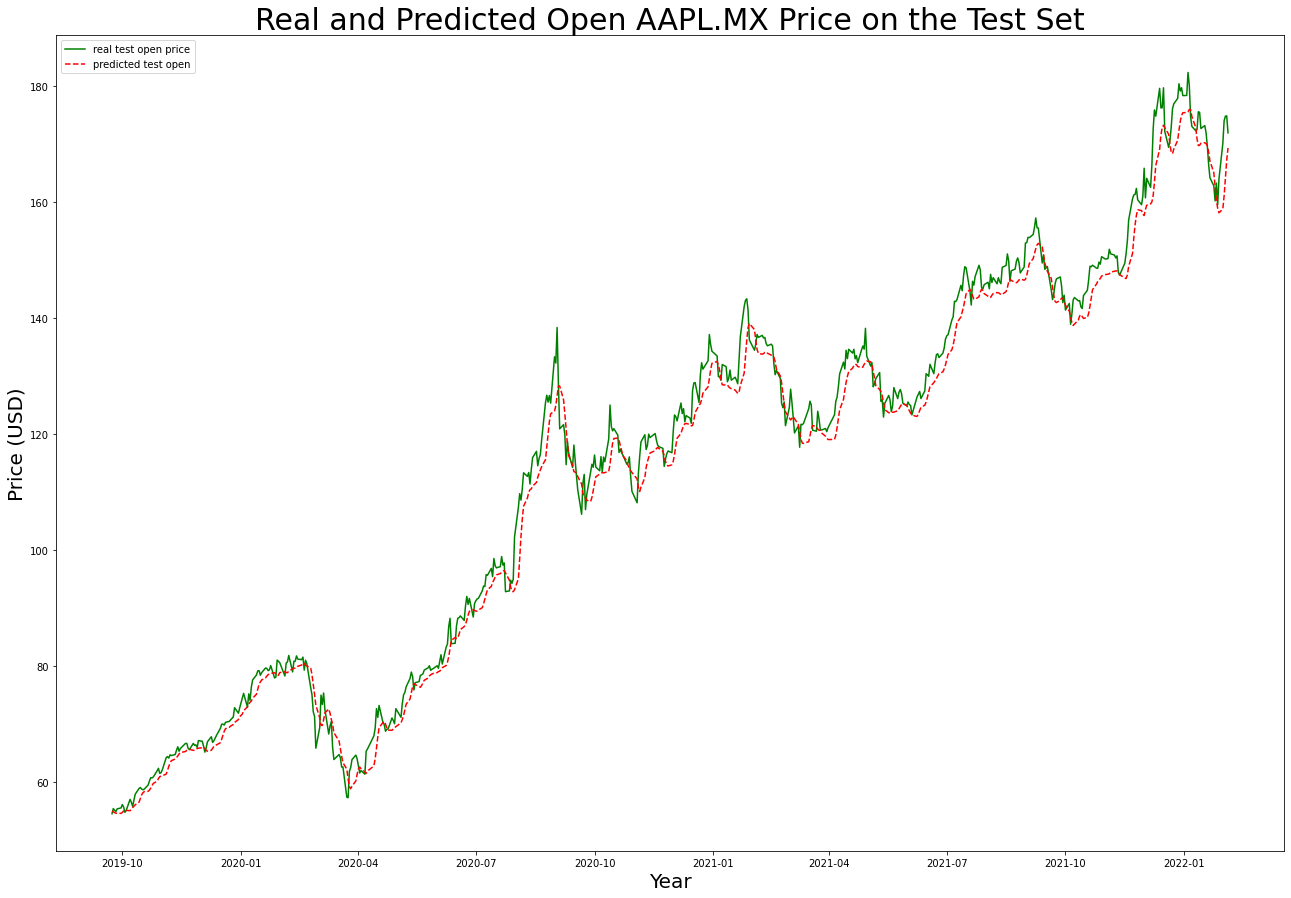

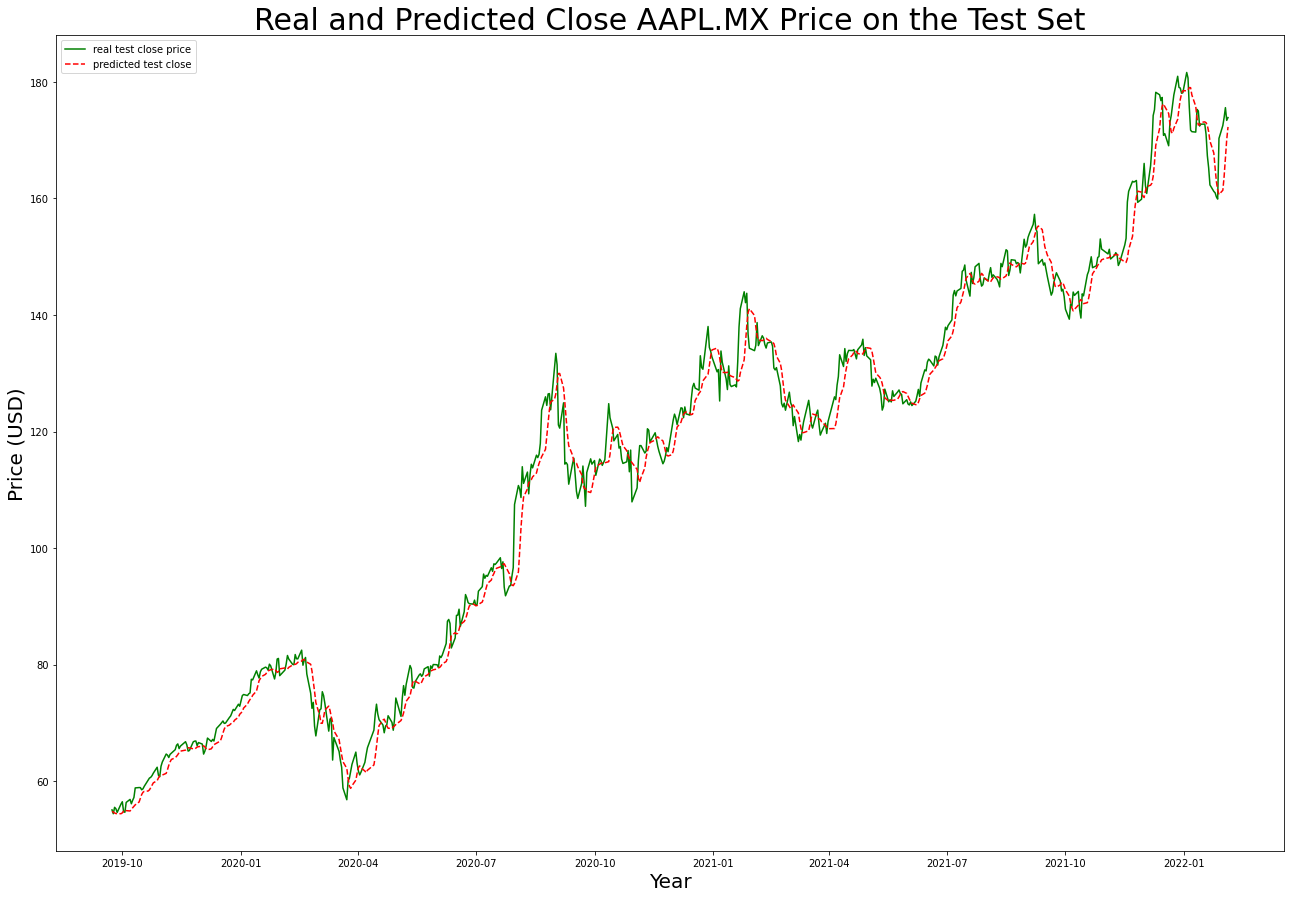

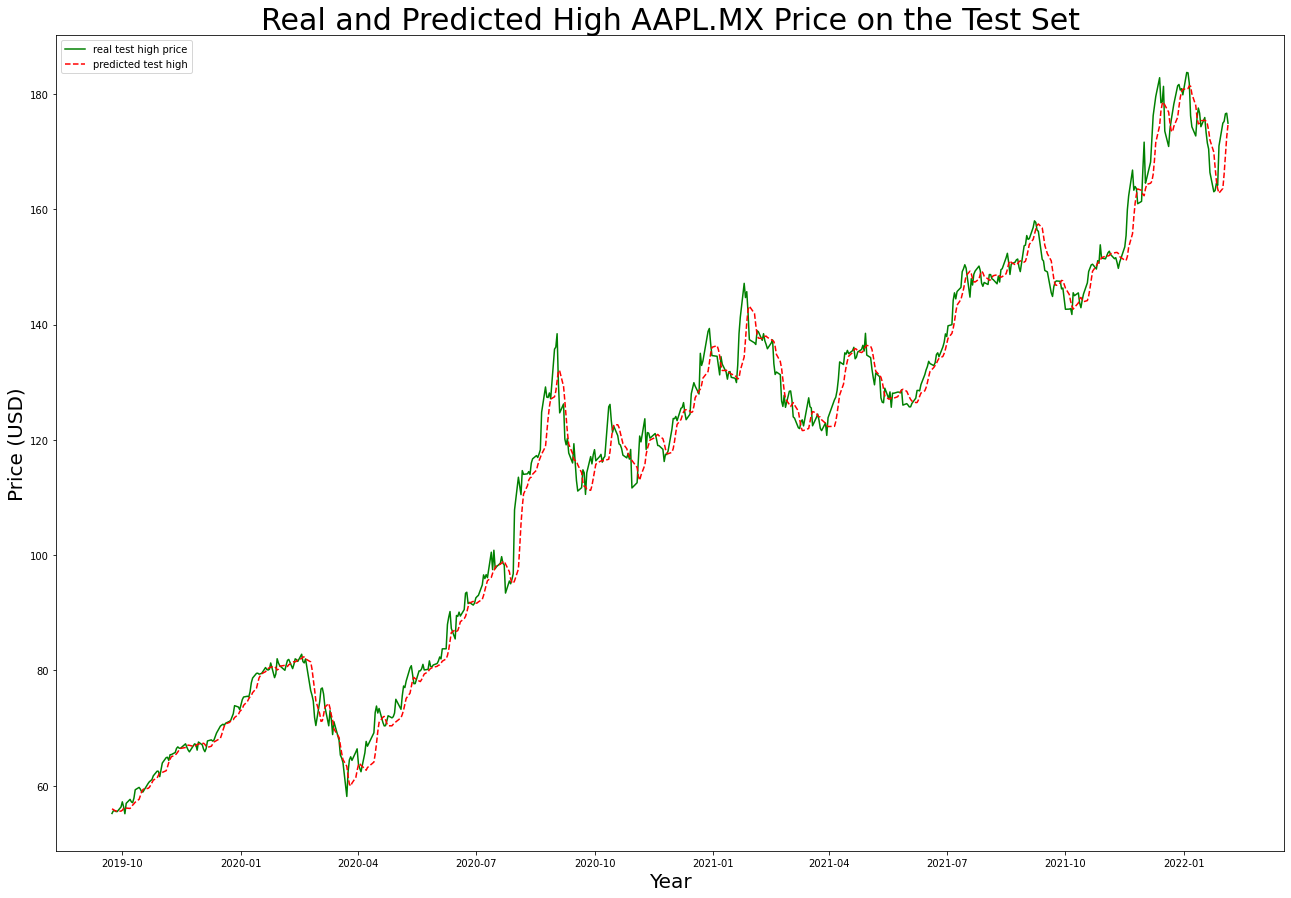

In [ ]:
y_test_low_mx_pred, y_test_open_mx_pred, y_test_close_mx_pred, y_test_high_mx_pred = model_mx.predict(X_test_mx)
testpreds_arr_mx = np.hstack((y_test_low_mx_pred, y_test_open_mx_pred, y_test_close_mx_pred, y_test_high_mx_pred))
y_test_mx_pred = y_normaliser_mx.inverse_transform(testpreds_arr_mx)

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_mx, unscaled_y_test_mx[:,low], label='real test low price', color='g')

# predicted values plotted
plt.plot(dates_test_mx, y_test_mx_pred[:,low], label='predicted test low', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low AAPL.MX Price on the Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_mx, unscaled_y_test_mx[:,open], label='real test open price', color='g')

# predicted values plotted
plt.plot(dates_test_mx, y_test_mx_pred[:,open], label='predicted test open', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Open AAPL.MX Price on the Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_mx, unscaled_y_test_mx[:,close], label='real test close price', color='g')

# predicted values plotted
plt.plot(dates_test_mx, y_test_mx_pred[:,close], label='predicted test close', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Close AAPL.MX Price on the Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(dates_test_mx, unscaled_y_test_mx[:,high], label='real test high price', color='g')

# predicted values plotted
plt.plot(dates_test_mx, y_test_mx_pred[:,high], label='predicted test high', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted High AAPL.MX Price on the Test Set', fontsize=30)

plt.show()

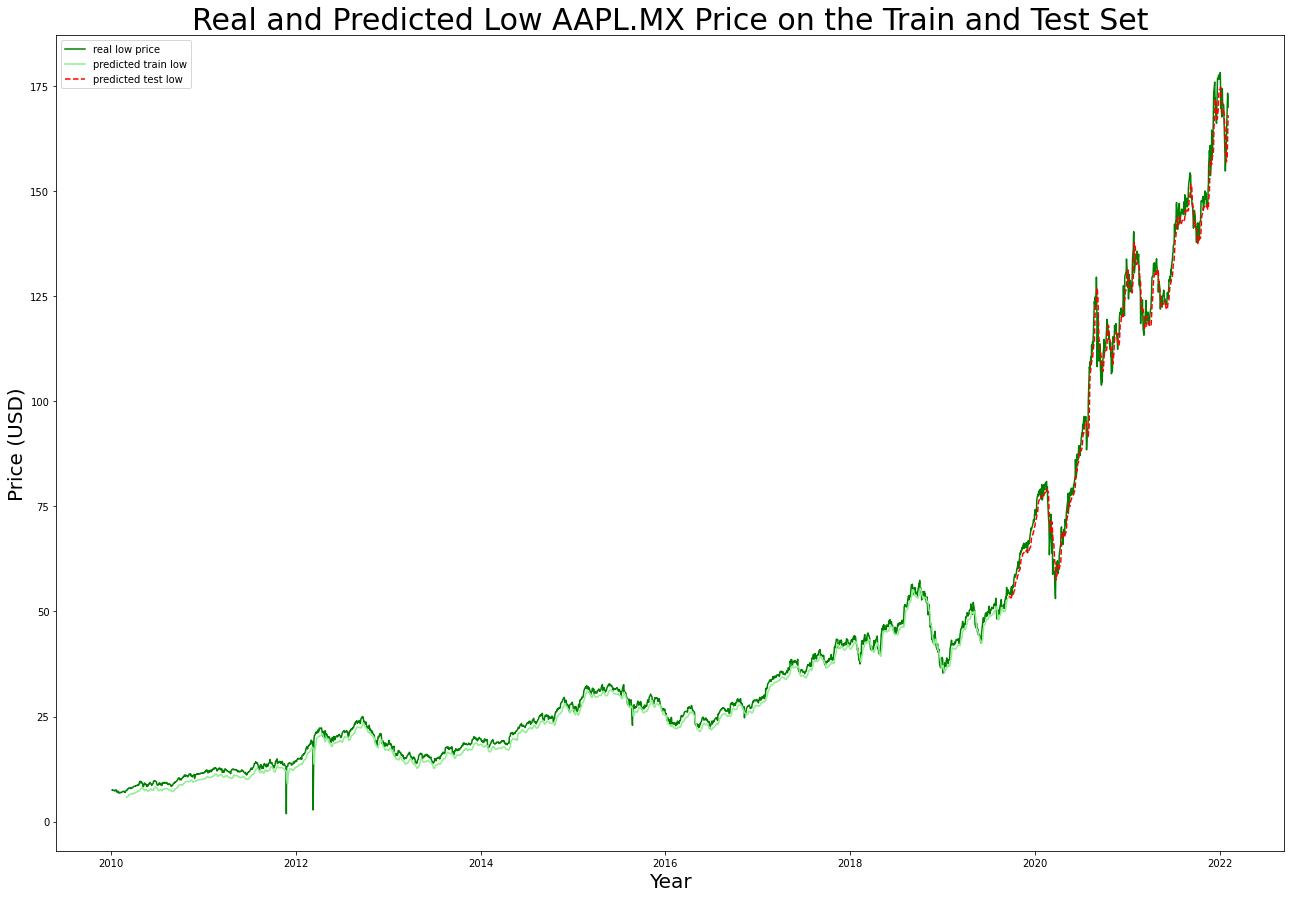

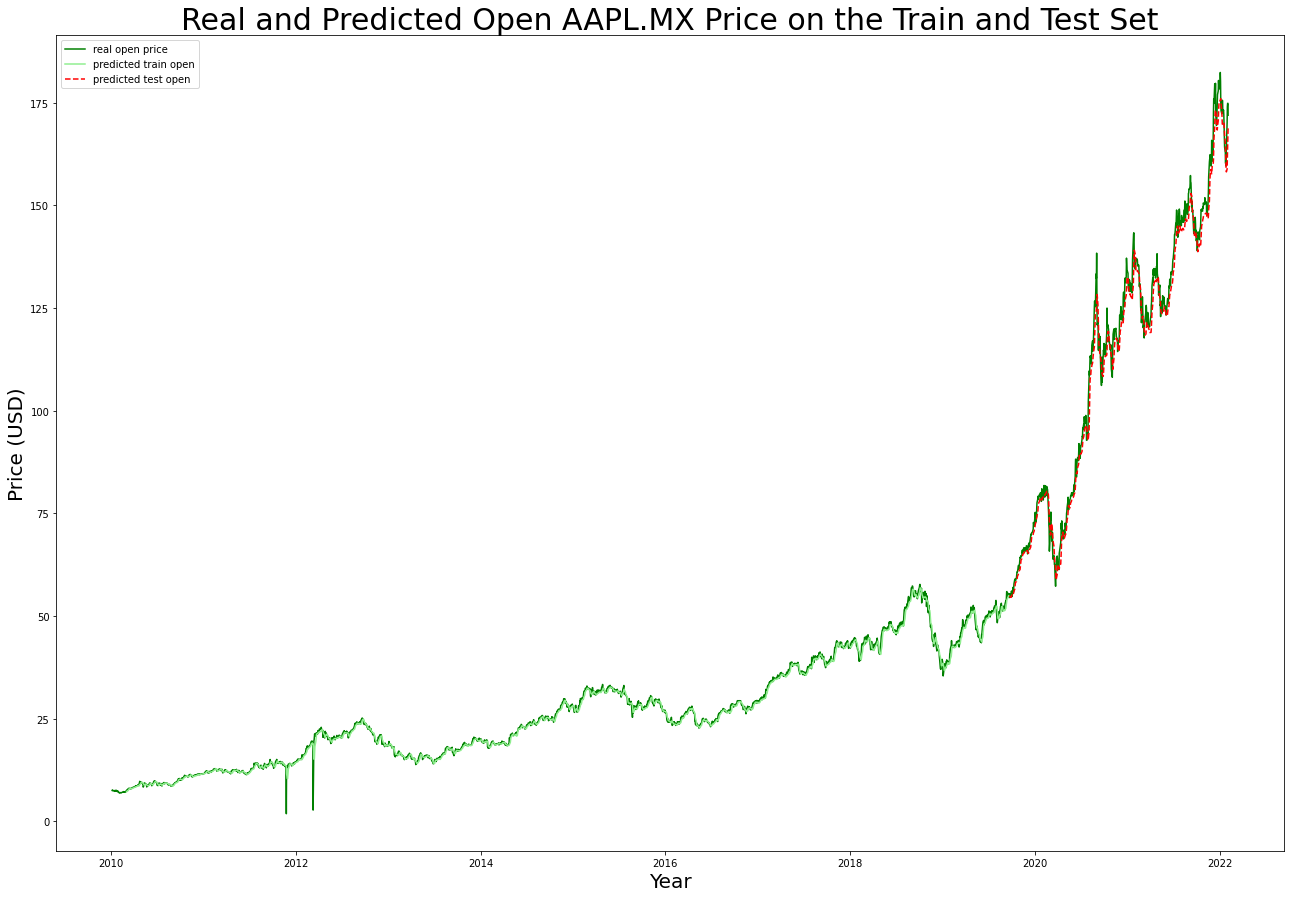

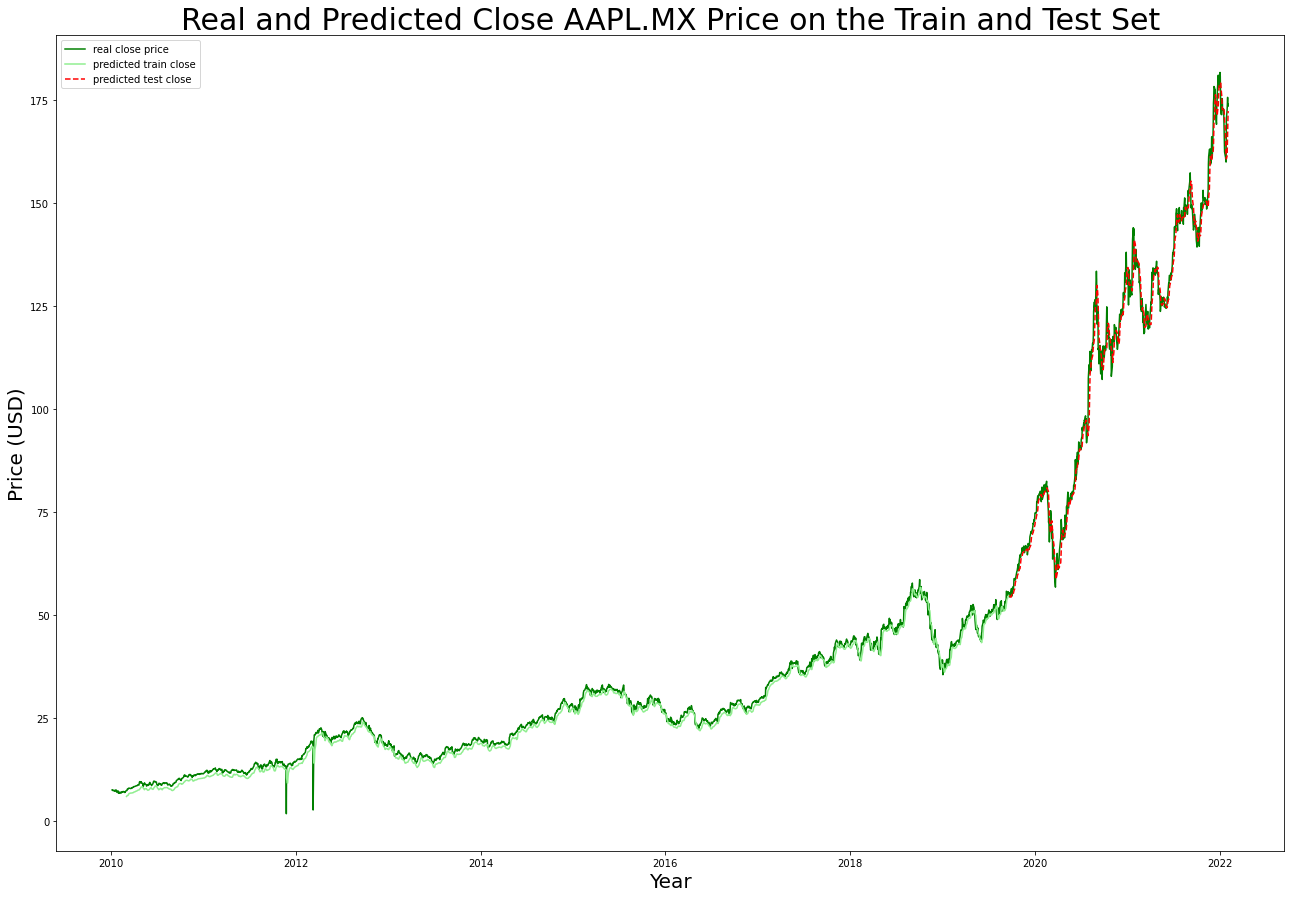

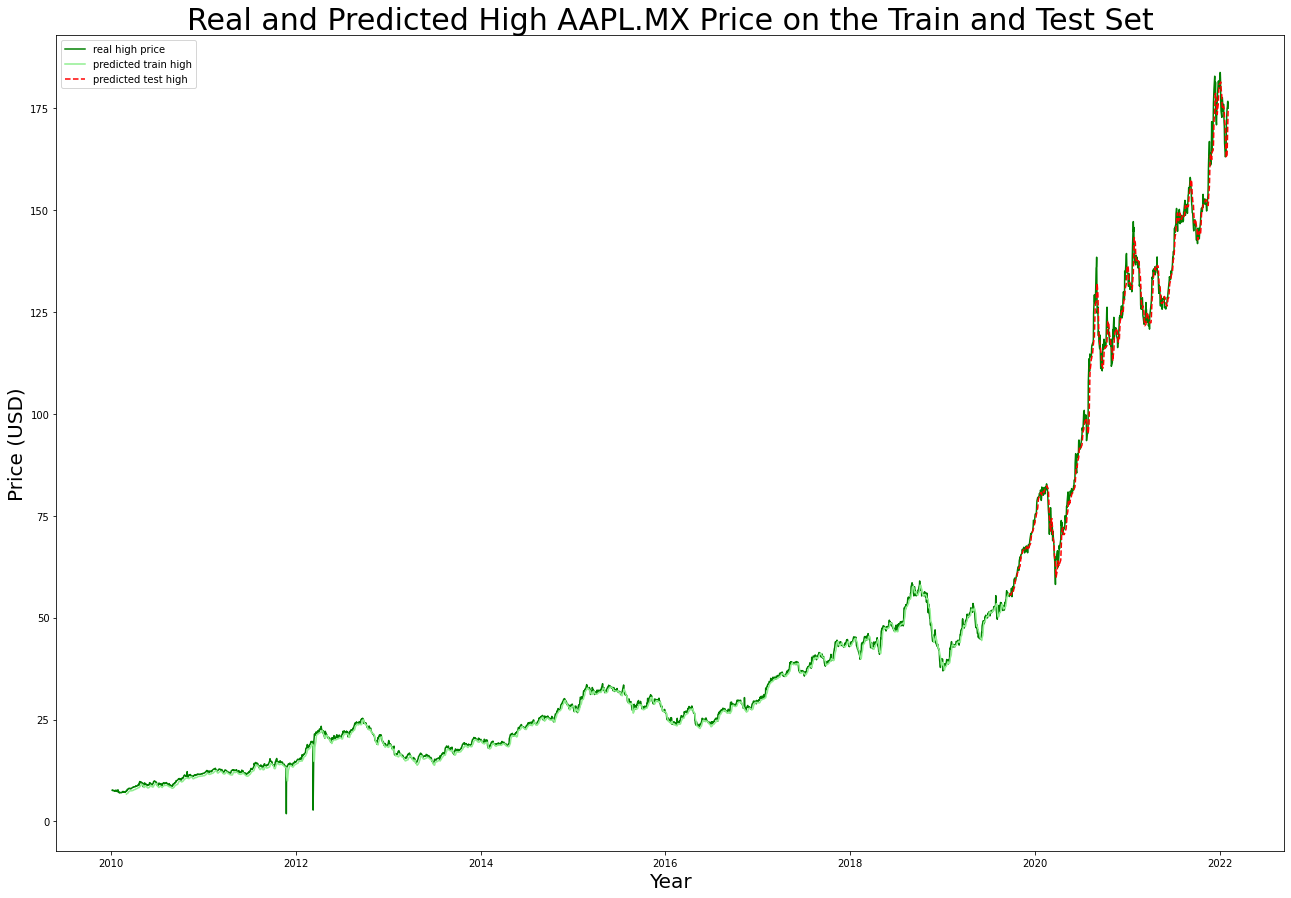

In [ ]:
y_test_low_mx_pred, y_test_open_mx_pred, y_test_close_mx_pred, y_test_high_mx_pred = model_mx.predict(X_test_mx)
testpreds_arr_mx = np.hstack((y_test_low_mx_pred, y_test_open_mx_pred, y_test_close_mx_pred, y_test_high_mx_pred))
y_test_mx_pred = y_normaliser_mx.inverse_transform(testpreds_arr_mx)

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_mx['xlow'], label='real low price', color='g')

# predicted values plotted
plt.plot(dates_train_mx, y_train_mx_pred[:,low], label='predicted train low', color='lightgreen')
plt.plot(dates_test_mx, y_test_mx_pred[:,low], label='predicted test low', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Low AAPL.MX Price on the Train and Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_mx['xopen'], label='real open price', color='g')

# predicted values plotted
plt.plot(dates_train_mx, y_train_mx_pred[:,open], label='predicted train open', color='lightgreen')
plt.plot(dates_test_mx, y_test_mx_pred[:,open], label='predicted test open', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Open AAPL.MX Price on the Train and Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_mx['xclose'], label='real close price', color='g')

# predicted values plotted
plt.plot(dates_train_mx, y_train_mx_pred[:,close], label='predicted train close', color='lightgreen')
plt.plot(dates_test_mx, y_test_mx_pred[:,close], label='predicted test close', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted Close AAPL.MX Price on the Train and Test Set', fontsize=30)

plt.show()

plt.gcf().set_size_inches(22, 15, forward=True)
# real values plotted
plt.plot(stock_mx['xhigh'], label='real high price', color='g')

# predicted values plotted
plt.plot(dates_train_mx, y_train_mx_pred[:,high], label='predicted train high', color='lightgreen')
plt.plot(dates_test_mx, y_test_mx_pred[:,high], label='predicted test high', color='r', linestyle='dashed')

currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted High AAPL.MX Price on the Train and Test Set', fontsize=30)

plt.show()

In [ ]:
#Evaluation MAE, RMSE, MAPE, RMSPE of High Price 
def evaluation(unscaled_y_mx, y_mx_pred, indexc, x_mx):
    mae = mean_absolute_error(unscaled_y_mx[:,indexc], y_mx_pred[:,indexc])
    rmse = math.sqrt(mean_squared_error(unscaled_y_mx[:,indexc], y_mx_pred[:,indexc]))
    mape = np.mean(np.abs((unscaled_y_mx[:,indexc] - y_mx_pred[:,indexc])/unscaled_y_mx[:,indexc]))*100

    prermspe = ((y_mx_pred[:,indexc] - unscaled_y_mx[:,indexc])/unscaled_y_mx[:,indexc])
    rmspe_data = np.array([None]*len(x_mx))
    for i in range(len(x_mx)):
        rmspe_data[i] = math.pow(prermspe[i],2)
    rmspe = math.sqrt(np.mean(rmspe_data))*100
    print('MAE:', mae, '  \nRMSE:', rmse, '  \nMAPE:', mape, '  \nRMSPE:', rmspe)
    
# Low
# Calculating Train data prediction performance metrics
print('Evaluation Low Train Data Prediction')
evaluation(unscaled_y_train_mx, y_train_mx_pred, low, X_train_mx)
# Calculating Test data prediction performance metrics
print('Evaluation Low Test Data Prediction')
evaluation(unscaled_y_test_mx, y_test_mx_pred, low, X_test_mx)

# Open
# Calculating Train data prediction performance metrics
print('\nEvaluation Open Train Data Prediction')
evaluation(unscaled_y_train_mx, y_train_mx_pred, open, X_train_mx)
# Calculating Test data prediction performance metrics
print('Evaluation Open Test Data Prediction')
evaluation(unscaled_y_test_mx, y_test_mx_pred, open, X_test_mx)

# Close
# Calculating Train data prediction performance metrics
print('\nEvaluation Close Train Data Prediction')
evaluation(unscaled_y_train_mx, y_train_mx_pred, close, X_train_mx)
# Calculating Test data prediction performance metrics
print('Evaluation Close Test Data Prediction')
evaluation(unscaled_y_test_mx, y_test_mx_pred, close, X_test_mx)

# High
# Calculating Train data prediction performance metrics
print('\nEvaluation High Train Data Prediction')
evaluation(unscaled_y_train_mx, y_train_mx_pred, high, X_train_mx)
# Calculating Test data prediction performance metrics
print('Evaluation High Test Data Prediction')
evaluation(unscaled_y_test_mx, y_test_mx_pred, high, X_test_mx)

Evaluation Low Train Data Prediction
MAE: 1.3797672104305212   
RMSE: 1.549814077518981   
MAPE: 7.077865311808614   
RMSPE: 17.426327876550204
Evaluation Low Test Data Prediction
MAE: 2.87256428503331   
RMSE: 3.6342943254574003   
MAPE: 2.705764664296309   
RMSPE: 3.4472967752499457

Evaluation Open Train Data Prediction
MAE: 0.5087735955572676   
RMSE: 0.8256294902982351   
MAPE: 2.4038014321884633   
RMSPE: 17.46819519900747
Evaluation Open Test Data Prediction
MAE: 2.850556141596445   
RMSE: 3.656359130855294   
MAPE: 2.4957431202024996   
RMSPE: 3.097255840533962

Evaluation Close Train Data Prediction
MAE: 1.1155476951278274   
RMSE: 1.3233349706059336   
MAPE: 5.75012354613328   
RMSPE: 17.307814375610736
Evaluation Close Test Data Prediction
MAE: 2.5863996492294943   
RMSE: 3.4721540537068276   
MAPE: 2.330661986295147   
RMSPE: 3.073205273637506

Evaluation High Train Data Prediction
MAE: 0.6763261532736171   
RMSE: 0.9547576694671185   
MAPE: 3.4954270634227034   
RMSPE: 17.

In [ ]:
unscaled_y_test_mx[:,high]

array([ 55.19498476,  55.63719885,  55.68166893,  55.5363869 ,
        55.51727191,  56.32451086,  57.21415463,  56.33802172,
        55.14825515,  56.950824  ,  57.64245983,  57.21010133,
        57.06032598,  57.84796088,  59.30713846,  59.71874845,
        59.41039761,  58.93870622,  58.92792693,  59.30652141,
        60.39938696,  60.70844577,  60.88523157,  61.09424958,
        61.72061609,  62.54340861,  62.50589904,  61.58312773,
        62.77418332,  63.94985842,  64.88627495,  64.94477868,
        64.40561987,  65.38493969,  65.4092824 ,  65.76842972,
        66.47908318,  66.74325932,  66.53974743,  66.48715651,
        67.27752442,  66.68713234,  66.2087127 ,  65.88237011,
        66.9100982 ,  67.27242115,  67.15178797,  66.18125624,
        67.59388838,  67.09021331,  66.32543108,  65.91979132,
        66.484976  ,  67.7758468 ,  67.96583987,  67.75584386,
        67.9130705 ,  69.13975835,  70.34297918,  70.52449074,
        70.67716098,  70.49416272,  70.84203339,  71.17

In [ ]:
y_train_close_mx_pred

array([[0.02329379],
       [0.02380841],
       [0.02430343],
       ...,
       [0.2931934 ],
       [0.2939825 ],
       [0.2945374 ]], dtype=float32)

In [ ]:
y_test_mx_pred[:,high]

array([ 55.99596 ,  55.8809  ,  55.724144,  55.627075,  55.601143,
        55.600964,  55.751637,  56.0805  ,  56.250847,  56.128227,
        56.06794 ,  56.31765 ,  56.635876,  56.8801  ,  57.154003,
        57.64863 ,  58.32681 ,  58.962193,  59.339462,  59.485657,
        59.54579 ,  59.745037,  60.122913,  60.56377 ,  60.976917,
        61.358994,  61.834347,  62.1746  ,  62.2325  ,  62.318157,
        62.61599 ,  63.269173,  64.0326  ,  64.60359 ,  65.035706,
        65.32343 ,  65.565865,  65.858795,  66.22586 ,  66.470474,
        66.64379 ,  66.88182 ,  67.05493 ,  67.0169  ,  66.84138 ,
        66.82824 ,  66.97572 ,  67.181656,  67.231476,  67.31638 ,
        67.38311 ,  67.169876,  66.840645,  66.6606  ,  66.86131 ,
        67.23202 ,  67.58625 ,  67.84683 ,  68.232216,  68.866684,
        69.63202 ,  70.31673 ,  70.74945 ,  70.98289 ,  71.20376 ,
        71.45846 ,  71.842545,  72.37139 ,  72.880745,  73.33534 ,
        73.956665,  74.65029 ,  75.09672 ,  75.44131 ,  75.670

In [ ]:
model_mx.save('modelmx.h5')

# **Predict for 1 Day AAPL.MX**

In [ ]:
data_pred_mx = normalizedData_mx[num_data_mx-200:,:5].reshape(5,40,5)
data_pred_mx

array([[[7.39438558e-01, 7.35607509e-01, 7.29827346e-01, 7.34274680e-01,
         5.04659505e-03],
        [7.37782564e-01, 7.55475766e-01, 7.37270601e-01, 7.51143735e-01,
         4.39313546e-03],
        [7.30121732e-01, 7.28840374e-01, 7.29392332e-01, 7.30384657e-01,
         3.27306618e-03],
        [7.32667637e-01, 7.19469305e-01, 7.25693855e-01, 7.27992852e-01,
         1.75169195e-03],
        [7.03682416e-01, 7.22805404e-01, 7.00575132e-01, 7.17296740e-01,
         7.82256224e-03],
        [7.14336471e-01, 6.99571101e-01, 7.07138154e-01, 7.09102963e-01,
         3.90180472e-03],
        [7.09526787e-01, 7.02279960e-01, 7.03985139e-01, 7.02015013e-01,
         5.56985714e-03],
        [7.17767716e-01, 7.07398749e-01, 7.08105517e-01, 7.13316611e-01,
         3.05222485e-03],
        [7.08329972e-01, 7.13209590e-01, 6.98558649e-01, 7.09723047e-01,
         2.79471398e-03],
        [6.85283883e-01, 6.85765153e-01, 6.92138315e-01, 6.89560091e-01,
         4.59976218e-03],
        [6

In [ ]:
ylow_mx,yopen_mx,yclose_mx,yhigh_mx = model_mx.predict(data_pred_mx[[4]])
yhat_mx = ylow_mx,yopen_mx,yclose_mx,yhigh_mx
nextday_pred_mx = np.hstack((ylow_mx,yopen_mx,yclose_mx,yhigh_mx))
nextday_pred_mx = y_normaliser_mx.inverse_transform(nextday_pred_mx)
nextday_pred_mx

array([[168.93272, 170.27435, 173.18523, 175.57225]], dtype=float32)